### Import Library

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install scorecardpy
import scorecardpy as sc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
!pip install feature_engine
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

import warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Data Set

In [5]:
df = pd.read_csv("loan_data_2007_2014.csv")
df.head()

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

### Data Cleaning

In [6]:
# Cek setiap kolom data untuk mengetahui kolom yg memiliki missing value dan data uniq
dfdesc = []
for i in df.columns :
    dfdesc.append([i, len(df[i]),
                    df[i].dtypes,
                    df[i].isna().sum(),
                    round(((df[i].isna().sum()/(len(df)))*100),2),
                    df[i].nunique(),
                    df[i].drop_duplicates().sample(2, replace=True).values])
pd.DataFrame(dfdesc, columns=['dataFeatures','dataLength','dataType','null','nullPct','unique','uniqueSample'])

dataFeatures  dataLength dataType   null  nullPct  unique  \
0         Unnamed: 0       10100    int64      0      0.0   10100   
1                 id       10100    int64      0      0.0   10100   
2          member_id       10100    int64      0      0.0   10100   
3          loan_amnt       10100    int64      0      0.0     644   
4        funded_amnt       10100    int64      0      0.0     746   
..               ...         ...      ...    ...      ...     ...   
70          all_util       10100  float64  10100    100.0       0   
71  total_rev_hi_lim       10100  float64  10100    100.0       0   
72            inq_fi       10100  float64  10100    100.0       0   
73       total_cu_tl       10100  float64  10100    100.0       0   
74      inq_last_12m       10100  float64  10100    100.0       0   

          uniqueSample  
0         [7235, 3667]  
1    [1002366, 982218]  
2   [1090709, 1102765]  
3       [15200, 10400]  
4        [4800, 20350]  
..                 ...  
70          [nan, nan]  
71          [nan, nan]  
72          [nan, nan]  
73          [nan, nan]  
74          [nan, nan]  

[75 rows x 7 columns]

1. terdapat beberapa kolom yang tidak memiliki nilai sama sekali, hal ini mungkin terjadi karena beberapa hal, seperti :
    a. kesalahan join kolom,
    b. tidak terdapat record historis pada kolom kolom tersebut

2. Pada kolom tot_coll_amt, dan tot_cut_bal, missing value akan di isi dengan imputasi nol, kemungkinan missing values masuk akal jika di impute dengan nilai 0 karena tidak ada catatan historis, sedangkan untuk total_rev_hi_lim adalah kolom batas kredit jadi akan diimputasi dengan nilai mediannya

In [7]:
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(0)
df["total_rev_hi_lim"]  = df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].median())

In [8]:
#check missing values again
df.isnull().sum()/len(df) * 100

Unnamed: 0            0.0
id                    0.0
member_id             0.0
loan_amnt             0.0
funded_amnt           0.0
                    ...  
all_util            100.0
total_rev_hi_lim    100.0
inq_fi              100.0
total_cu_tl         100.0
inq_last_12m        100.0
Length: 75, dtype: float64

In [9]:
#hapus kolom yang tidak memiliki values dan missing values lebih dari 30%
list_drop = [x for x in df.columns if df[x].isnull().sum()/len(df) * 100 > 30]
list_drop

['desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [10]:
df = df.drop(list_drop,axis=1)
df.shape

(10100, 52)

In [11]:
#Handling missing value
mv = df.isnull().sum().sort_values(ascending = False)
non_mv = df.notnull().sum()
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
dtypes = df.dtypes
mv_df = pd.concat([mv, non_mv, percent, dtypes], axis=1, keys=['Missing', 'Non-Missing', 'Percent', 'Dtypes'])
mv_df

Missing  Non-Missing   Percent   Dtypes
emp_title                       660         9440  6.534653   object
emp_length                      357         9743  3.534653   object
last_pymnt_d                     16        10084  0.158416   object
revol_util                        4        10096  0.039604  float64
dti                               1        10099  0.009901  float64
delinq_2yrs                       1        10099  0.009901  float64
recoveries                        1        10099  0.009901  float64
inq_last_6mths                    1        10099  0.009901  float64
open_acc                          1        10099  0.009901  float64
pub_rec                           1        10099  0.009901  float64
revol_bal                         1        10099  0.009901  float64
earliest_cr_line                  1        10099  0.009901   object
zip_code                          1        10099  0.009901   object
total_acc                         1        10099  0.009901  float64
initial_list_status               1        10099  0.009901   object
out_prncp                         1        10099  0.009901  float64
out_prncp_inv                     1        10099  0.009901  float64
total_pymnt                       1        10099  0.009901  float64
total_pymnt_inv                   1        10099  0.009901  float64
total_rec_prncp                   1        10099  0.009901  float64
addr_state                        1        10099  0.009901   object
purpose                           1        10099  0.009901   object
title                             1        10099  0.009901   object
total_rec_late_fee                1        10099  0.009901  float64
acc_now_delinq                    1        10099  0.009901  float64
application_type                  1        10099  0.009901   object
policy_code                       1        10099  0.009901  float64
collections_12_mths_ex_med        1        10099  0.009901  float64
last_credit_pull_d                1        10099  0.009901   object
last_pymnt_amnt                   1        10099  0.009901  float64
collection_recovery_fee           1        10099  0.009901  float64
home_ownership                    1        10099  0.009901   object
annual_inc                        1        10099  0.009901  float64
verification_status               1        10099  0.009901   object
issue_d                           1        10099  0.009901   object
loan_status                       1        10099  0.009901   object
pymnt_plan                        1        10099  0.009901   object
url                               1        10099  0.009901   object
total_rec_int                     1        10099  0.009901  float64
tot_coll_amt                      0        10100  0.000000  float64
Unnamed: 0                        0        10100  0.000000    int64
id                                0        10100  0.000000    int64
sub_grade                         0        10100  0.000000   object
grade                             0        10100  0.000000   object
installment                       0        10100  0.000000  float64
int_rate                          0        10100  0.000000  float64
term                              0        10100  0.000000   object
funded_amnt_inv                   0        10100  0.000000  float64
funded_amnt                       0        10100  0.000000    int64
loan_amnt                         0        10100  0.000000    int64
member_id                         0        10100  0.000000    int64
tot_cur_bal                       0        10100  0.000000  float64

In [12]:
df[df["acc_now_delinq"].isna()]

Unnamed: 0      id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
10099       10099  838022    1048073      15000        15000          15000.0   

             term  int_rate  installment grade  ... collection_recovery_fee  \
10099   60 months     17.49       376.76     D  ...                     NaN   

      last_pymnt_d last_pymnt_amnt last_credit_pull_d  \
10099          NaN             NaN                NaN   

       collections_12_mths_ex_med policy_code application_type acc_now_delinq  \
10099                         NaN         NaN              NaN            NaN   

      tot_coll_amt tot_cur_bal  
10099          0.0         0.0  

[1 rows x 52 columns]

In [13]:
df[(df["annual_inc"].isna())].shape

(1, 52)

In [14]:
#karena annual_inc hanya ada 4 rows, jadi kita hapus saja
df = df.dropna(subset=['annual_inc']).reset_index(drop=True)
df.shape

(10099, 52)

In [15]:
df[df['delinq_2yrs'].isna()]

Empty DataFrame
Columns: [Unnamed: 0, id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal]
Index: []

[0 rows x 52 columns]

jika dilihat bahwa missing values pada kolom **delinq_2yrs**, terlihat kolom **delin1_2yrs** mising values karena tidak ada catatan historis. kolom **delinq_2yrs** memiliki keterkaitan dengan kolom seperti **collections_12_mths_ex_med**, **acc_now_delinq**, **revol_util**, **total_acc**,**open_acc** maka kolom kolom ini akan di imputasi 0 juga

In [16]:
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(0)
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0)
df["total_acc"] = df["total_acc"].fillna(1)
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df["pub_rec"] = df["pub_rec"].fillna(0)
df["collections_12_mths_ex_med"] = df["collections_12_mths_ex_med"].fillna(0)
df['acc_now_delinq'] = df['acc_now_delinq'].fillna(0)
df["open_acc"] = df["open_acc"].fillna(0)

Membuat kolom baru bernama **emp_length_int** untuk menyimpan nilai dari **emp_length** yang dijadikan **int**
**emp_length** < 1 years dijadikan nilai 0 years, missing values pada kolom ini akan dianggap **not have experience job**

In [17]:
#processing kolom yang memiliki missing values
df['emp_length_int'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1 year', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace('n/a',  str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace(' years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace(' year', '')

In [18]:
df['emp_length_int'] = pd.to_numeric(df['emp_length_int'])
# Transforms the values to numeric.

#impute 0 
df["emp_length_int"] =df["emp_length_int"].fillna(0)


- beberapa kolom tidak relevan dalam faktor yang menentukan ciri khas yang menentukan seorang nasabah dapat membayar pinjaman atau tidak sehingga beberapa kolom yang di rasa tidak relevan akan dihapus
- machine learning yang akan dirancang, tidak menyertakan demographics wilayah agar machine learning tidak melakukan diskriminasi pada suatu daerah/wilayah sehingga kolom yang berhubungan dengan demographics akan dihapus

In [19]:
#hapus beberapa kolom
df = df.drop(['Unnamed: 0',
              "id",
             "member_id",
             'title',
              'zip_code',
              'addr_state',
             "earliest_cr_line",
             "url",
             "issue_d",
             "emp_title",
             "policy_code",
             "emp_length",
             "last_credit_pull_d",
             "last_pymnt_d",
             "application_type"],axis=1)
df = df.reset_index(drop=True)

In [20]:
100*(df.isnull().sum())/len(df)

loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
int_rate                      0.0
installment                   0.0
grade                         0.0
sub_grade                     0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
loan_status                   0.0
pymnt_plan                    0.0
purpose                       0.0
dti                           0.0
delinq_2yrs                   0.0
inq_last_6mths                0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
revol_util                    0.0
total_acc                     0.0
initial_list_status           0.0
out_prncp                     0.0
out_prncp_inv                 0.0
total_pymnt                   0.0
total_pymnt_inv               0.0
total_rec_prncp               0.0
total_rec_int                 0.0
total_rec_late

### Target Definition
Nasabah yang status pinjamannya adalah 'Charged Off','Default','Late (16-30 days)','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off',"Does not meet the credit policy. Status:Fully Paid". kita definisikan sebagai nasabah dengan kategori **bad** dan diberi flag 0, selain itu nasabah dengan kategori **good** akan diberi flag 1. untuk 'current' dan 'in grace period' tidak dapat digunakan karena belum dapat dipastikan apakah merupakan peminjam yang menunggak atau tidak

In [21]:
df["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'],
      dtype=object)

In [22]:
#filtering data, exclude 'load_status Current' and 'in grace period'
df = df[~(df["loan_status"].isin(["Current","In Grace Period"]))]

#replacing home_ownership
df["home_ownership"] = df['home_ownership'].replace(["NONE","ANY"],["OTHER","OTHER"])

In [23]:
df["good_bad"] = np.where(df['loan_status'].isin(['Charged Off','Default','Late (16-30 days)',
       'Late (31-120 days)','Does not meet the credit policy. Status:Charged Off',"Does not meet the credit policy. Status:Fully Paid"]),0,1)

#drop kolom loan_status
df = df.drop("loan_status",axis=1)

#check
df["good_bad"].value_counts()

1    7558
0    1563
Name: good_bad, dtype: int64

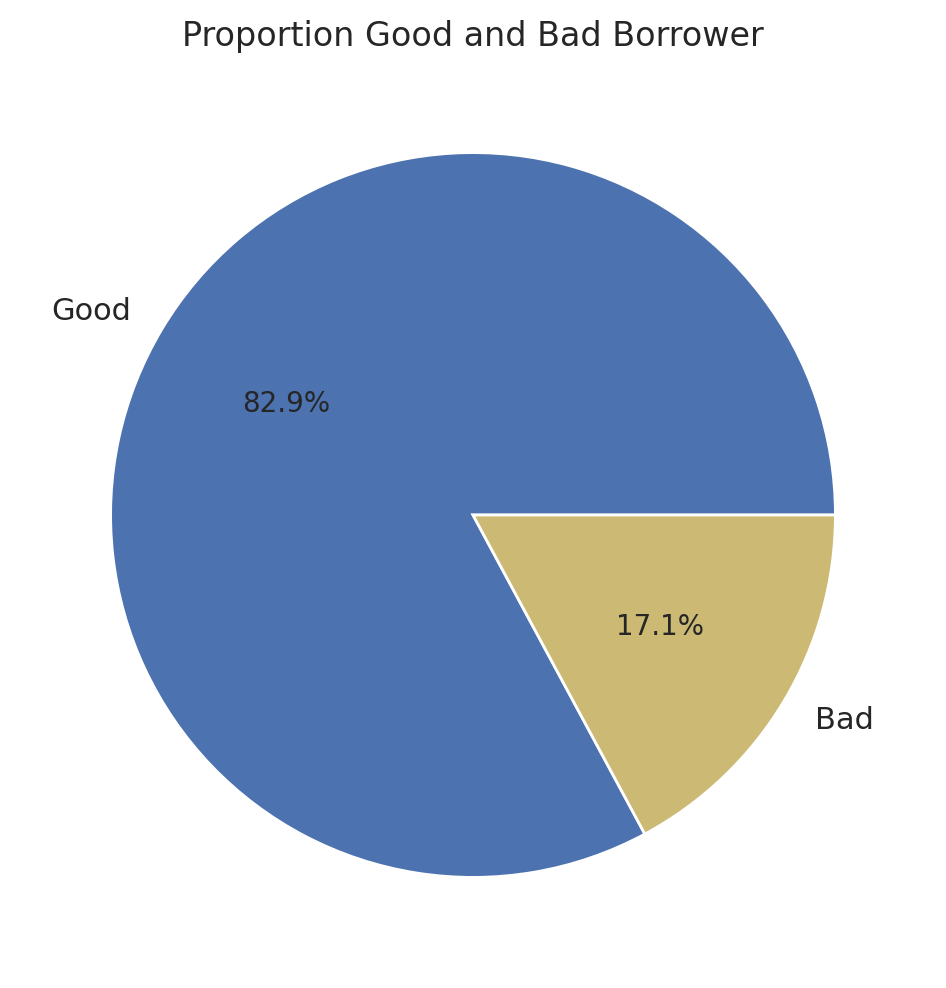

In [24]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Proportion Good and Bad Borrower",fontsize=12)
plt.pie(df["good_bad"].value_counts(),labels=["Good","Bad"],
       autopct='%1.1f%%',colors=["b","y"]);

**WOE** atau Weight of Evidence kita gunakan untuk mengukur antara nasabah baik dan buruk
nilai dari **WOE** ini akan digunakan untuk menghitung **IV** atau Infromation Value

In [25]:
import pandas as pd
import scipy.stats as stats

#categoric fitur dan continuous fiture

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'good_bad']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'good_bad']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'good_bad': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['good_bad'])

            if (
                    abs(r)==1 and                                                        # periksa apakah WOE untuk tiap bin adalah monotomic
                    df_grouped[self.feature].min() > self.bin_min_size                   # periksa apakah size setiap bin besar dari 5%
                    and not (df_grouped[self.feature] == df_grouped['good_bad']).any()      # periksa apakah label Yes dan No jumlahnya adalah 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'good_bad']]

Information Value kita gunakan untuk menghitung seberapa penting dan prediktif terhadap target

In [26]:
# Information Value
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'good_bad': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [27]:
from pandas.core.dtypes.common import is_numeric_dtype
#selection feat
feats_dict = {}

for col in [c for c in df.columns if c != 'good_bad']:
  if is_numeric_dtype(df[col]):
    feats_dict[col] = ContinuousFeature(df,col)
  else :
    feats_dict[col] = CategoricalFeature(df,col)

feats = list(feats_dict.values())

In [28]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()


df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

iv        p-value  effect_size  \
last_pymnt_amnt             2.225684  3.653560e-242     0.349143   
total_rec_prncp             1.457922   0.000000e+00     0.446745   
sub_grade                   0.589130  1.087075e-135     0.286741   
total_pymnt_inv             0.579988  1.935734e-180     0.305352   
total_pymnt                 0.576875  6.186841e-180     0.304933   
grade                       0.468372  1.133020e-136     0.266501   
int_rate                    0.432695  7.088632e-123     0.249638   
term                        0.407949  3.622868e-132     0.256151   
revol_util                  0.094920   1.141943e-23     0.116582   
purpose                     0.089800   1.235159e-18     0.111532   
funded_amnt_inv             0.060798   1.061066e-17     0.094904   
loan_amnt                   0.056238   3.322703e-17     0.091214   
funded_amnt                 0.054895   8.311402e-17     0.090105   
annual_inc                  0.034311   4.184865e-11     0.069080   
dti                         0.026435   3.894978e-06     0.060081   
verification_status         0.024671   1.179070e-07     0.059145   
total_rec_int               0.023280   5.009542e-08     0.057076   
installment                 0.022057   5.377649e-07     0.056262   
inq_last_6mths              0.021956   2.799744e-07     0.057520   
home_ownership              0.015138   5.569173e-05     0.046346   
total_acc                   0.005448   6.763556e-02     0.027974   
revol_bal                   0.002200   2.441322e-01     0.017584   
open_acc                    0.000297   8.261154e-01     0.006472   
emp_length_int              0.000237   5.986576e-01     0.005511   
out_prncp                   0.000000   1.000000e+00     0.000000   
out_prncp_inv               0.000000   1.000000e+00     0.000000   
initial_list_status         0.000000   1.000000e+00     0.000000   
pub_rec                     0.000000   1.000000e+00     0.000000   
delinq_2yrs                 0.000000   1.000000e+00     0.000000   
total_rec_late_fee          0.000000   1.000000e+00     0.000000   
recoveries                  0.000000   1.000000e+00     0.000000   
collection_recovery_fee     0.000000   1.000000e+00     0.000000   
pymnt_plan                  0.000000   1.000000e+00     0.000000   
collections_12_mths_ex_med  0.000000   1.000000e+00     0.000000   
acc_now_delinq              0.000000   1.000000e+00     0.000000   
tot_coll_amt                0.000000   1.000000e+00     0.000000   
tot_cur_bal                 0.000000   1.000000e+00     0.000000   

                           iv_interpretation es_interpretation  
last_pymnt_amnt                   suspicious            medium  
total_rec_prncp                   suspicious            strong  
sub_grade                         suspicious            medium  
total_pymnt_inv                   suspicious            medium  
total_pymnt                       suspicious            medium  
grade                                 strong            medium  
int_rate                              strong            medium  
term                                  strong            medium  
revol_util                              weak              weak  
purpose                                 weak              weak  
funded_amnt_inv                         weak           useless  
loan_amnt                               weak           useless  
funded_amnt                             weak           useless  
annual_inc                              weak           useless  
dti                                     weak           useless  
verification_status                     weak           useless  
total_rec_int                           weak           useless  
installment                             weak           useless  
inq_last_6mths                          weak           useless  
home_ownership                       useless           useless  
total_acc                            useless           useless  
revol_bal          

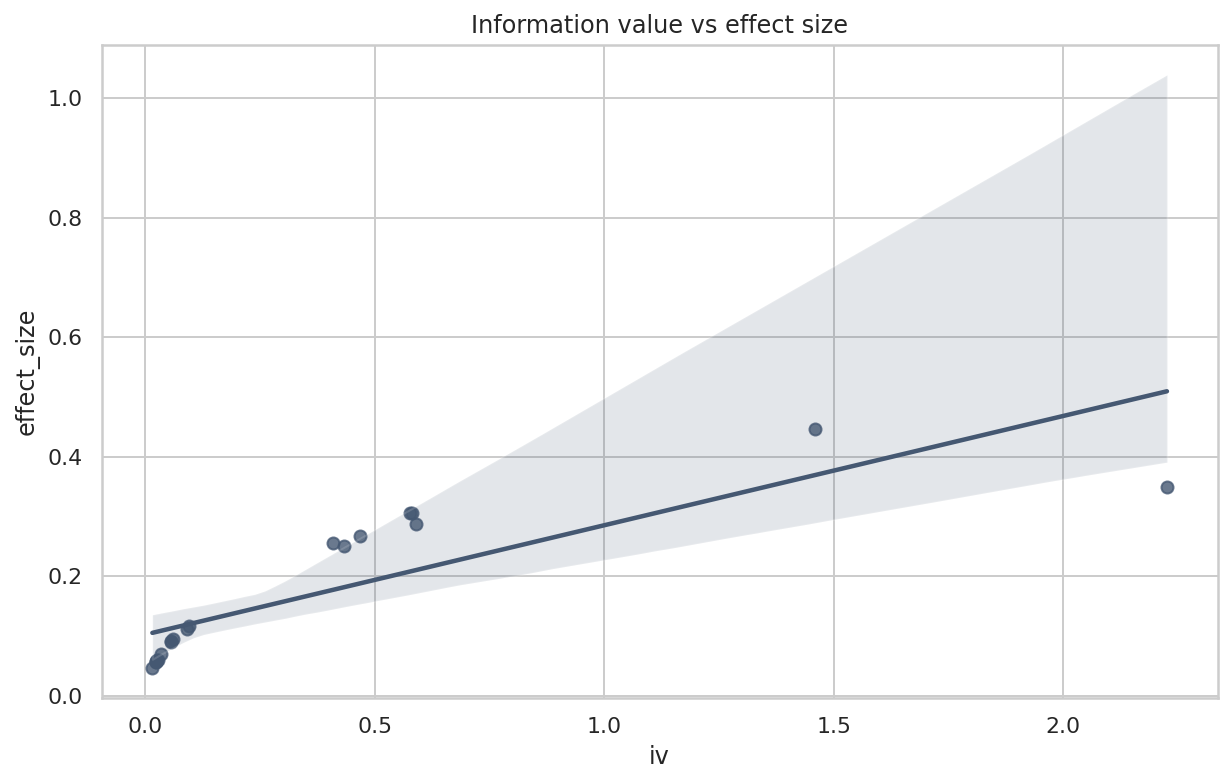

Pearson correlation: 0.83
Spearman correlation: 0.99


In [29]:
df_analysis_sign = df_analysis[df_analysis['p-value']<0.05]

fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='iv', y='effect_size', data=df_analysis_sign, color='#455872')
ax.set_title('Information value vs effect size')
plt.show()

print('Pearson correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size']))
print('Spearman correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size'], method='spearman'))

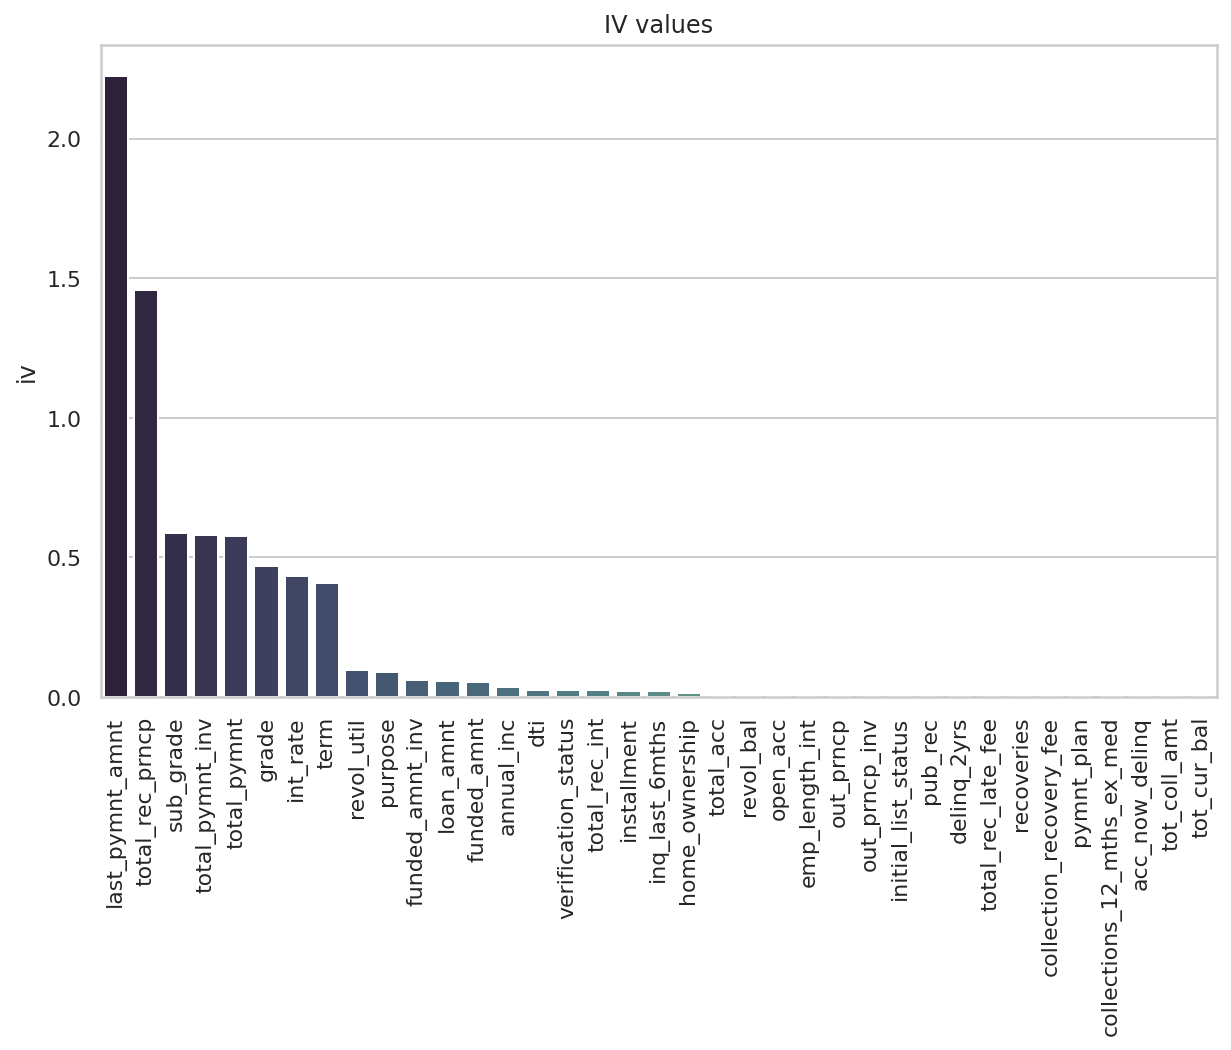

In [30]:
ar.draw_iv(feats, iv)

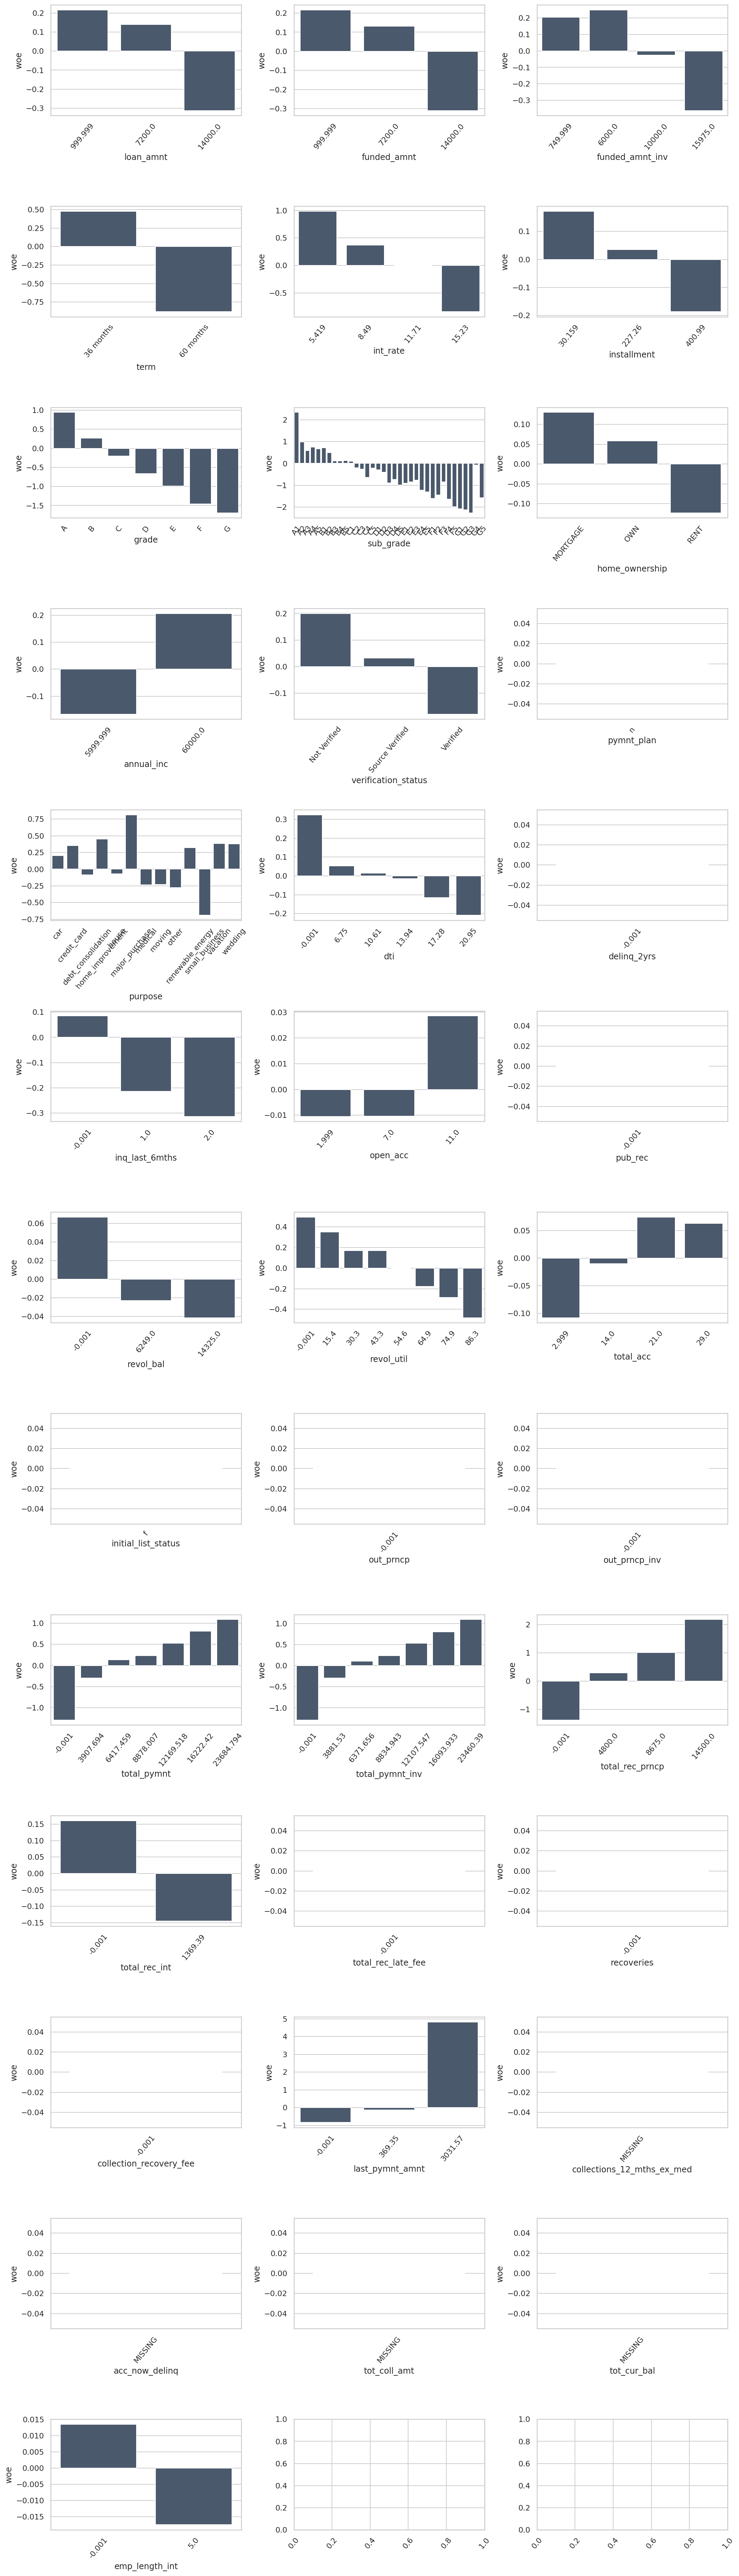

In [31]:
ar.draw_woe_multiplot(feats,iv)

In [32]:
#select fitur
feature_keep = df_analysis[df_analysis["iv"] > 0.01].index
feature_keep

Index(['last_pymnt_amnt', 'total_rec_prncp', 'sub_grade', 'total_pymnt_inv',
       'total_pymnt', 'grade', 'int_rate', 'term', 'revol_util', 'purpose',
       'funded_amnt_inv', 'loan_amnt', 'funded_amnt', 'annual_inc', 'dti',
       'verification_status', 'total_rec_int', 'installment', 'inq_last_6mths',
       'home_ownership'],
      dtype='object')

In [33]:
feature_keep = ['last_pymnt_amnt', 'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt',
       'sub_grade', 'grade', 'int_rate', 'term', 'dti', 'revol_util',
       'annual_inc', 'inq_last_6mths', 'verification_status', 'purpose',
       'total_rec_int', 'funded_amnt', 'loan_amnt', 'funded_amnt_inv',
       'home_ownership', 'installment','good_bad']

In [34]:
#for splitting
df = df[feature_keep]

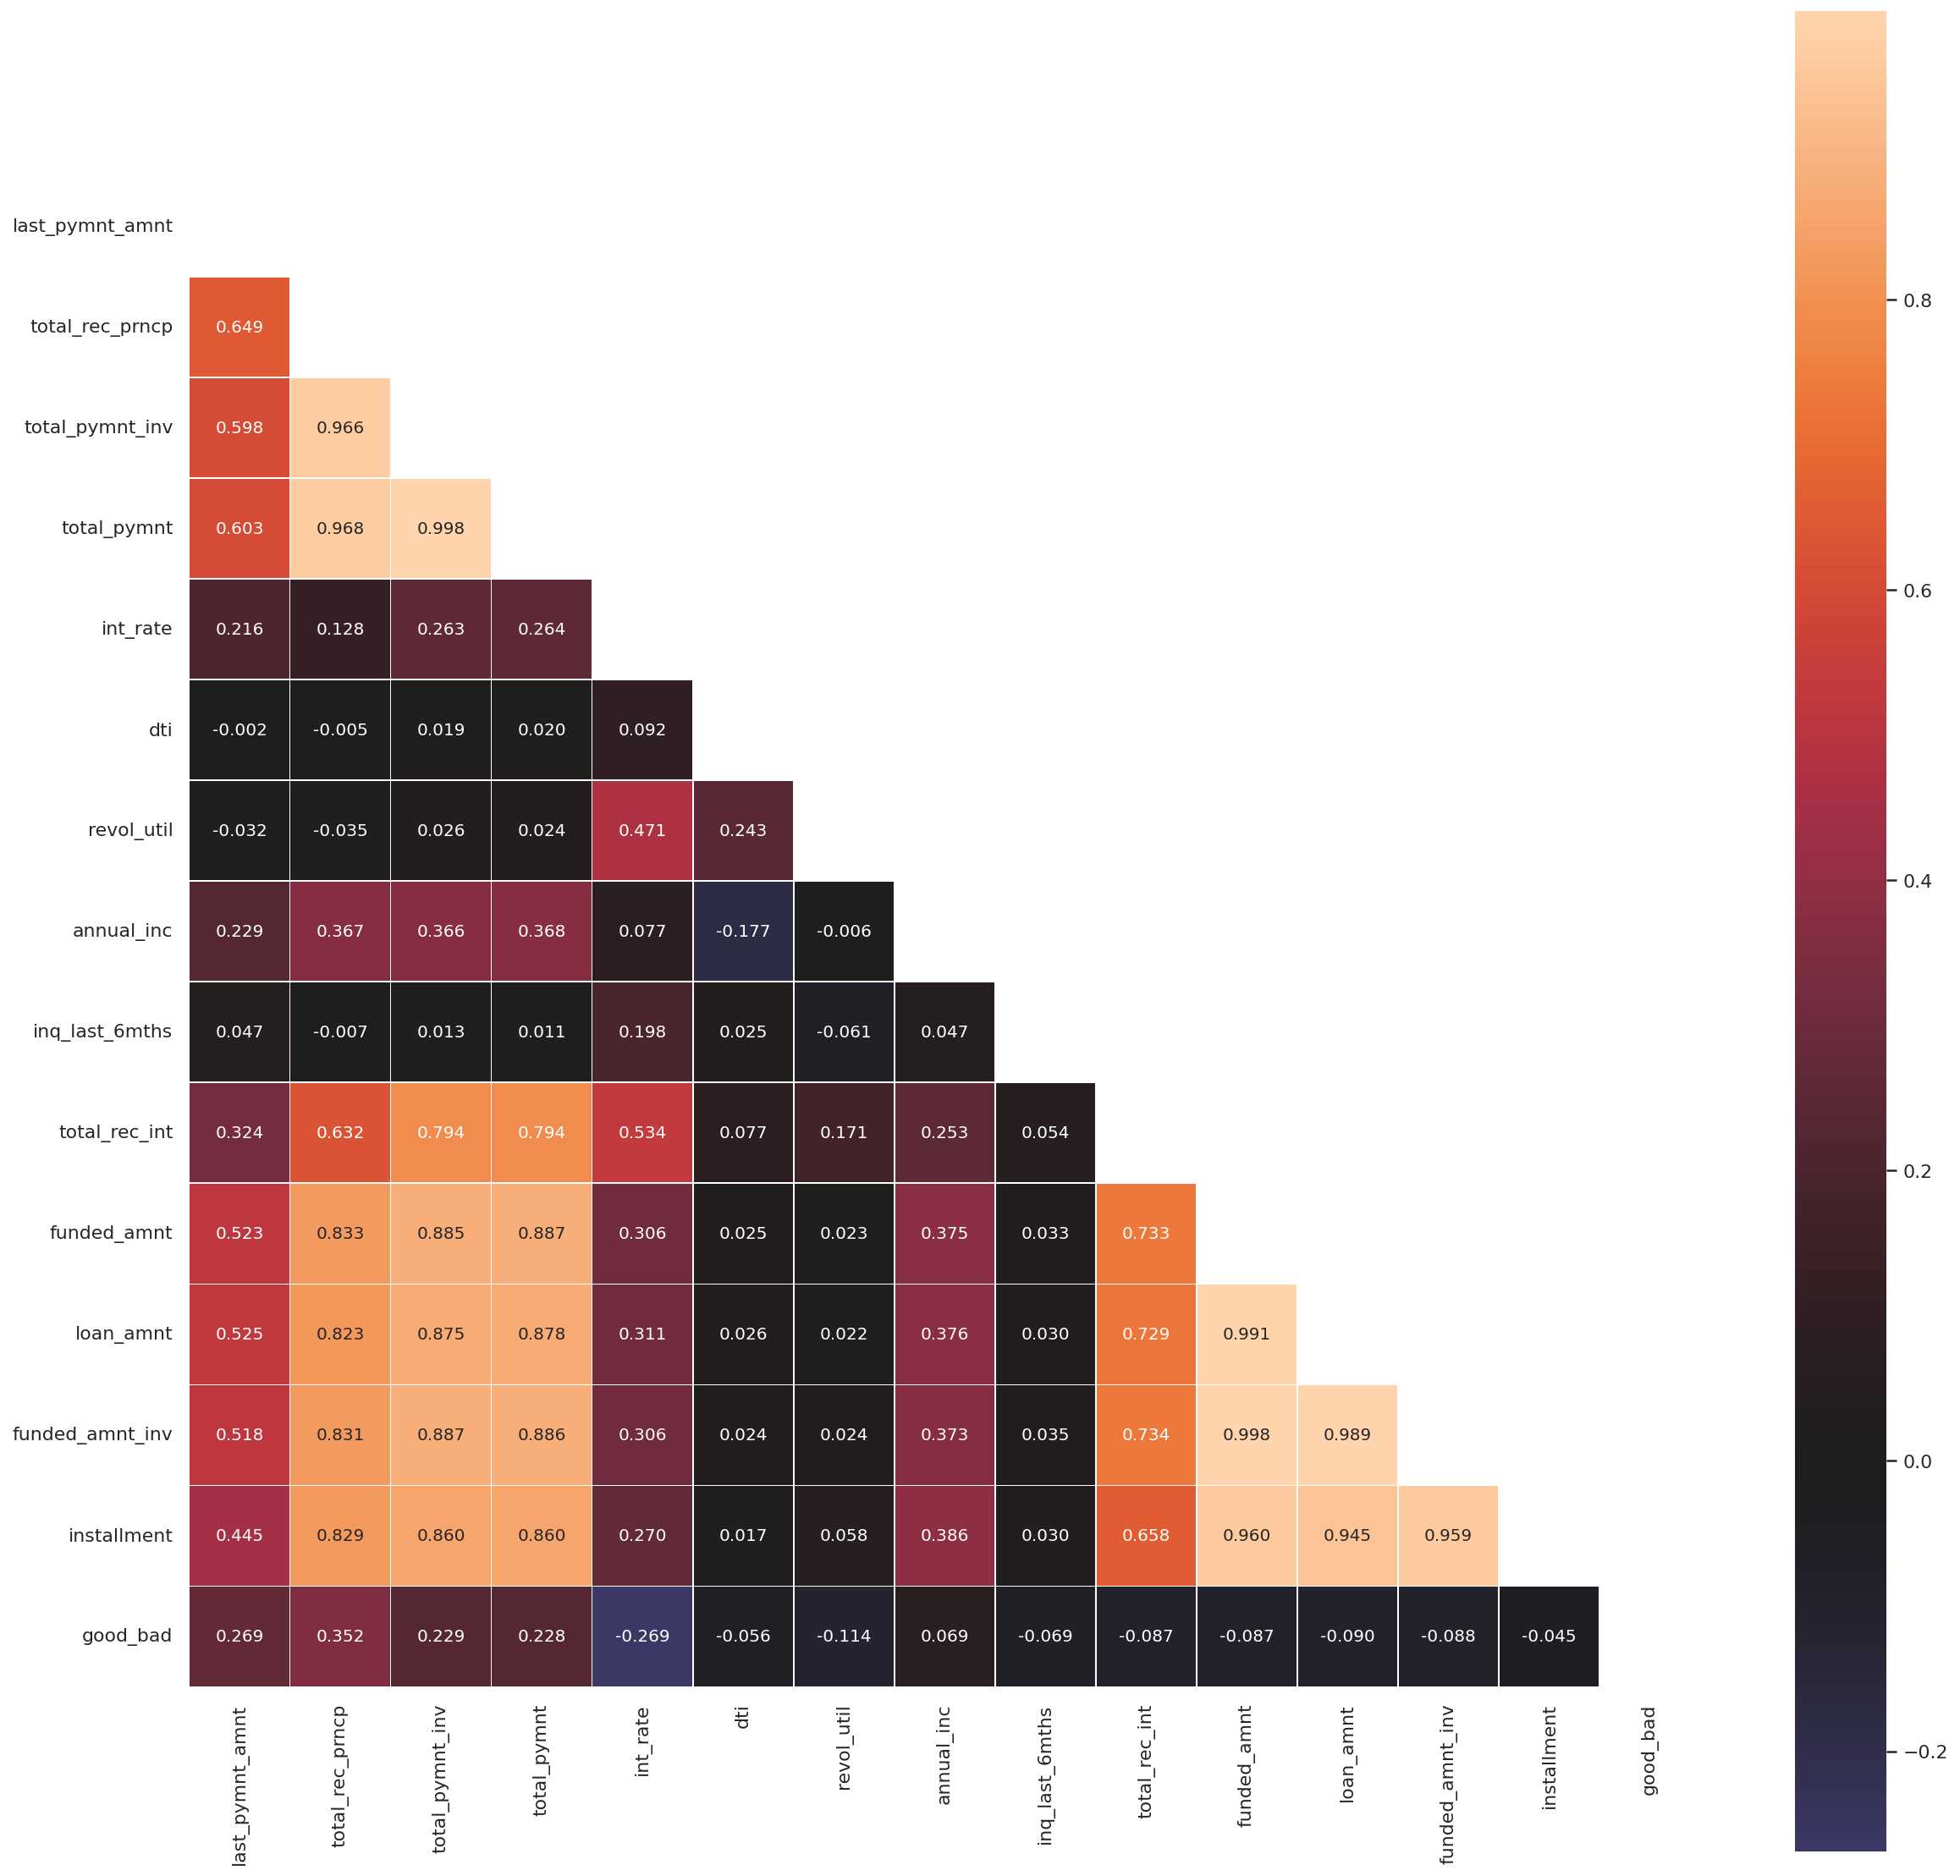

In [35]:
#check correlation
fig = plt.figure(figsize = (20,20))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), center = 0,
           fmt='.3f', square = True,
           annot = True, linewidth = 0.3, mask = matrix)
plt.show()

In [36]:
#make a binning data 
target = "good_bad"
bins = sc.woebin(df,target,monotonic_trend="auto_asc_desc")

[INFO] creating woe binning ...
Binning on 9121 rows and 21 columns in 00:00:12


{'annual_inc': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'funded_amnt': <Figure size 432x288 with 2 Axes>,
 'funded_amnt_inv': <Figure size 432x288 with 2 Axes>,
 'grade': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>,
 'inq_last_6mths': <Figure size 432x288 with 2 Axes>,
 'installment': <Figure size 432x288 with 2 Axes>,
 'int_rate': <Figure size 432x288 with 2 Axes>,
 'last_pymnt_amnt': <Figure size 432x288 with 2 Axes>,
 'loan_amnt': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'revol_util': <Figure size 432x288 with 2 Axes>,
 'sub_grade': <Figure size 432x288 with 2 Axes>,
 'term': <Figure size 432x288 with 2 Axes>,
 'total_pymnt': <Figure size 432x288 with 2 Axes>,
 'total_pymnt_inv': <Figure size 432x288 with 2 Axes>,
 'total_rec_int': <Figure size 432x288 with 2 Axes>,
 'total_rec_prncp': <Figure size 432x288 with 2 Axes>,
 'verification_status': <Figure size 432x

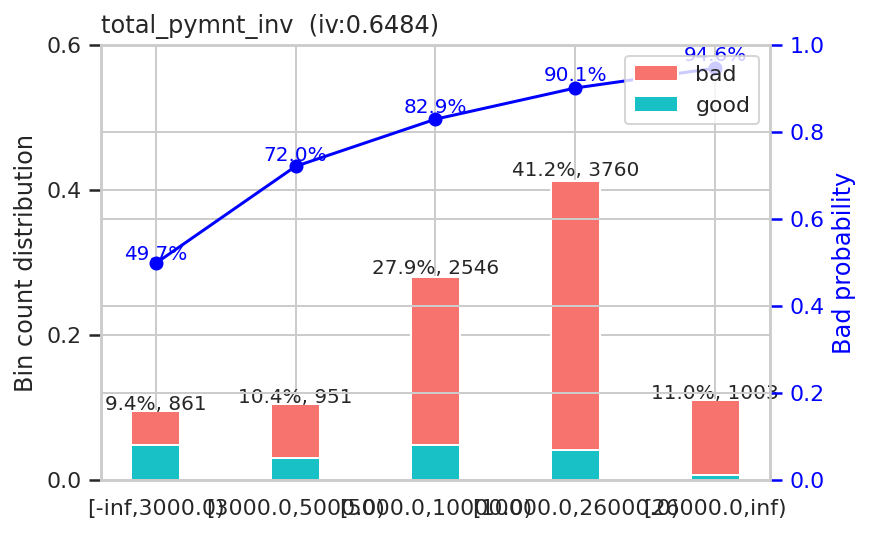

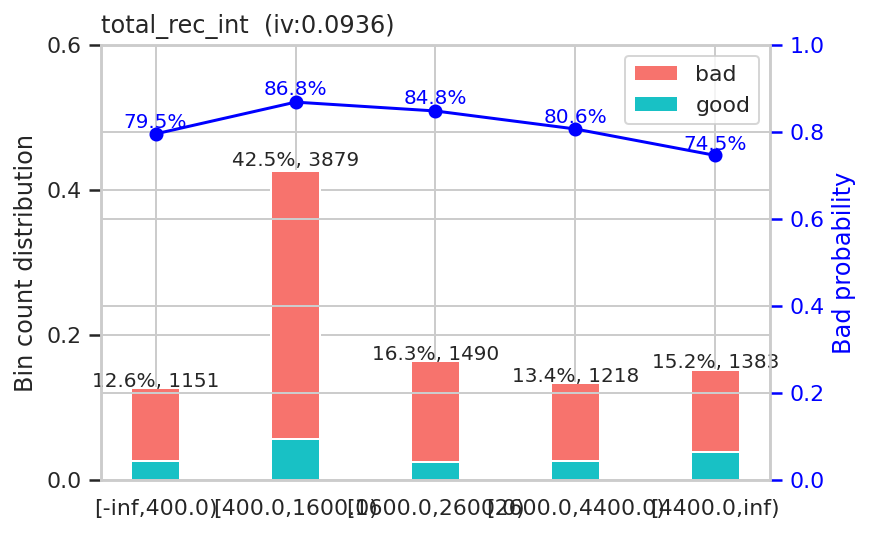

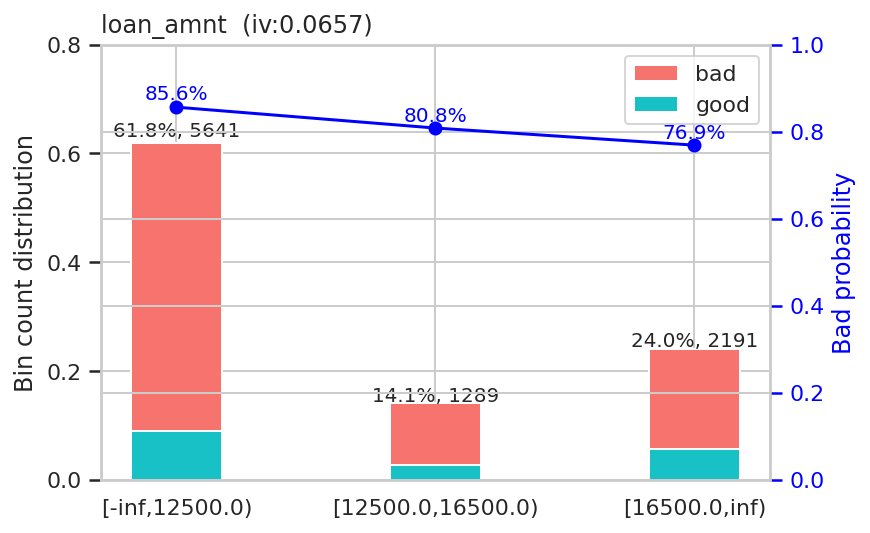

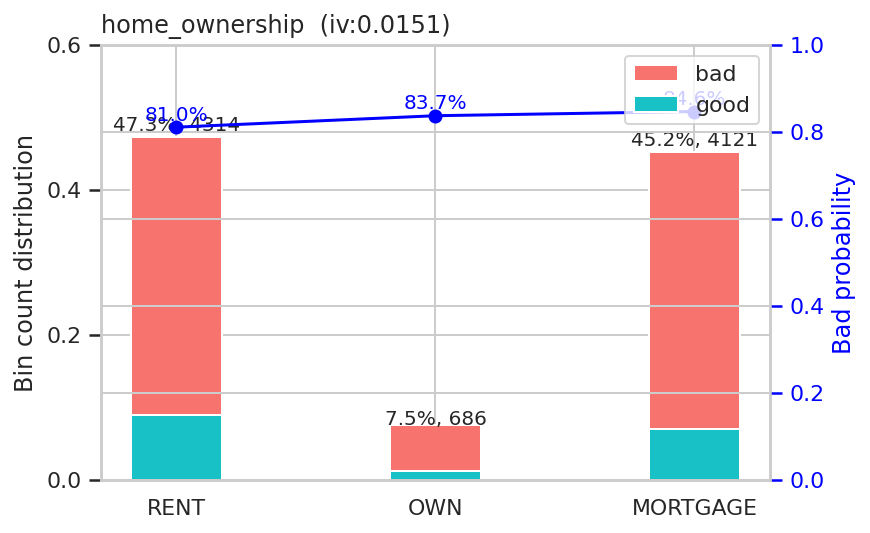

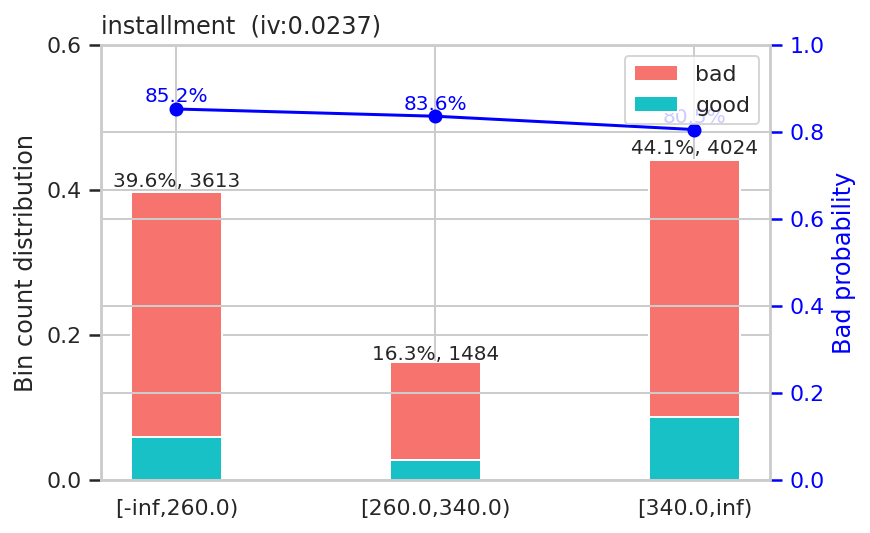

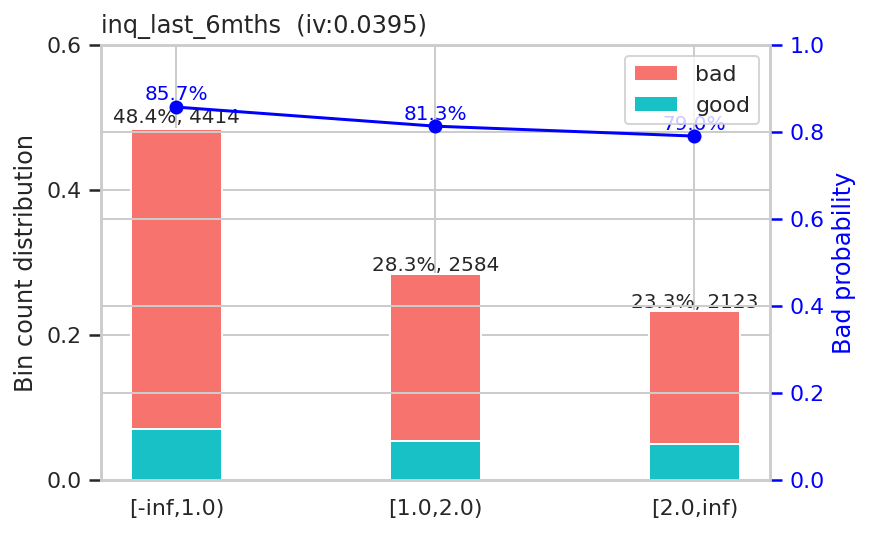

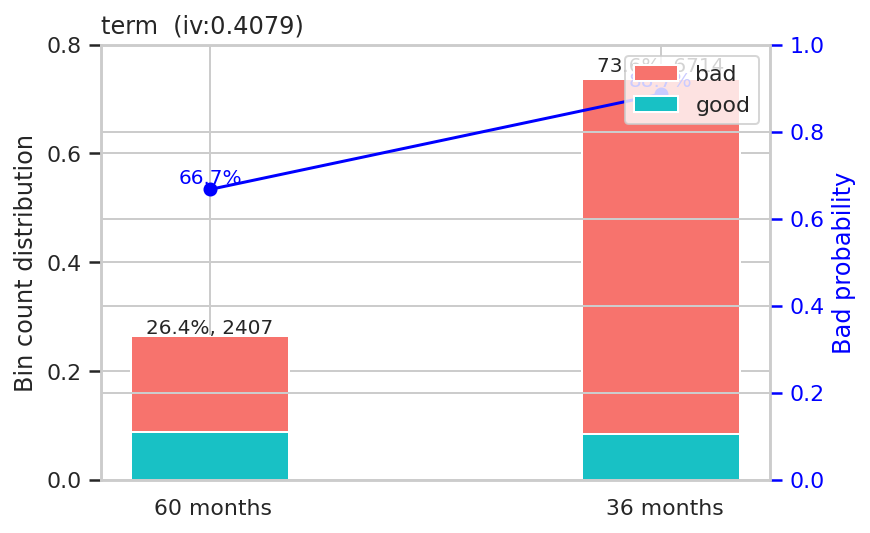

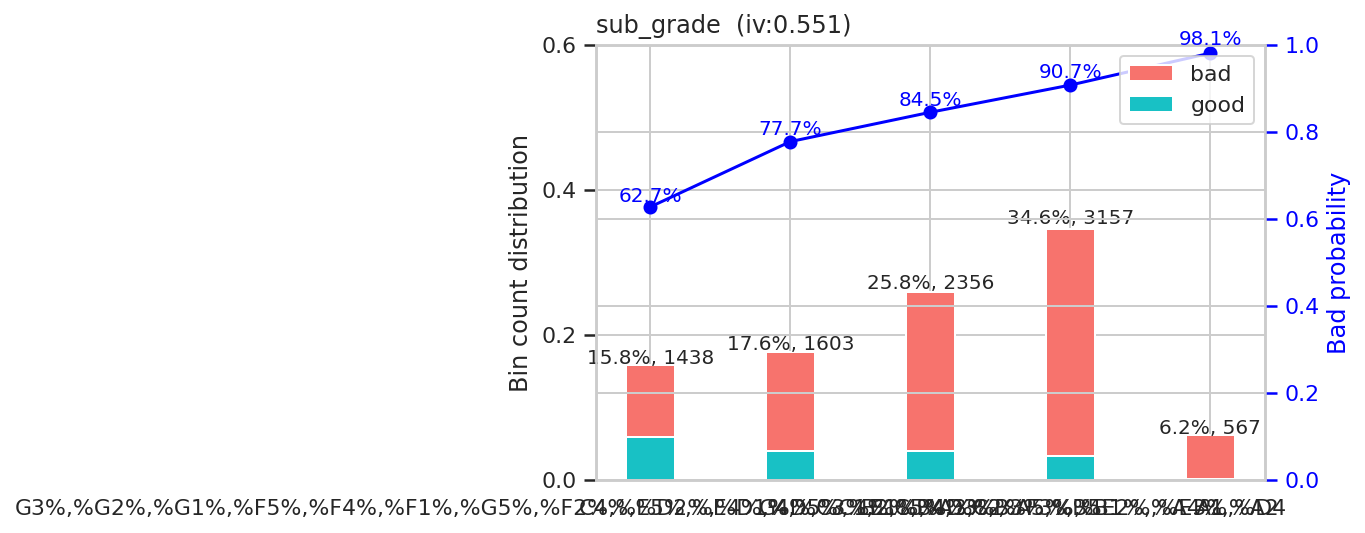

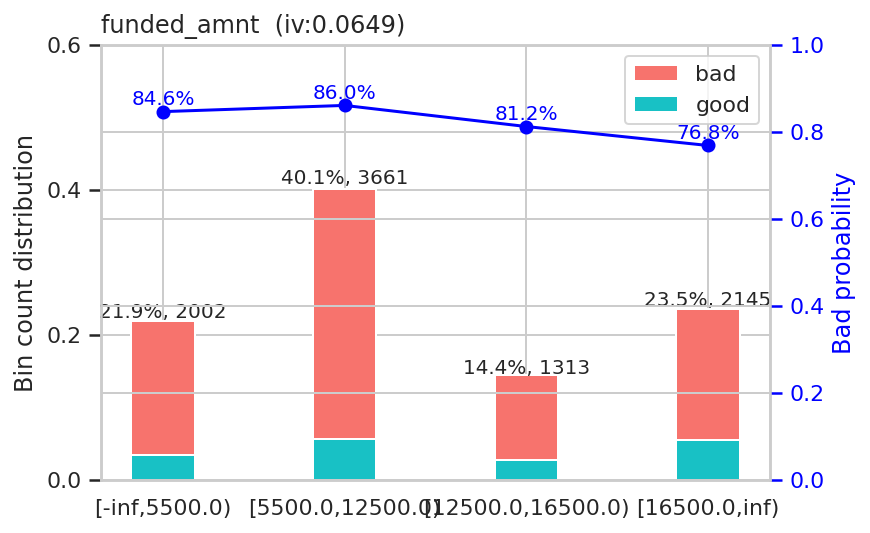

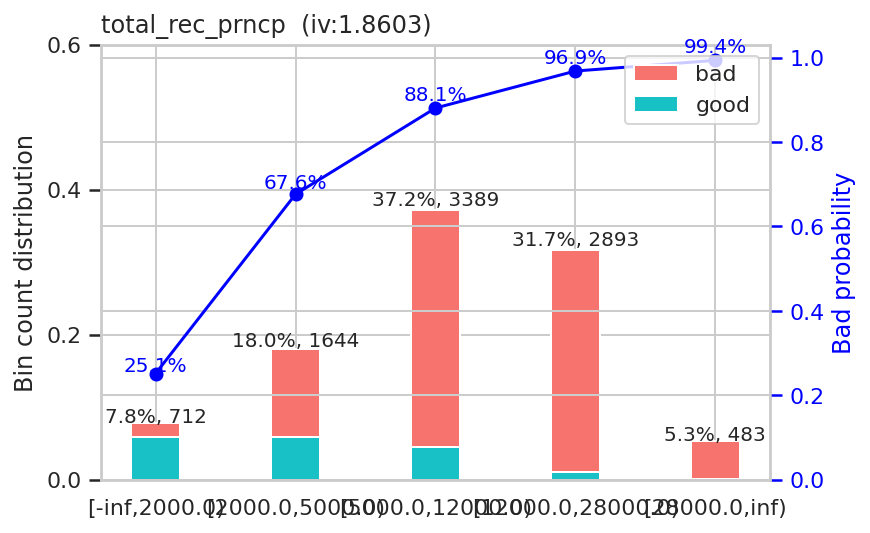

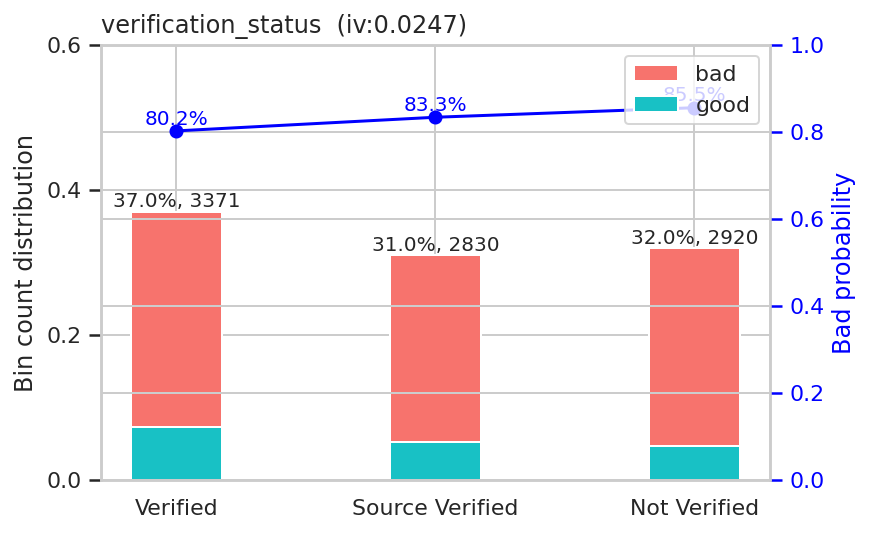

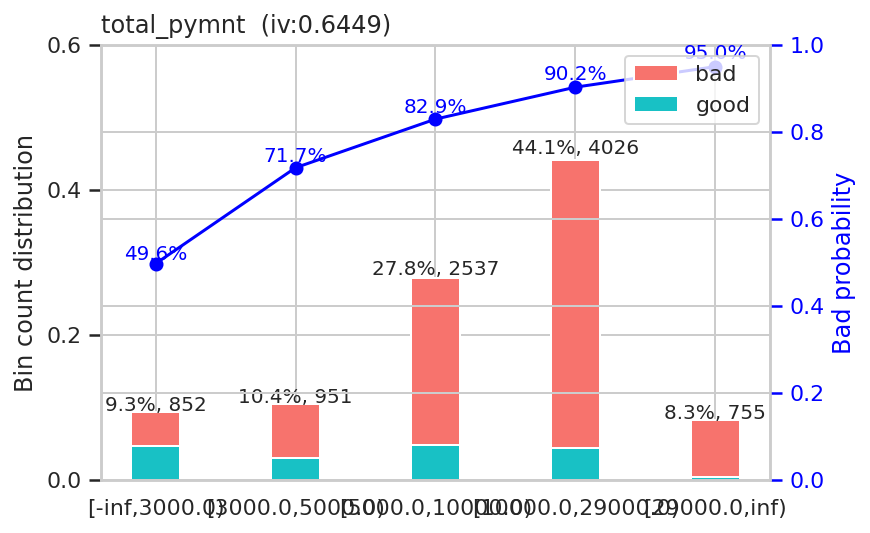

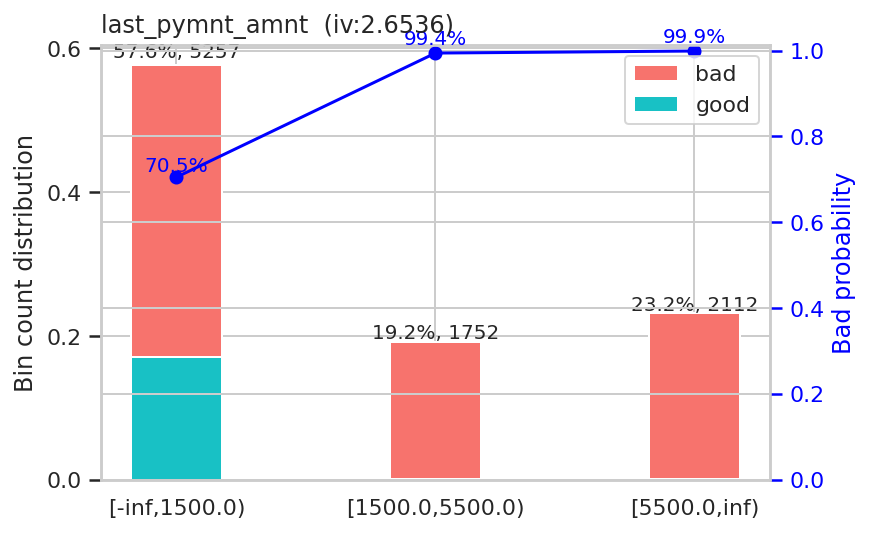

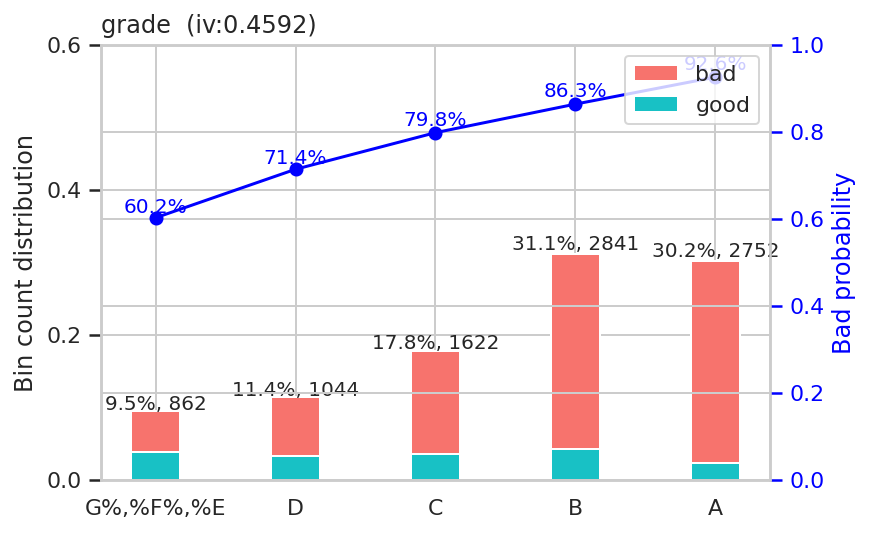

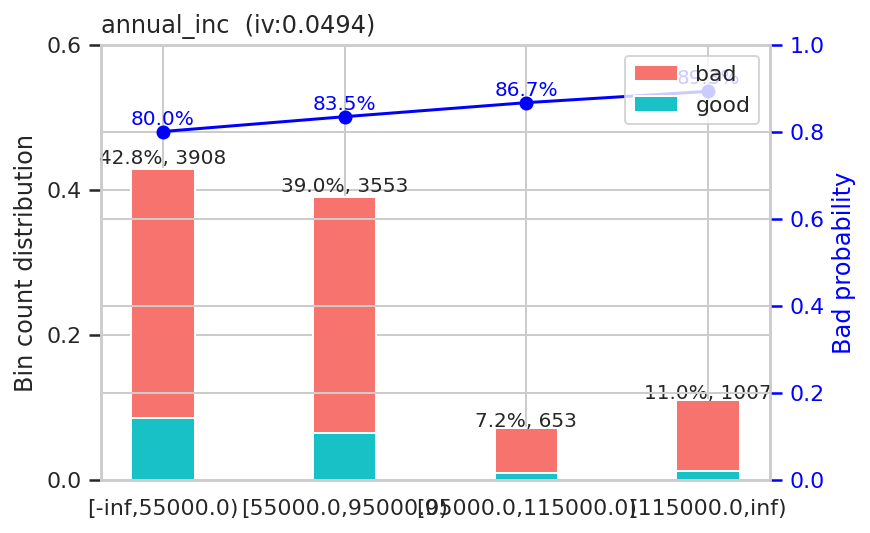

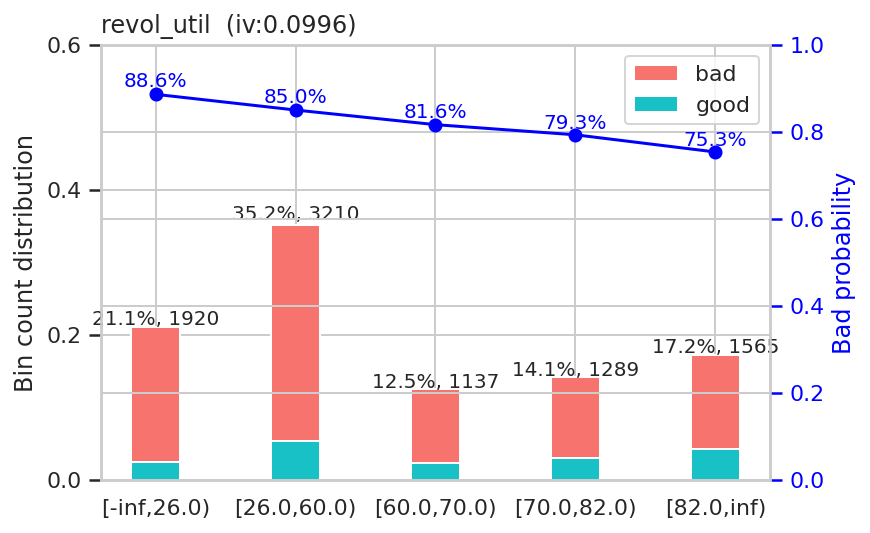

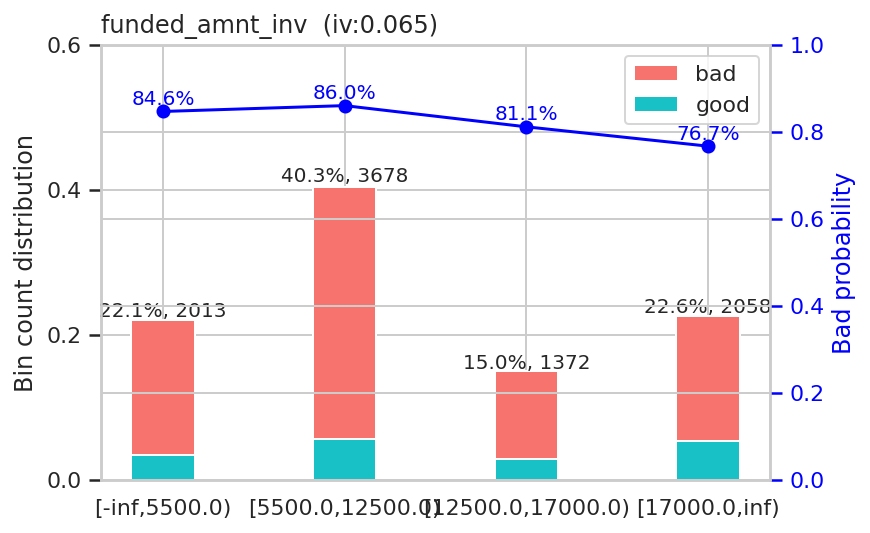

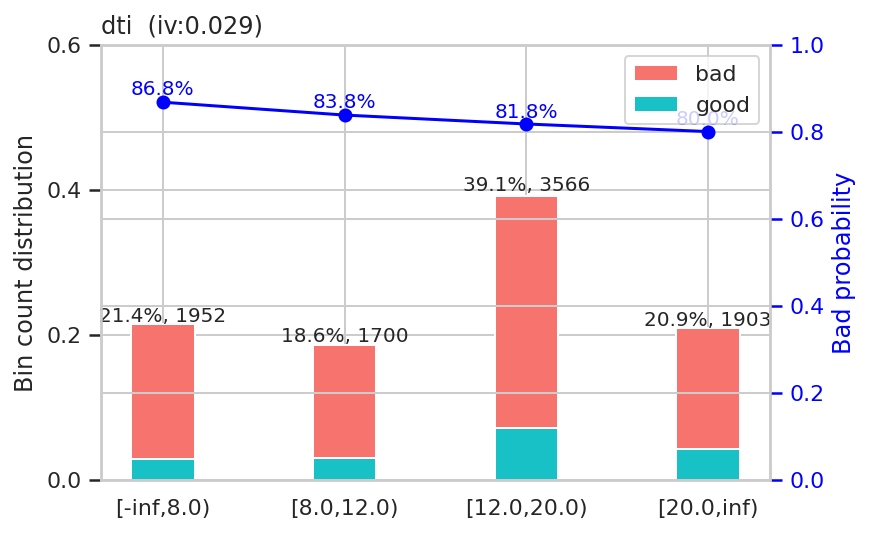

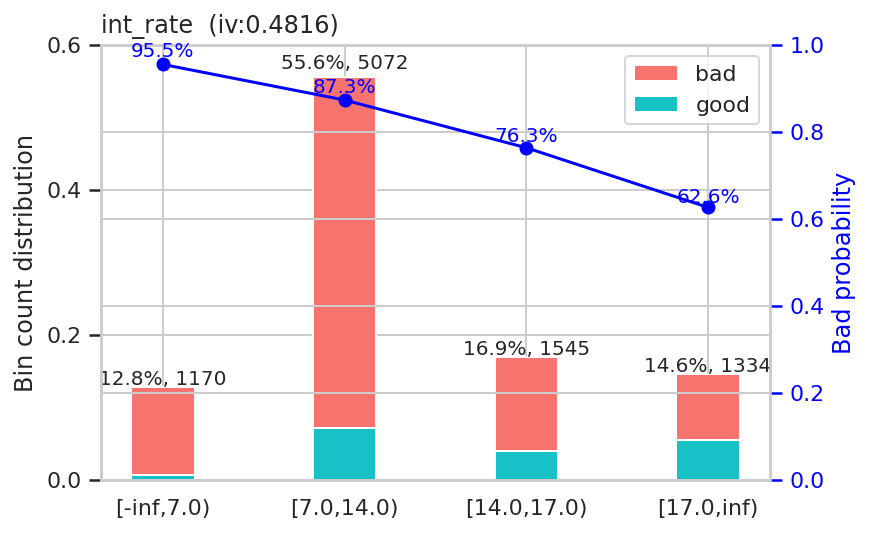

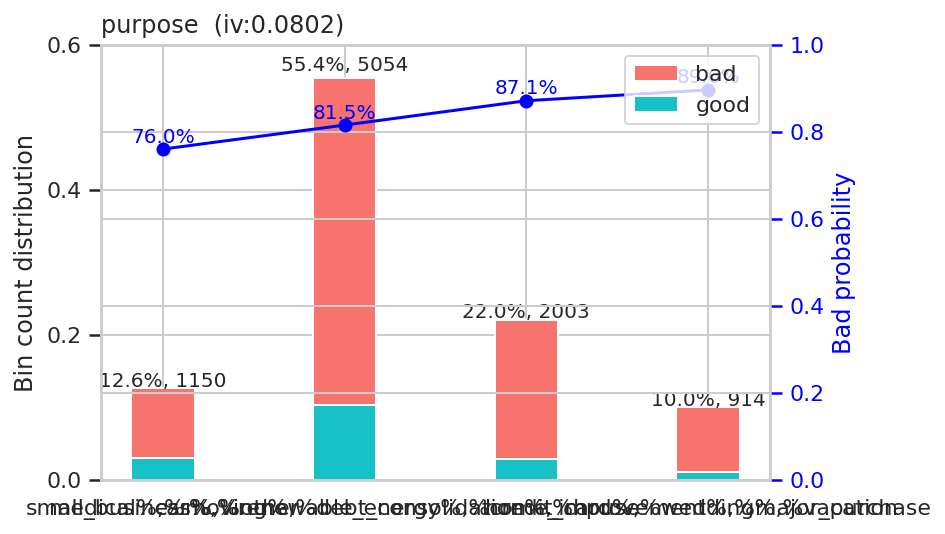

In [37]:
sc.woebin_plot(bins)

In [38]:
def woebin_plot_new(bins, x=None, title=None, show_iv=True):
    
    xs = x
    # bins concat 
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    # good bad distr
    def gb_distr(binx):
        binx['good_distr'] = binx['good']/sum(binx['count'])
        binx['bad_distr'] = binx['bad']/sum(binx['count'])
        return binx
    bins = bins.groupby('variable').apply(gb_distr)
    # x variable names
    if xs is None: xs = bins['variable'].unique()
    # plot export
    plotlist = {}
    for i in xs:
        binx = bins[bins['variable'] == i].reset_index()
        plotlist[i] = plot_bin_new(binx, title, show_iv)
    return plotlist

In [39]:
def plot_bin_new(binx, title, show_iv):
  
    # y_right_max
    y_right_max = np.ceil(binx['badprob'].max()*10)
    if y_right_max % 2 == 1: y_right_max=y_right_max+1
    if y_right_max - binx['badprob'].max()*10 <= 0.3: y_right_max = y_right_max+2
    y_right_max = y_right_max/10
    if y_right_max>1 or y_right_max<=0 or y_right_max is np.nan or y_right_max is None: y_right_max=1
    ## y_left_max
    y_left_max = np.ceil(binx['count_distr'].max()*10)/10
    if y_left_max>1 or y_left_max<=0 or y_left_max is np.nan or y_left_max is None: y_left_max=1
    # title
    title_string = binx.loc[0,'variable']+"  (iv:"+str(round(binx.loc[0,'total_iv'],4))+")" if show_iv else binx.loc[0,'variable']
    title_string = title+'-'+title_string if title is not None else title_string
    # param
    ind = np.arange(len(binx.index))    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence
    ###### plot ###### 
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    # ax1
    p1 = ax1.bar(ind, binx['good_distr'], width, color=(24/254, 192/254, 196/254))
    p2 = ax1.bar(ind, binx['bad_distr'], width, bottom=binx['good_distr'], color=(246/254, 115/254, 109/254))
    for i in ind:
        ax1.text(i, binx.loc[i,'count_distr']*1.02, str(round(binx.loc[i,'count_distr']*100,1))+'%, '+str(binx.loc[i,'count']), ha='center')
    # ax2
    ax2.plot(ind, binx['badprob'], marker='o', color='blue')
    for i in ind:
        ax2.text(i, binx.loc[i,'badprob']*1.02, str(round(binx.loc[i,'badprob'], 2)) , color='blue', ha='center')
    # settings
    ax1.set_ylabel('Bin count distribution')
    ax2.set_ylabel('Bad Probability', color='blue')
    ax1.set_yticks(np.arange(0, y_left_max+0.2, 0.2))
    ax2.set_yticks(np.arange(0, y_right_max+0.2, 0.2))
    ax2.tick_params(axis='y', colors='blue')
    ax1.tick_params(axis='x', rotation=45)
    plt.xticks(ind, binx['bin'])
#     plt.xticks(rotation = 45)
#     plt.figure(figsize=(12,6))
    plt.rcParams['font.size'] = '14'
    plt.title(title_string, loc='left')
    plt.legend((p2[0], p1[0]), ('bad', 'good'), loc='upper right')
    # show plot 
    # plt.show()
    return fig

{'annual_inc': <Figure size 864x432 with 2 Axes>,
 'dti': <Figure size 864x432 with 2 Axes>,
 'funded_amnt': <Figure size 864x432 with 2 Axes>,
 'funded_amnt_inv': <Figure size 864x432 with 2 Axes>,
 'grade': <Figure size 864x432 with 2 Axes>,
 'home_ownership': <Figure size 864x432 with 2 Axes>,
 'inq_last_6mths': <Figure size 864x432 with 2 Axes>,
 'installment': <Figure size 864x432 with 2 Axes>,
 'int_rate': <Figure size 864x432 with 2 Axes>,
 'last_pymnt_amnt': <Figure size 864x432 with 2 Axes>,
 'loan_amnt': <Figure size 864x432 with 2 Axes>,
 'purpose': <Figure size 864x432 with 2 Axes>,
 'revol_util': <Figure size 864x432 with 2 Axes>,
 'sub_grade': <Figure size 864x432 with 2 Axes>,
 'term': <Figure size 864x432 with 2 Axes>,
 'total_pymnt': <Figure size 864x432 with 2 Axes>,
 'total_pymnt_inv': <Figure size 864x432 with 2 Axes>,
 'total_rec_int': <Figure size 864x432 with 2 Axes>,
 'total_rec_prncp': <Figure size 864x432 with 2 Axes>,
 'verification_status': <Figure size 864x

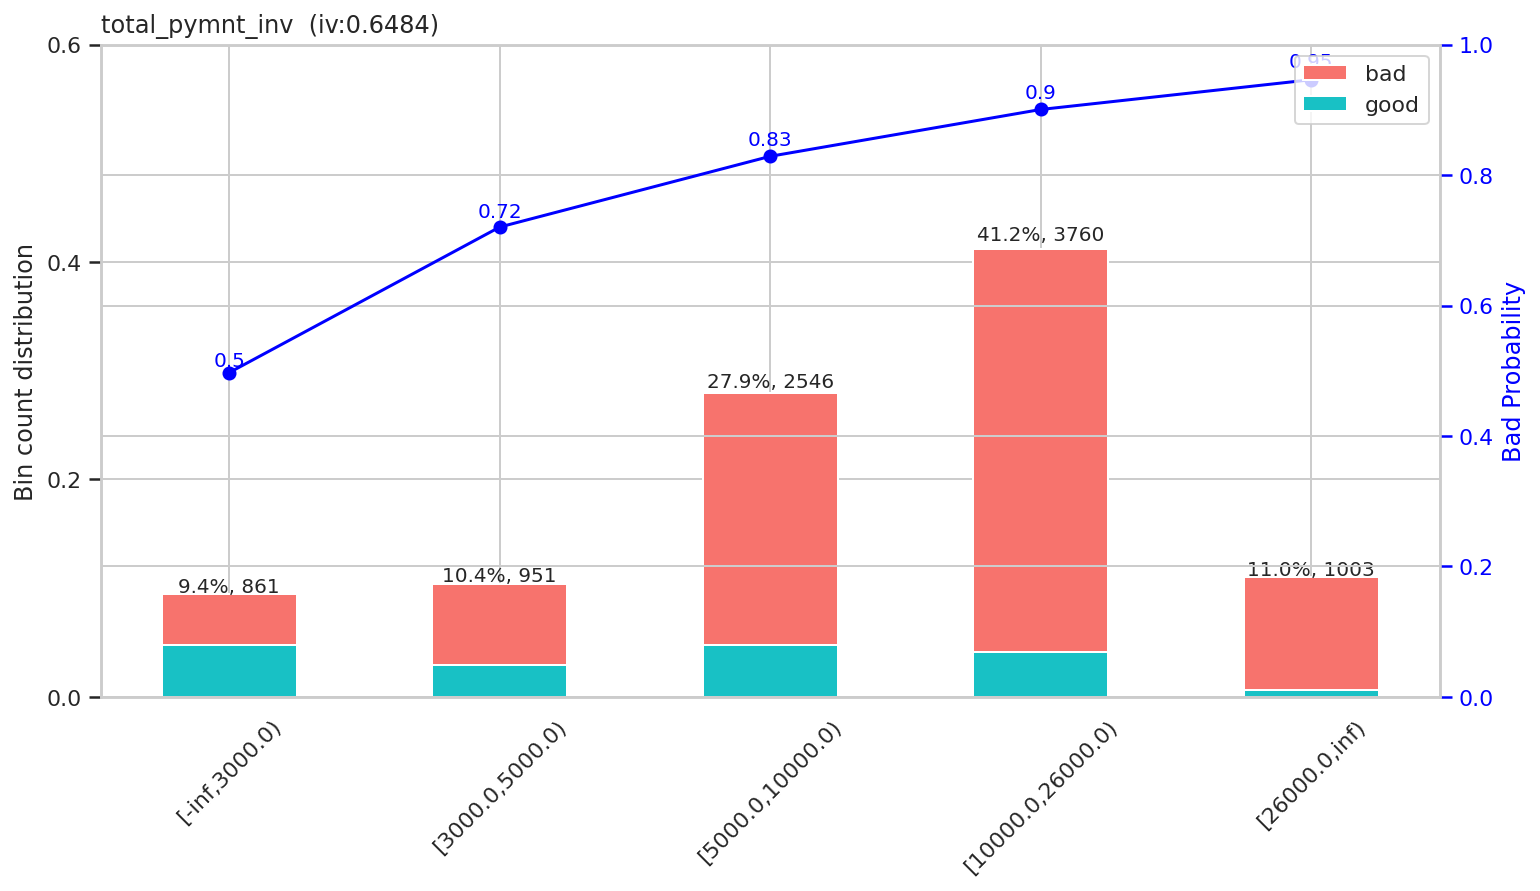

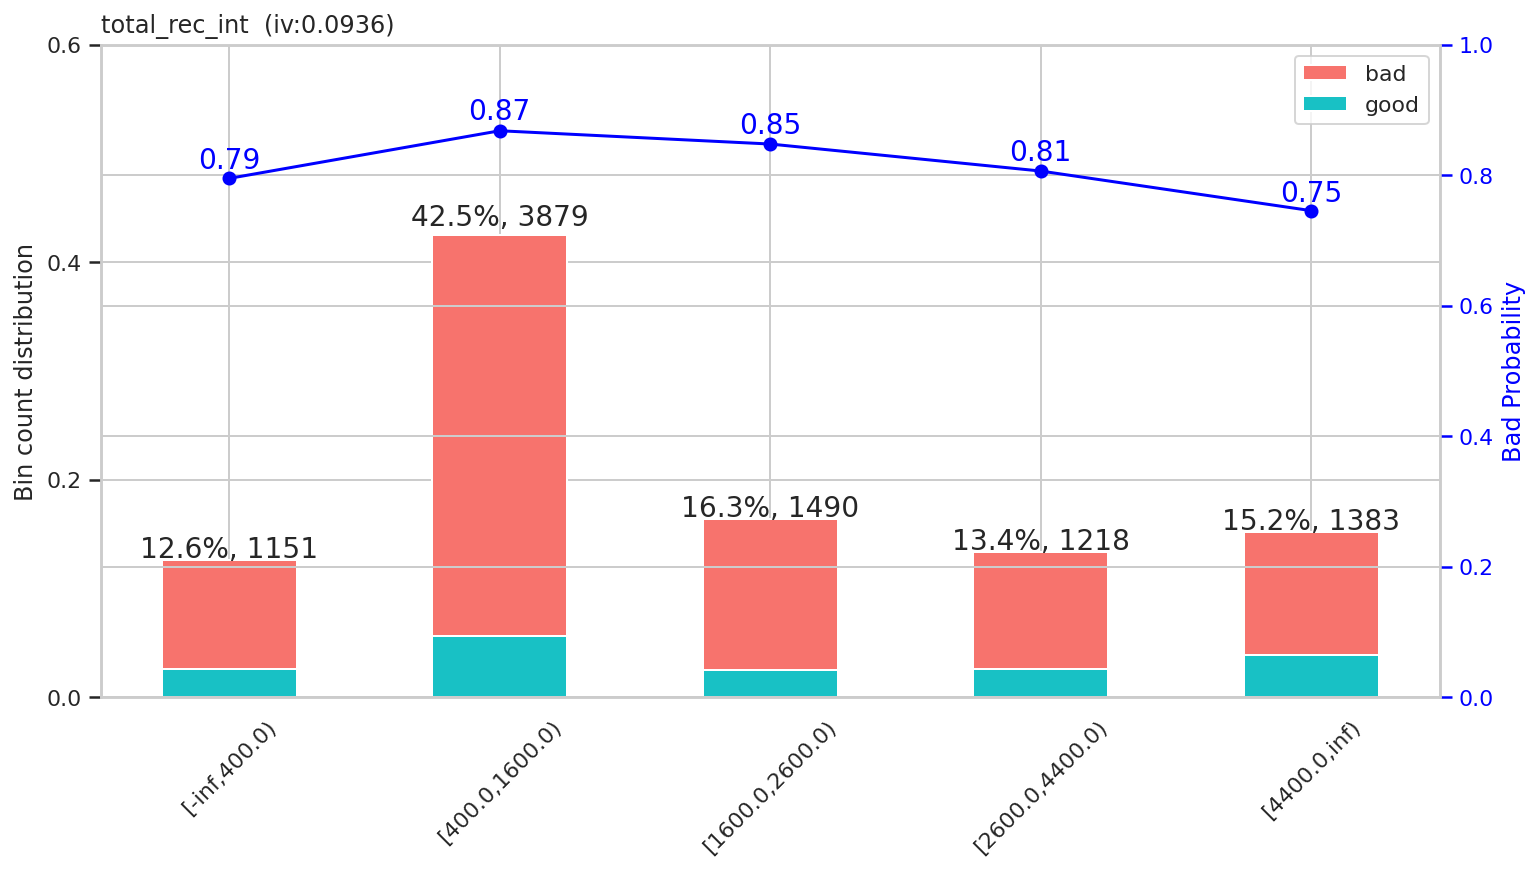

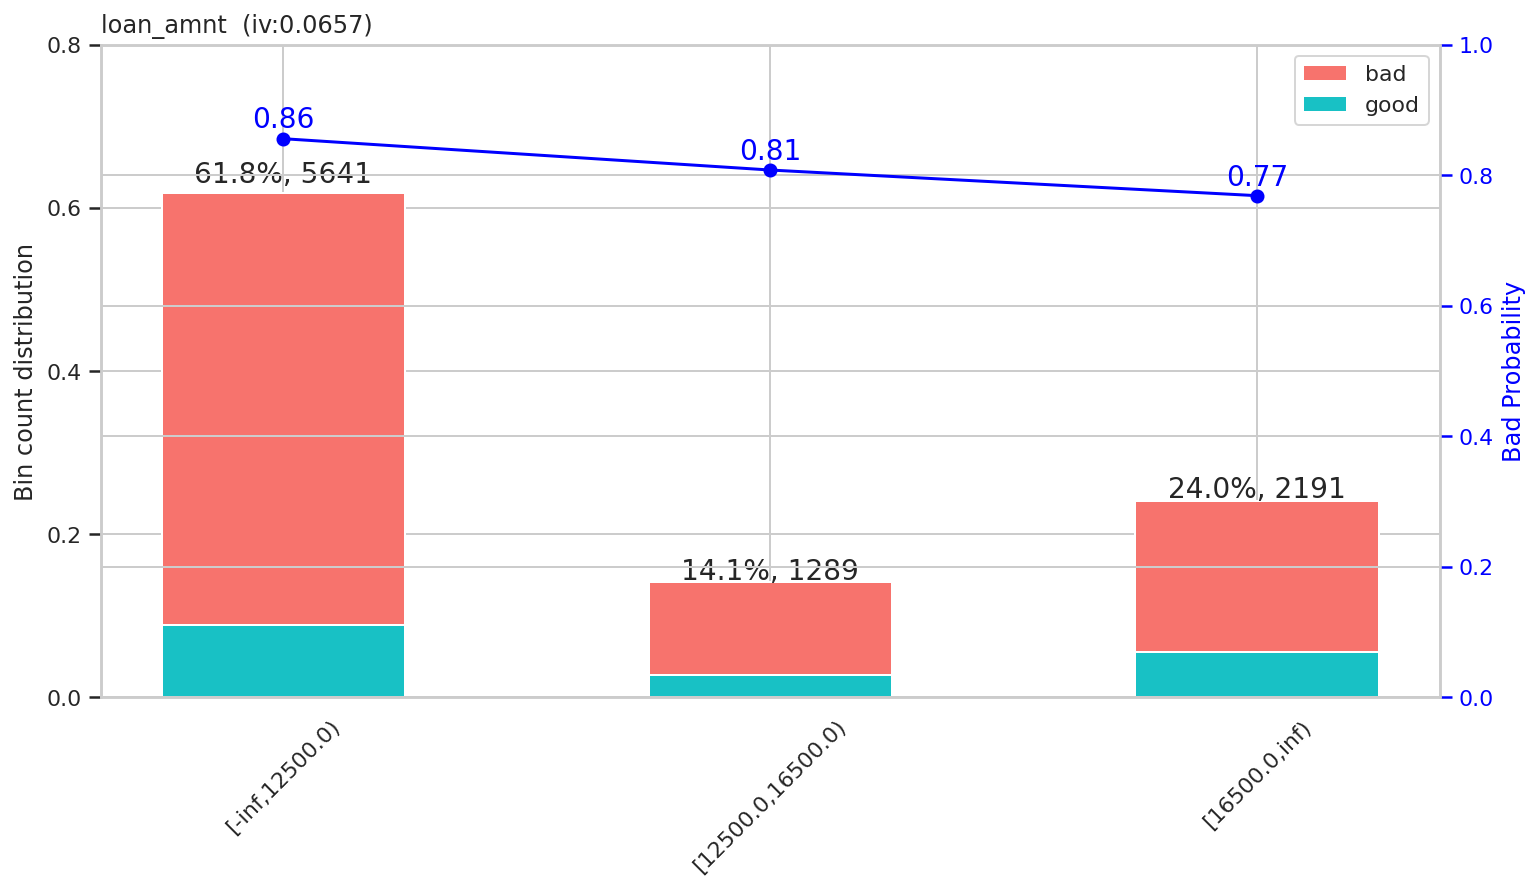

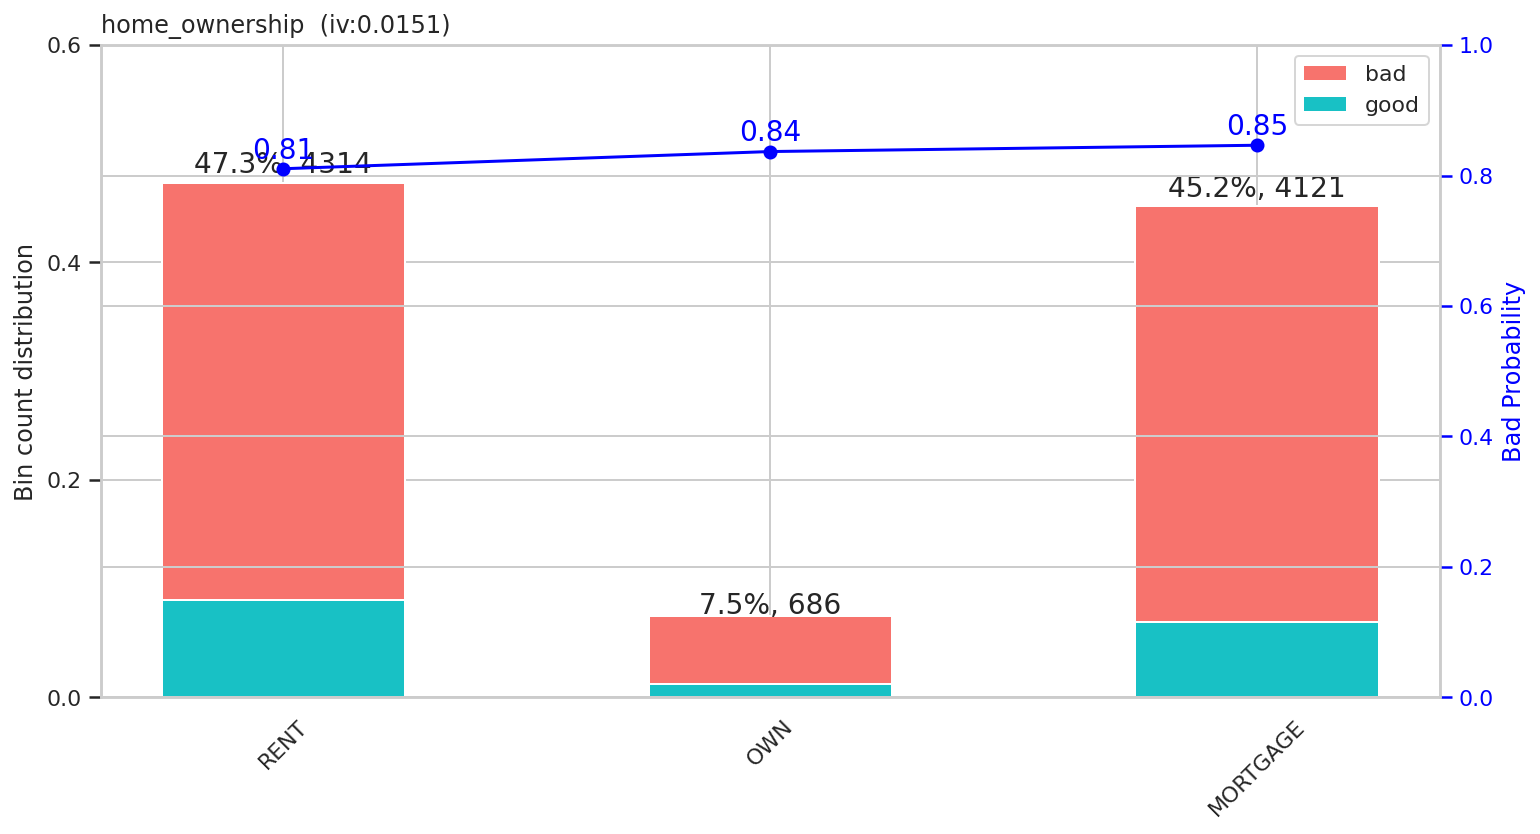

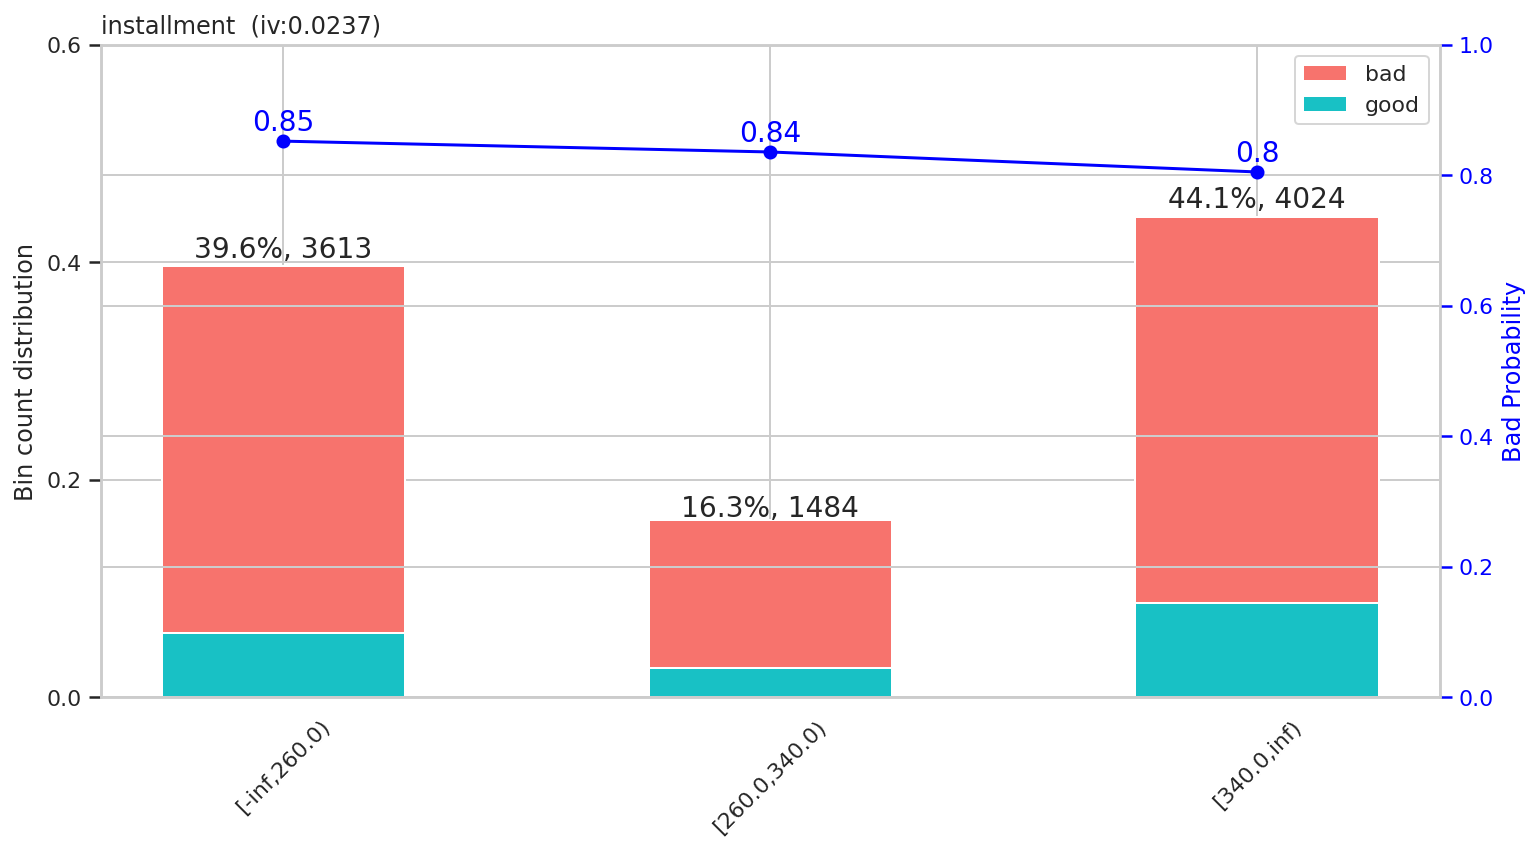

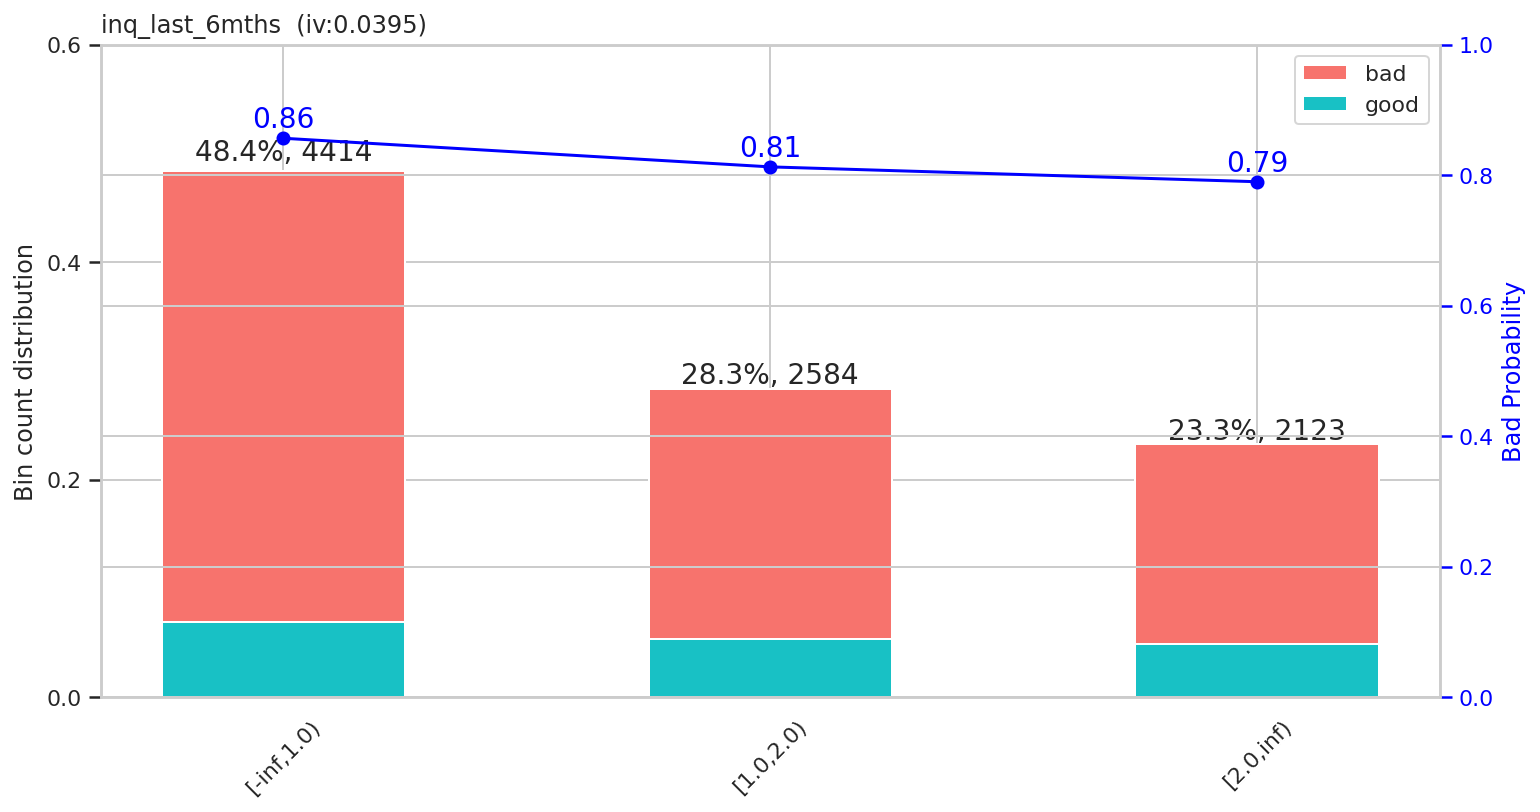

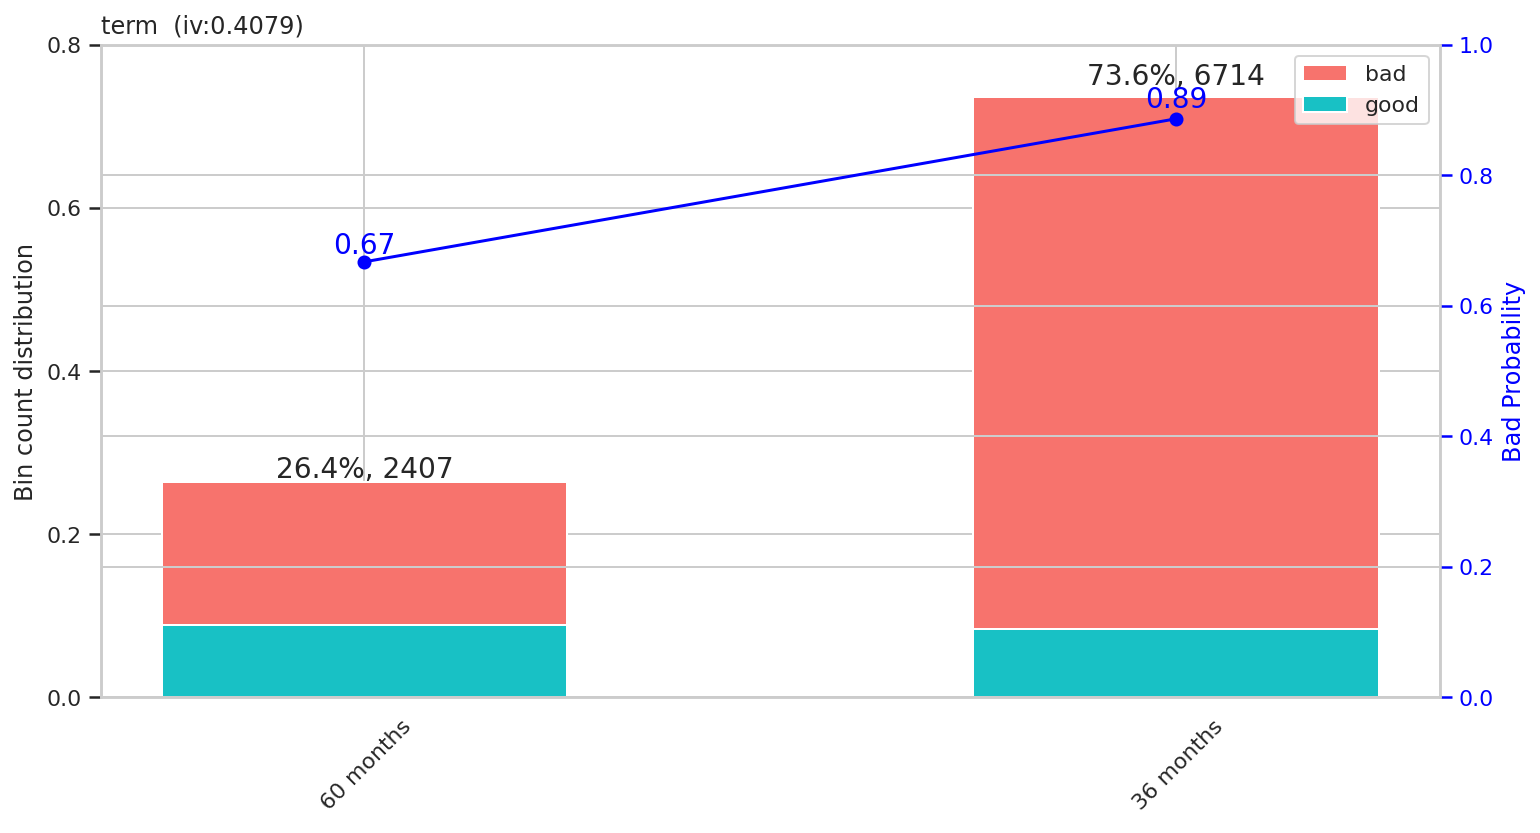

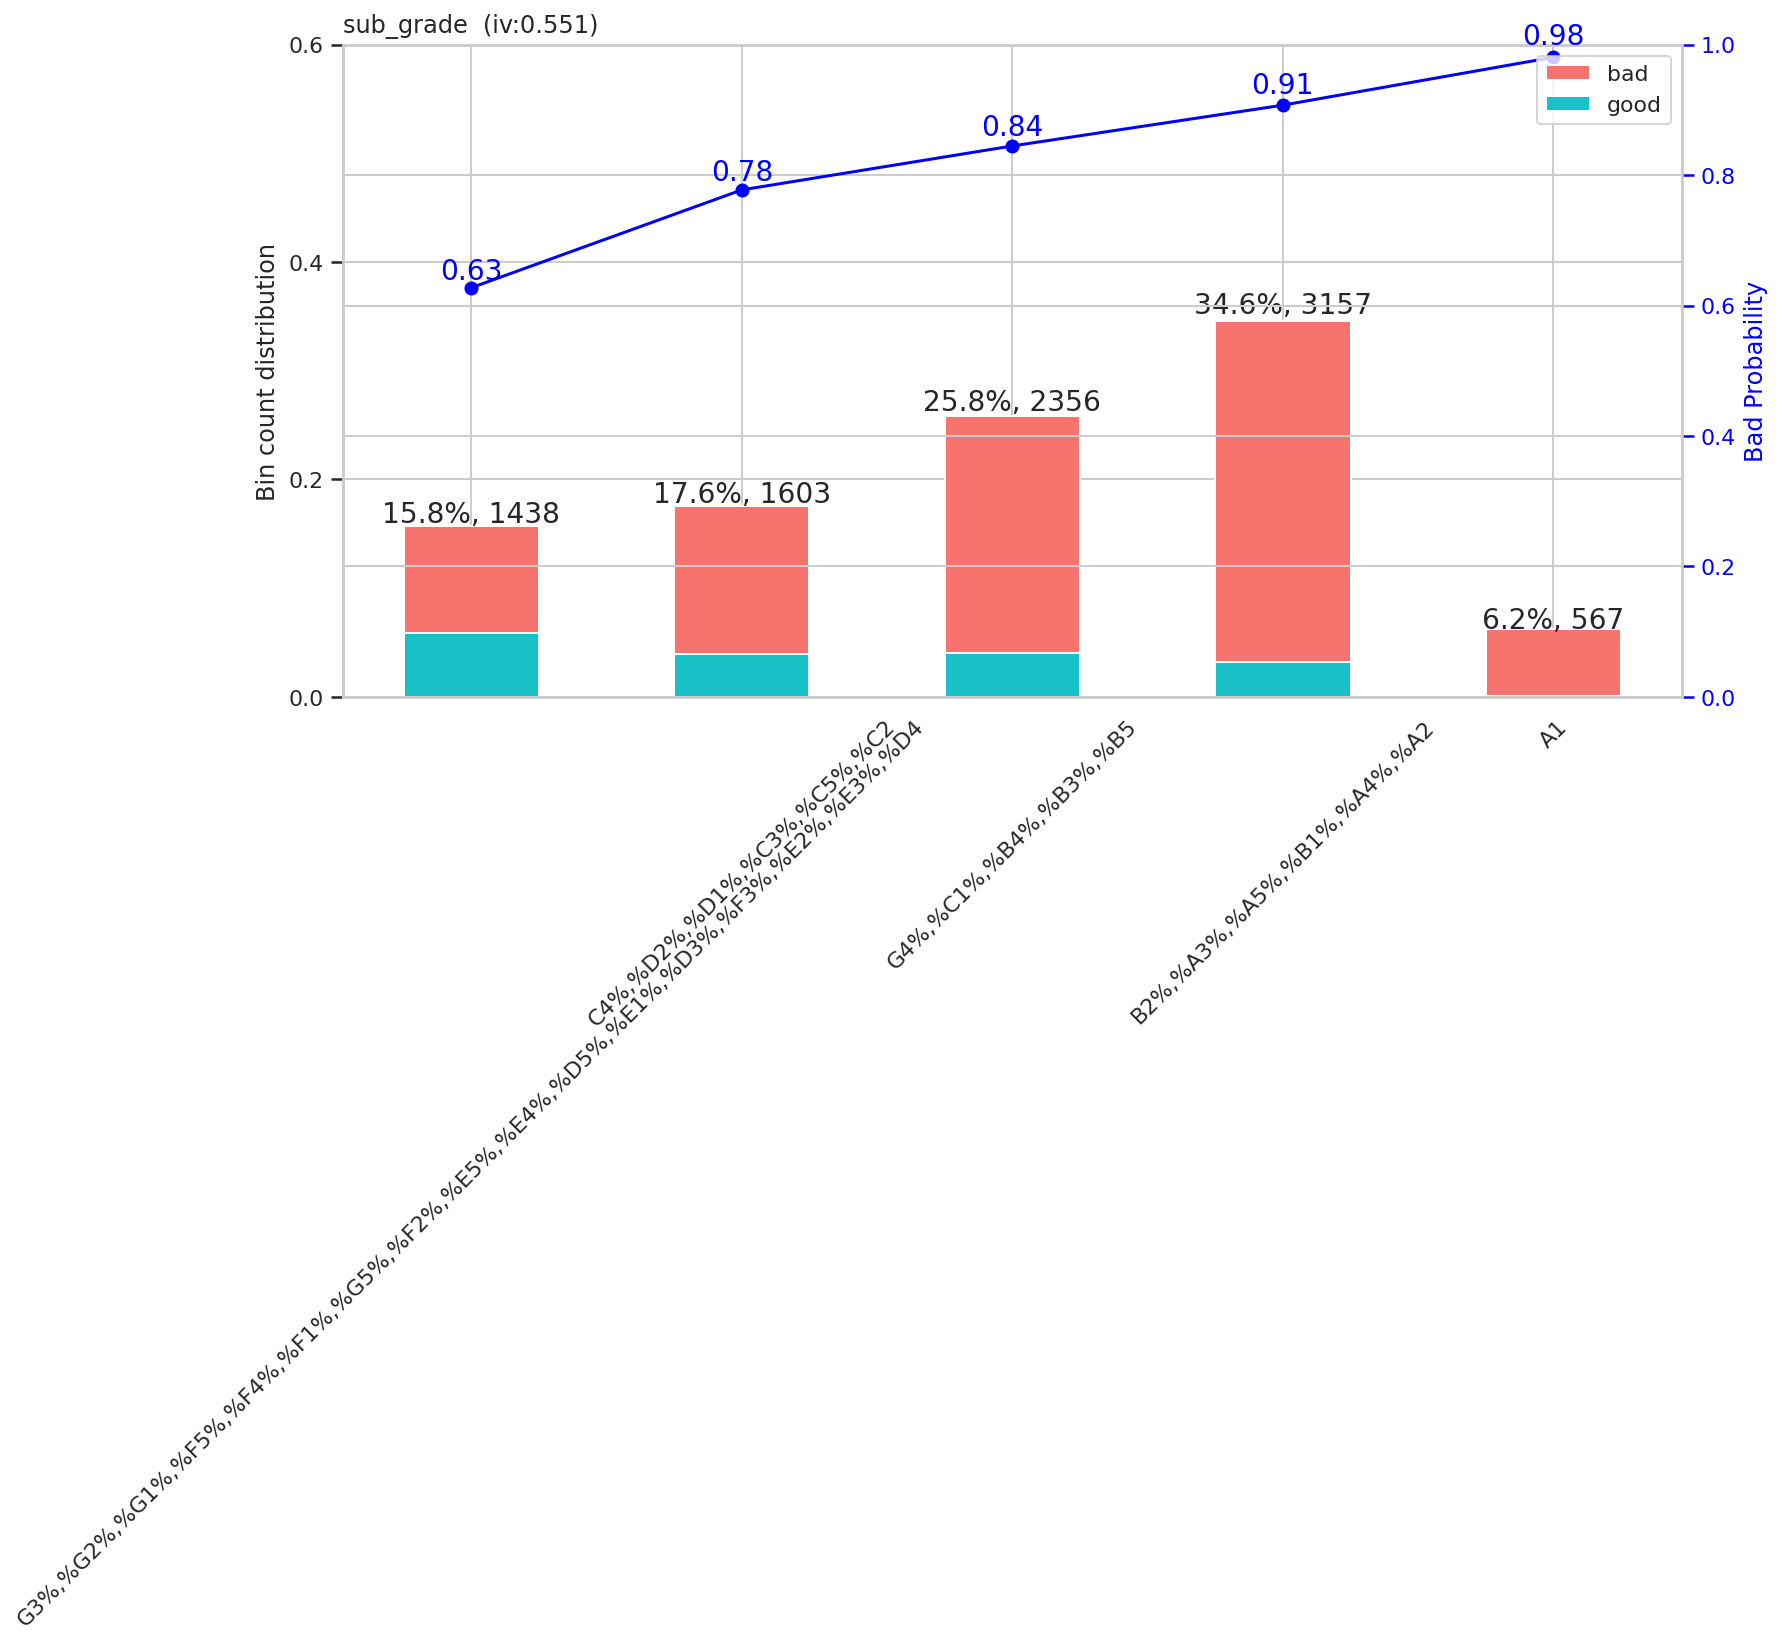

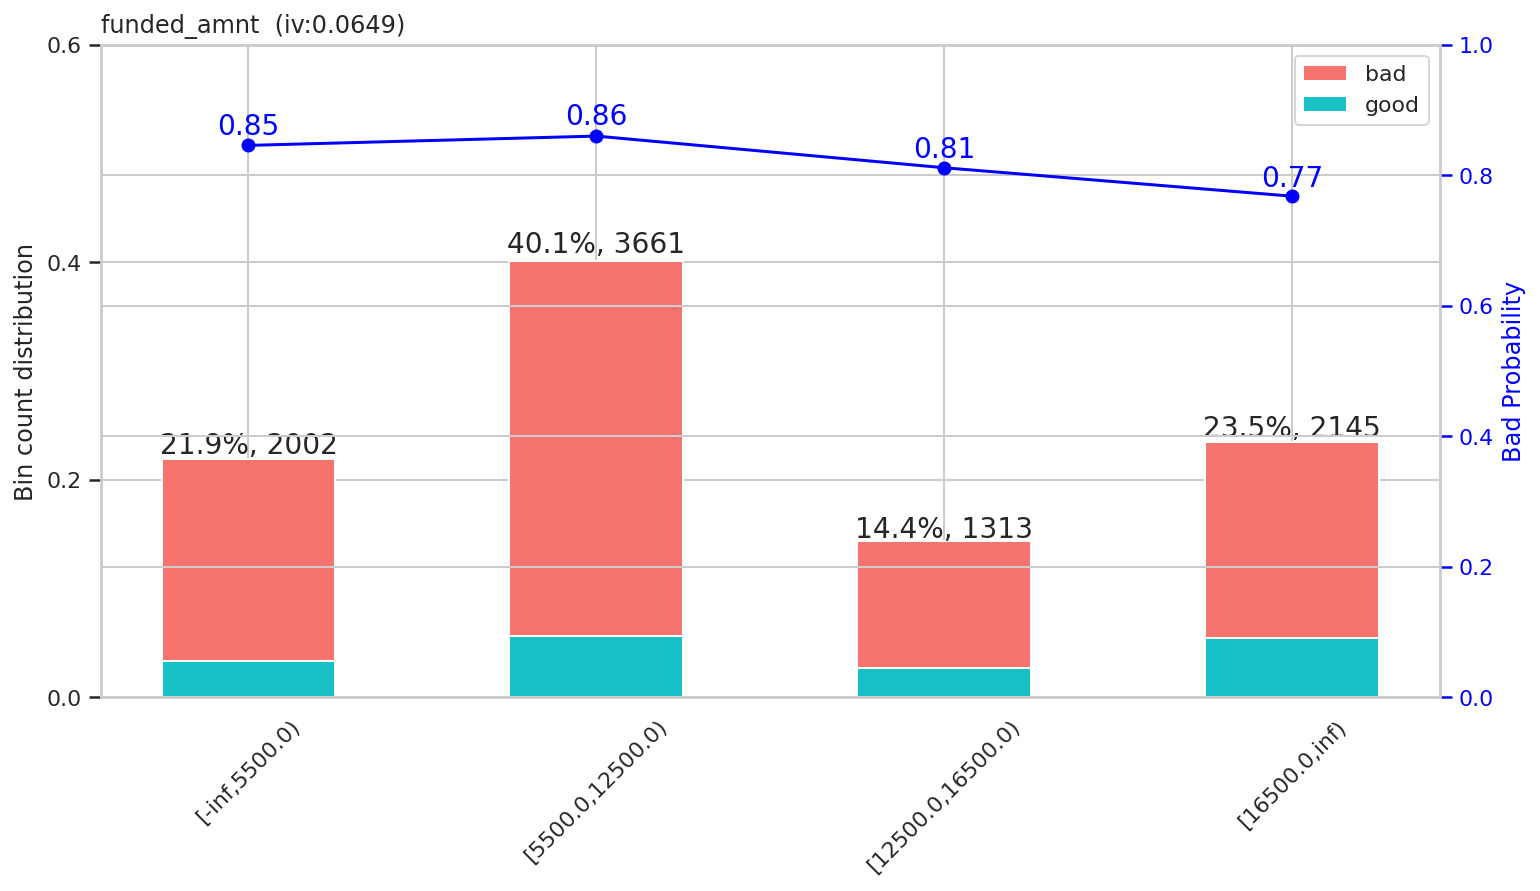

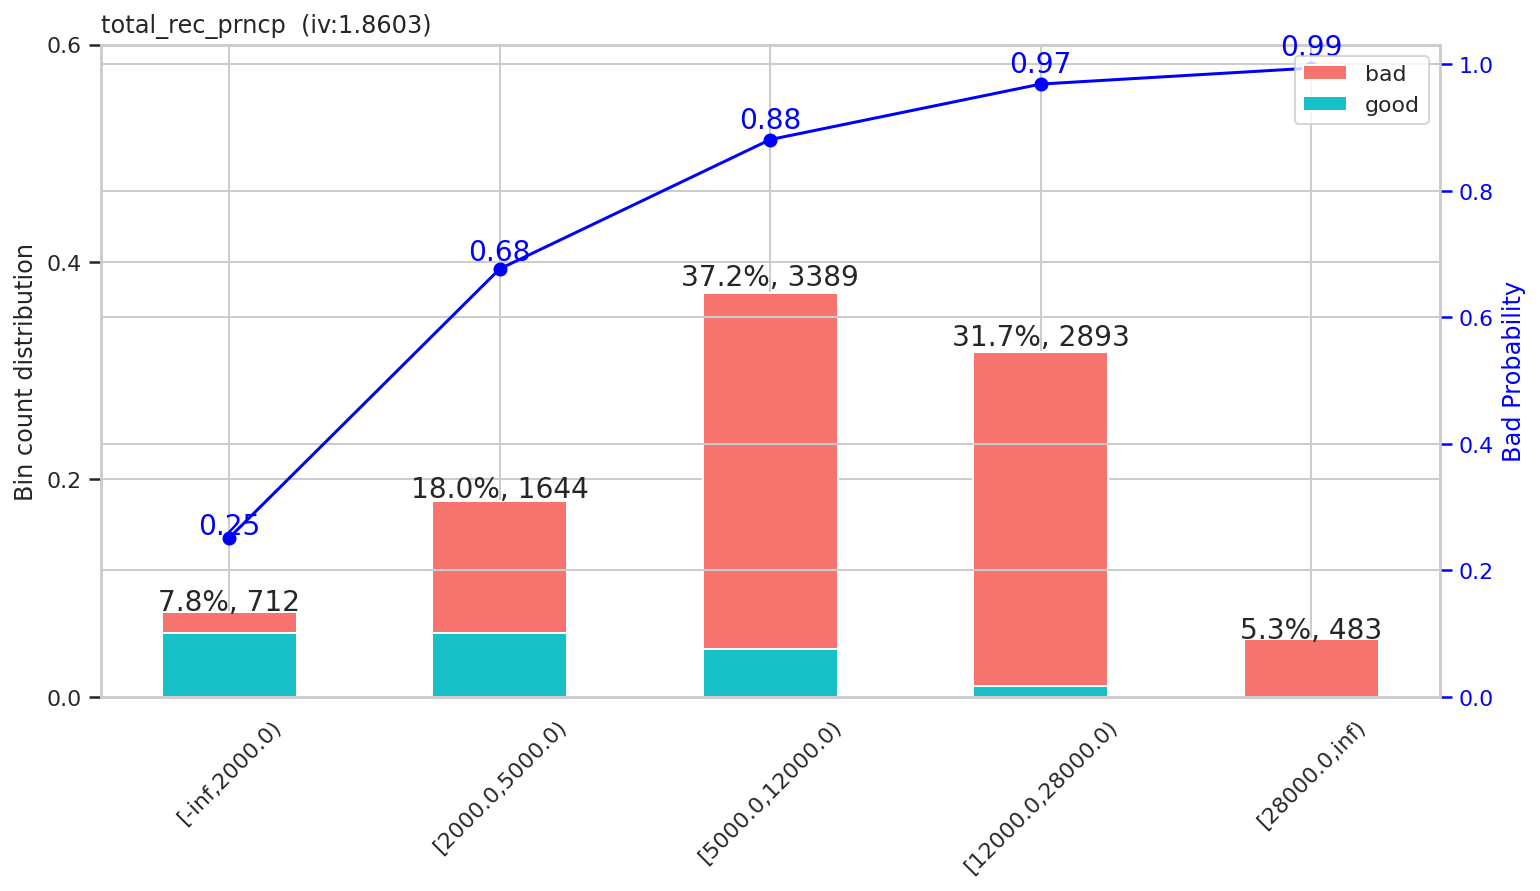

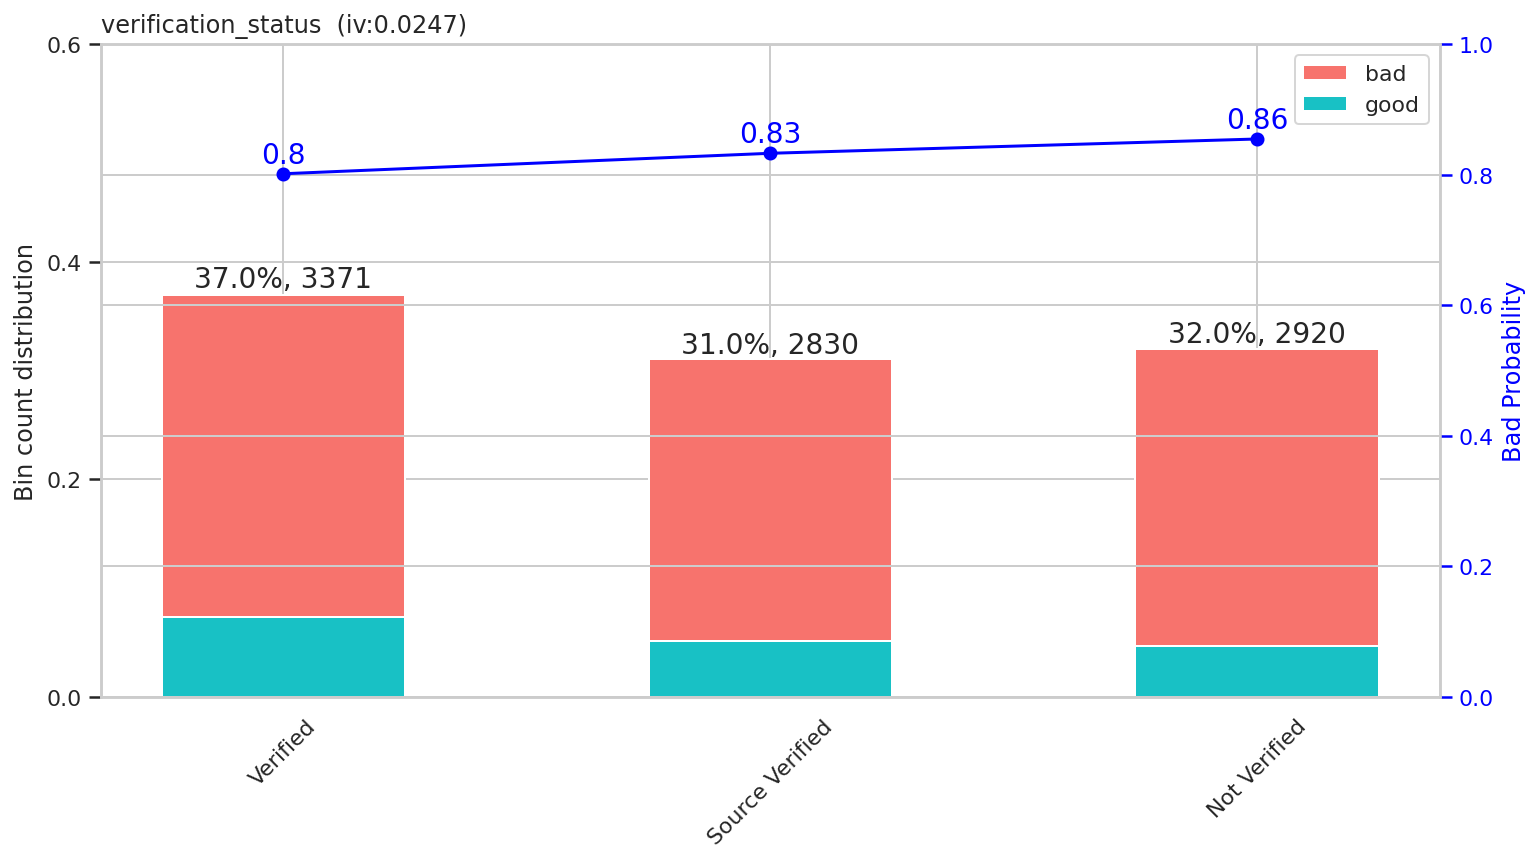

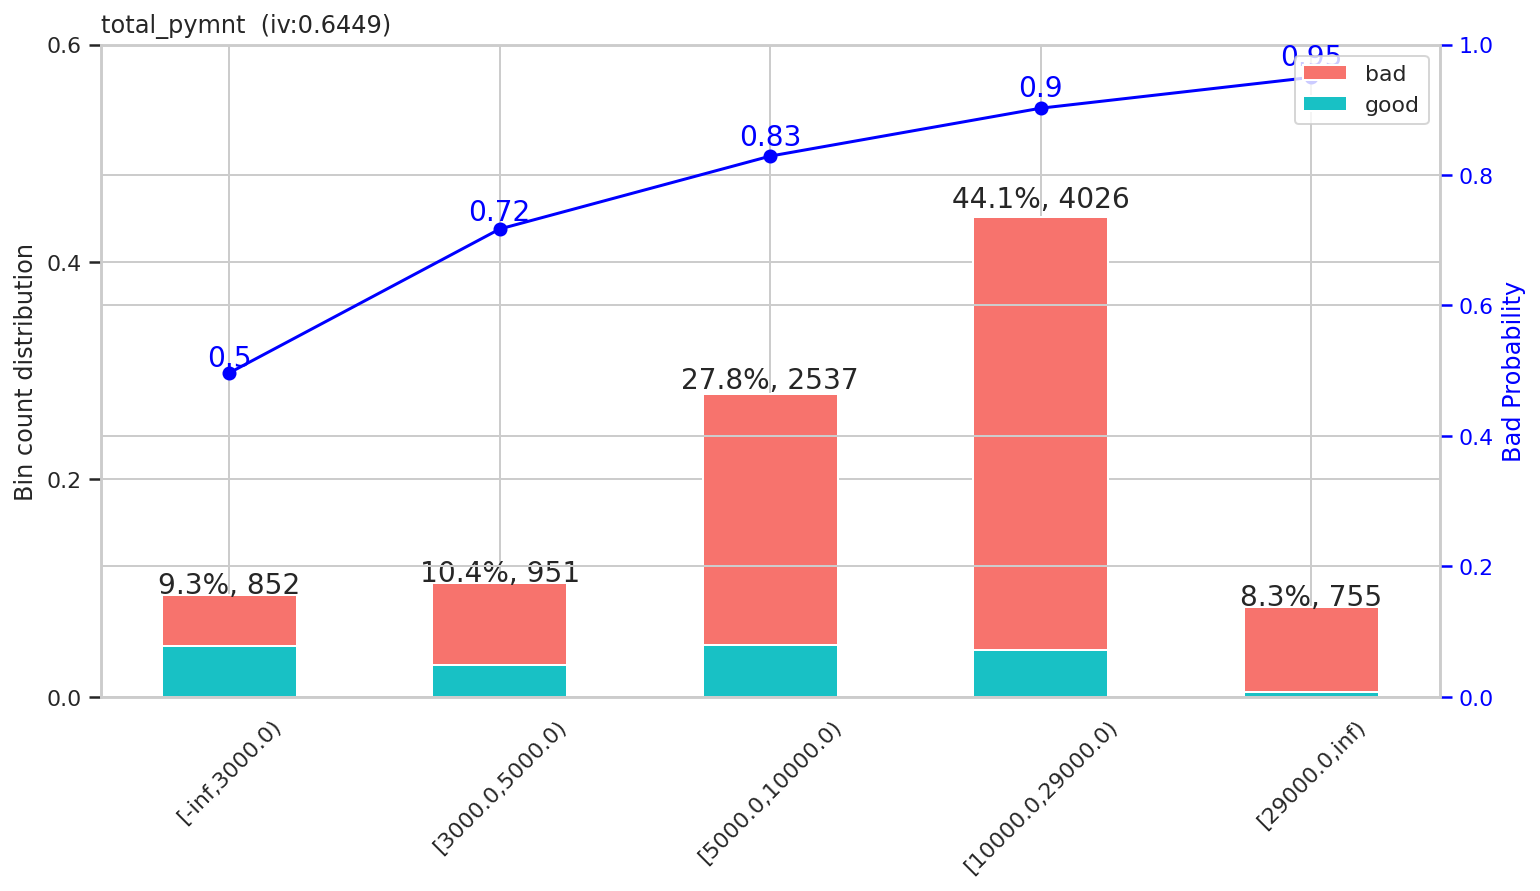

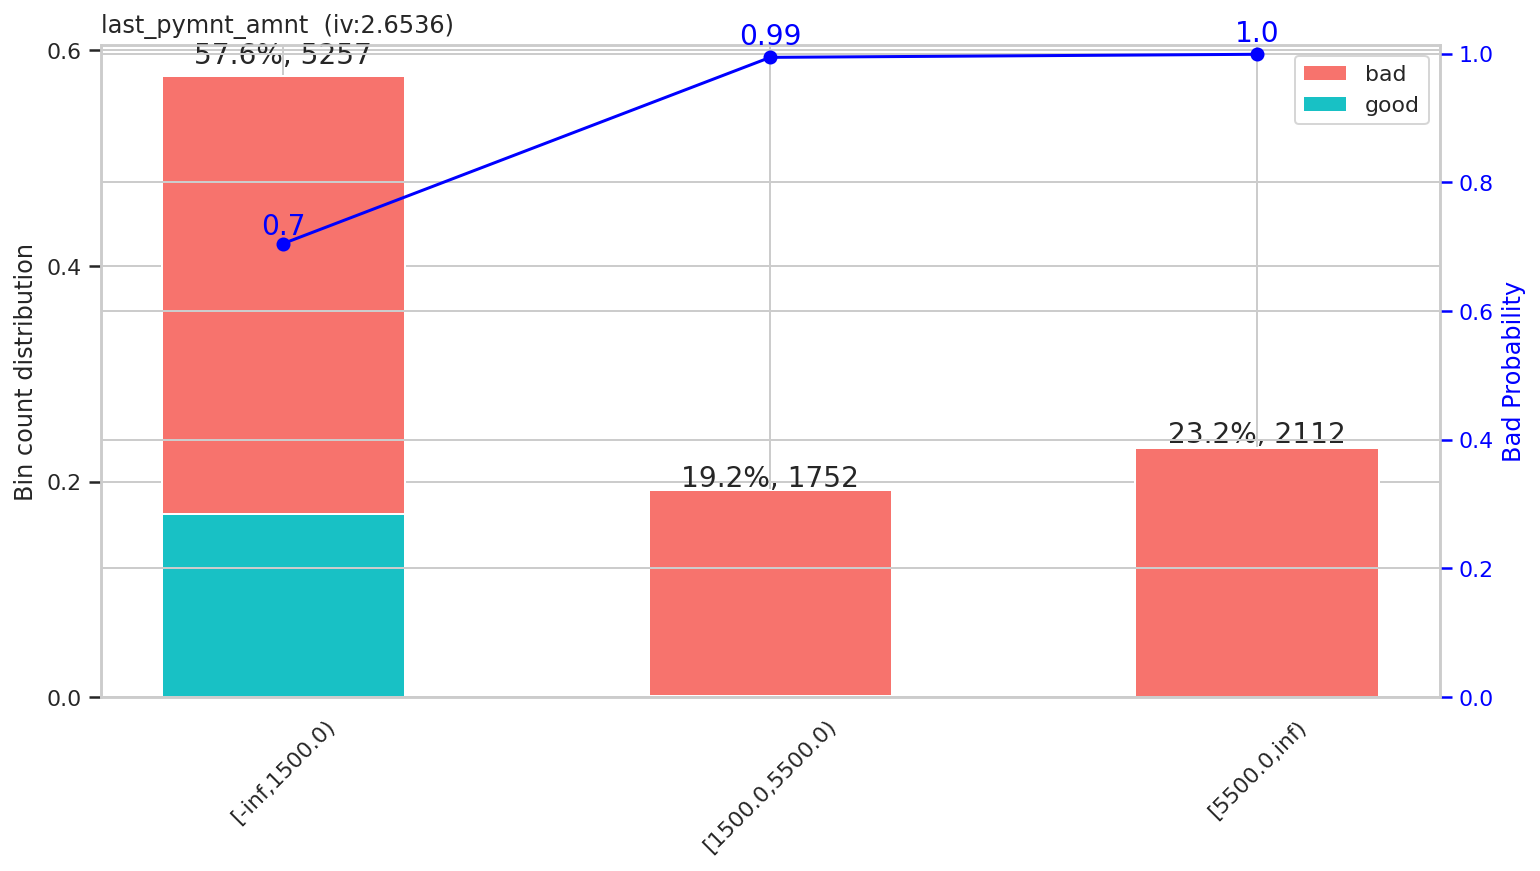

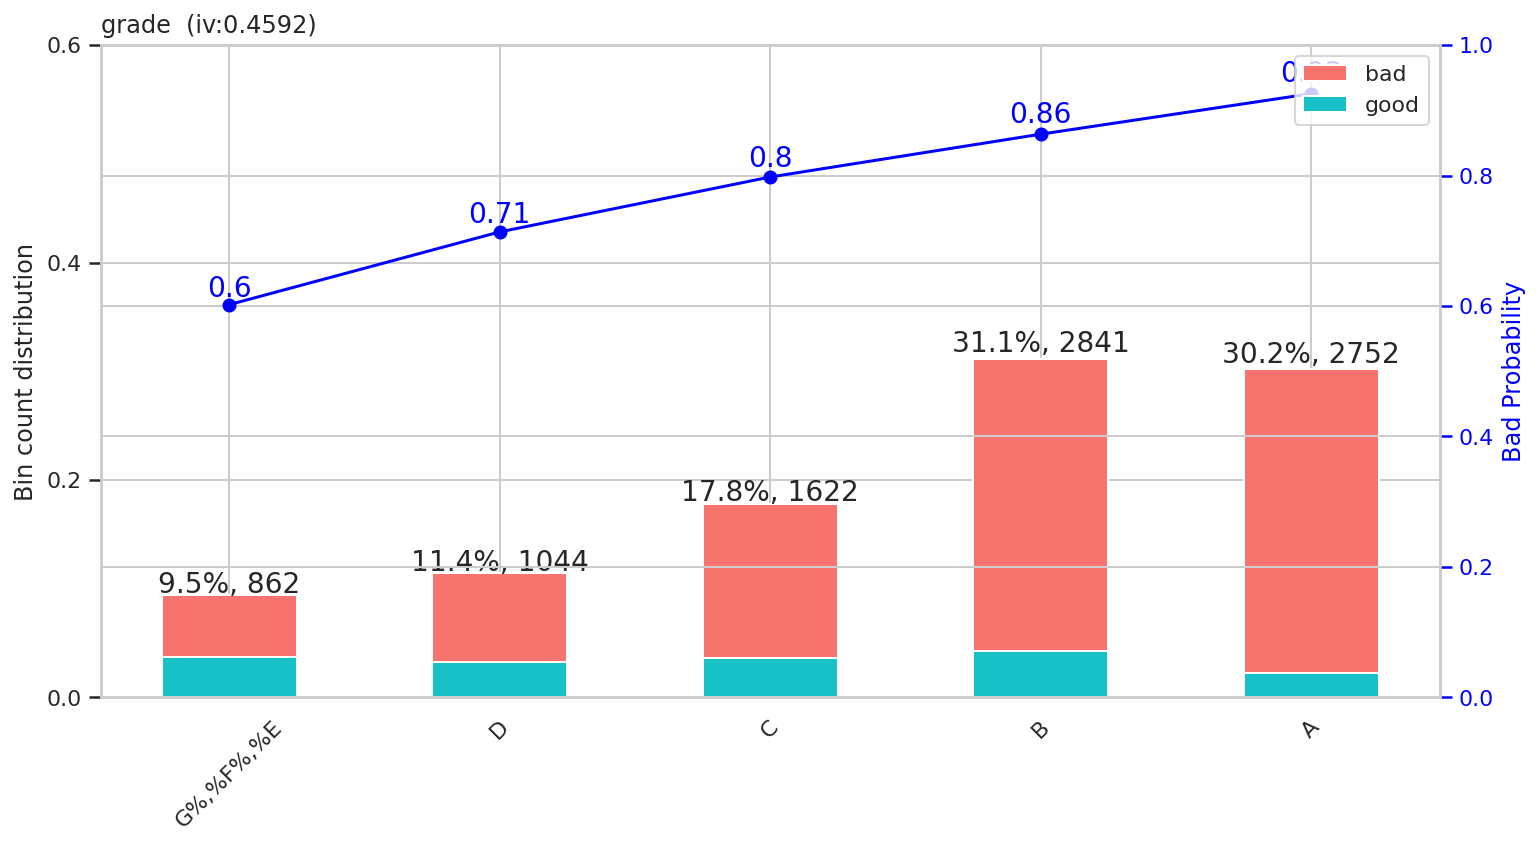

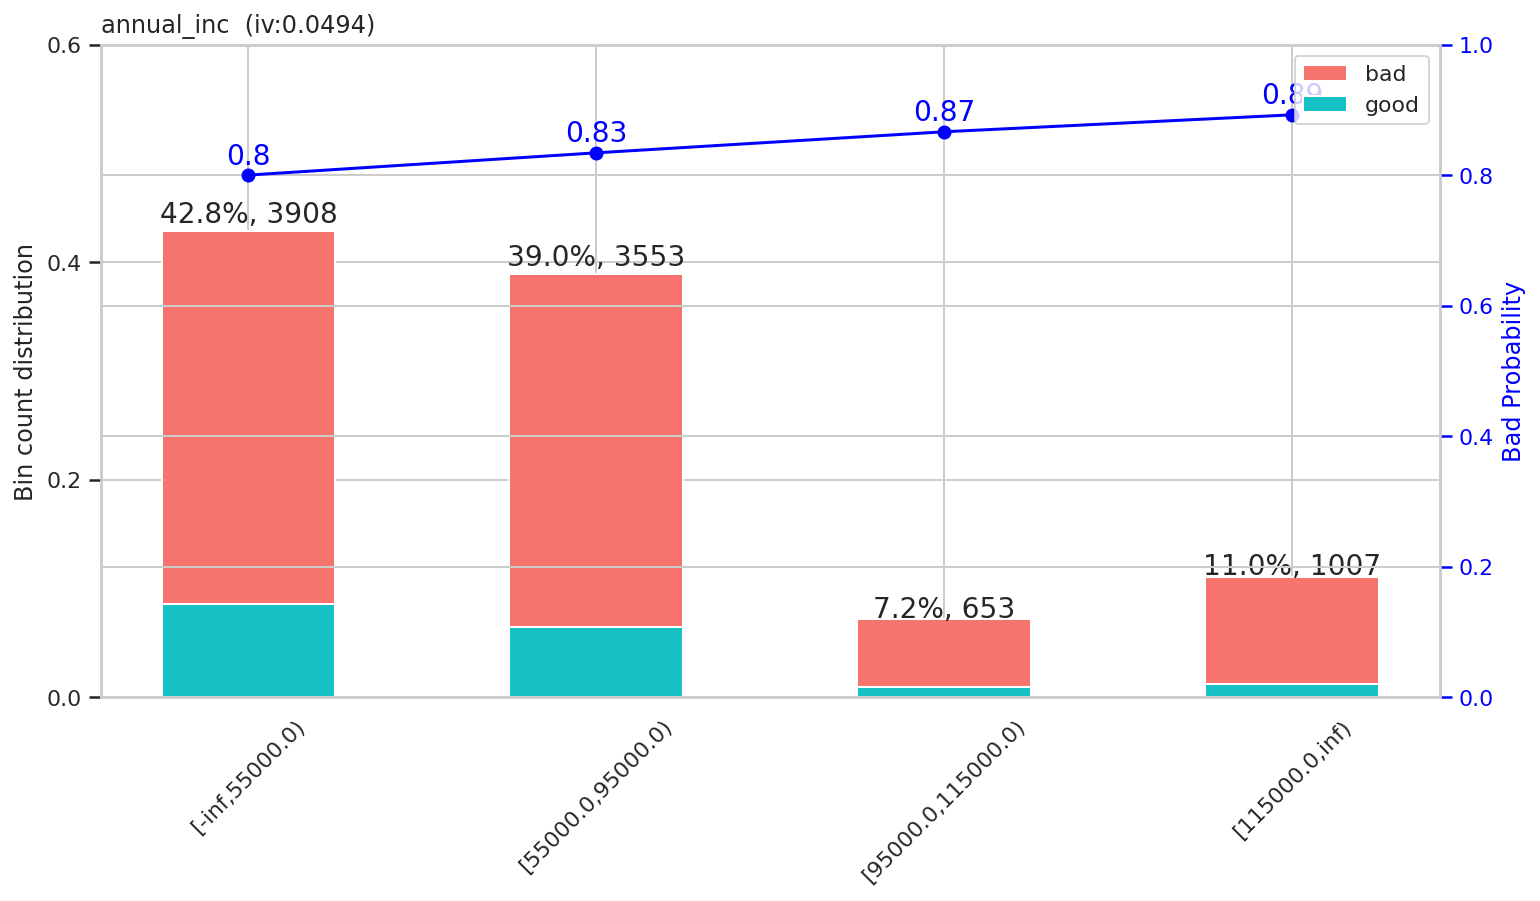

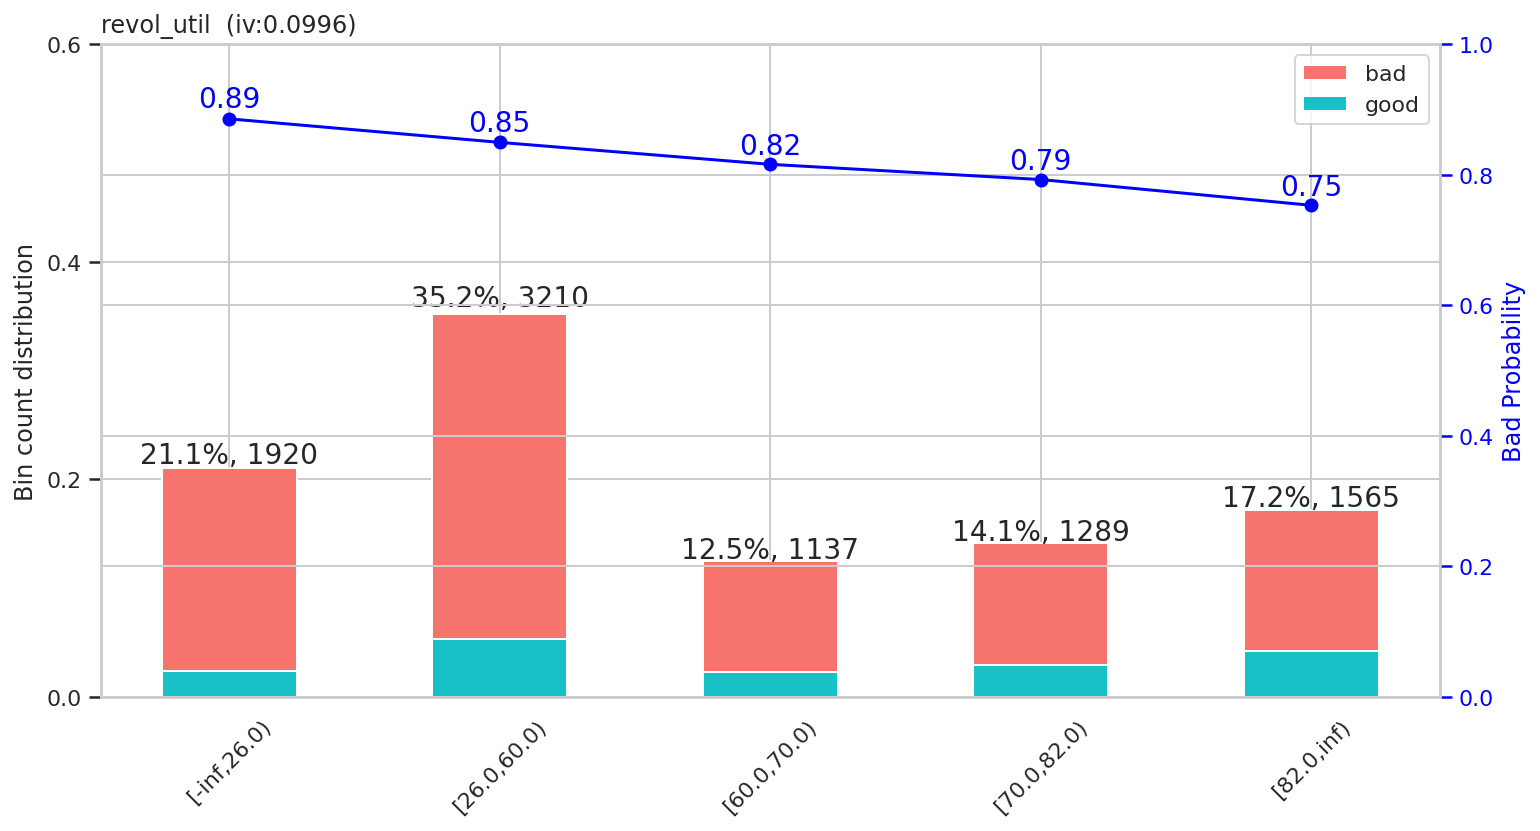

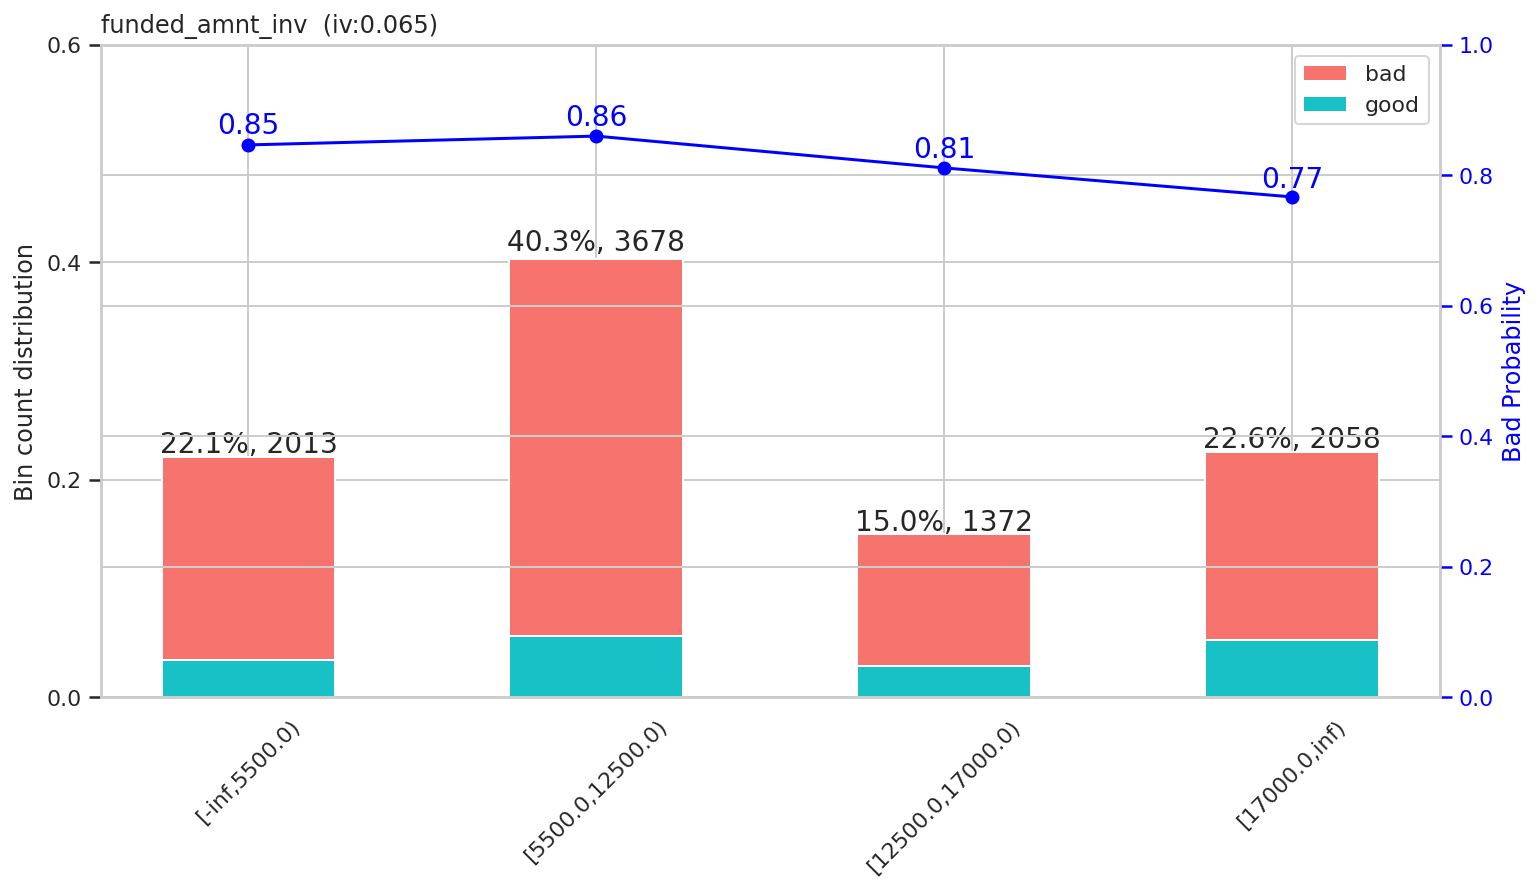

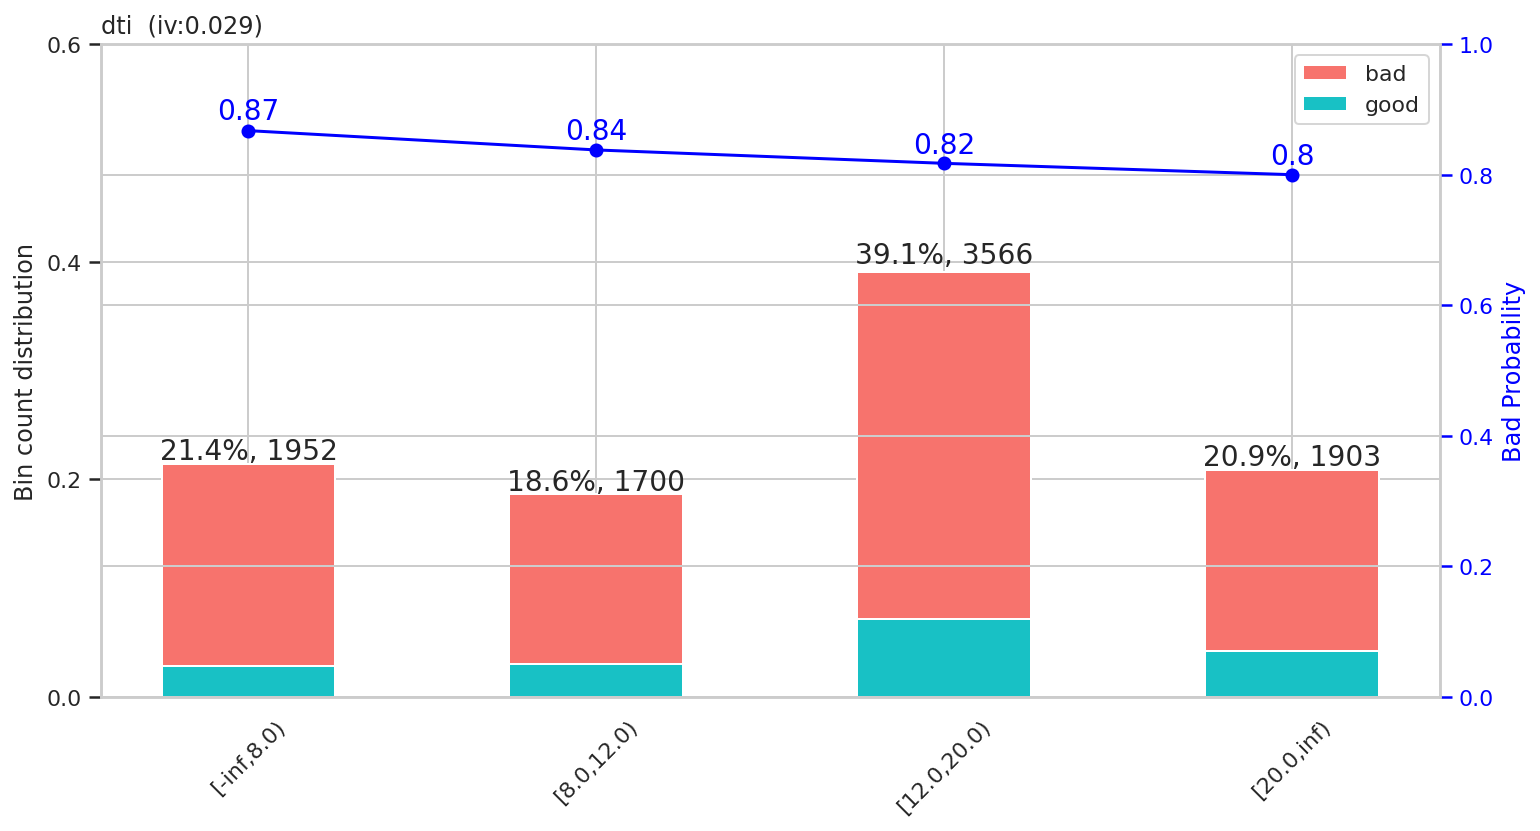

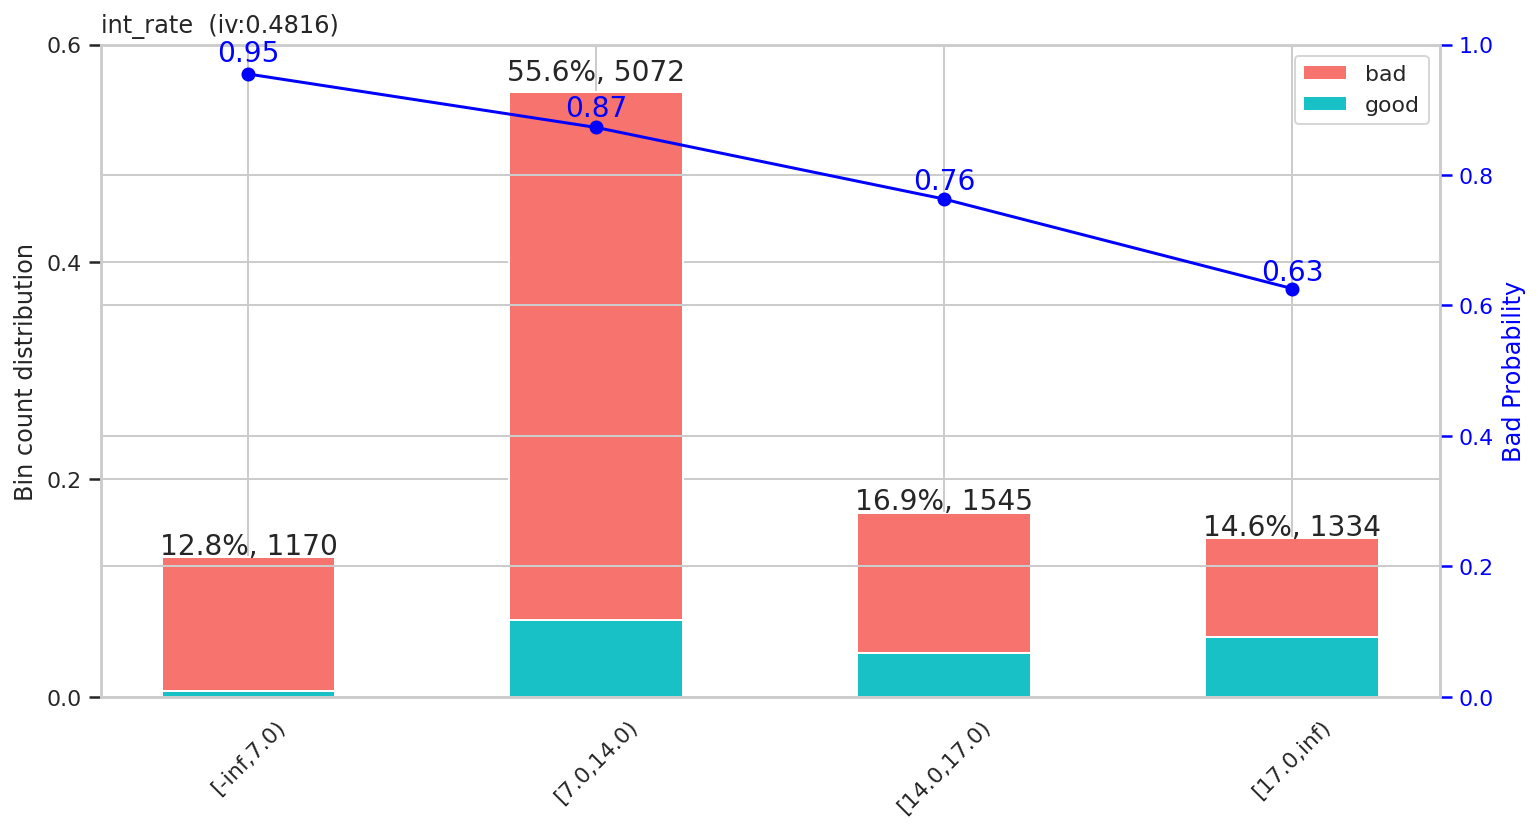

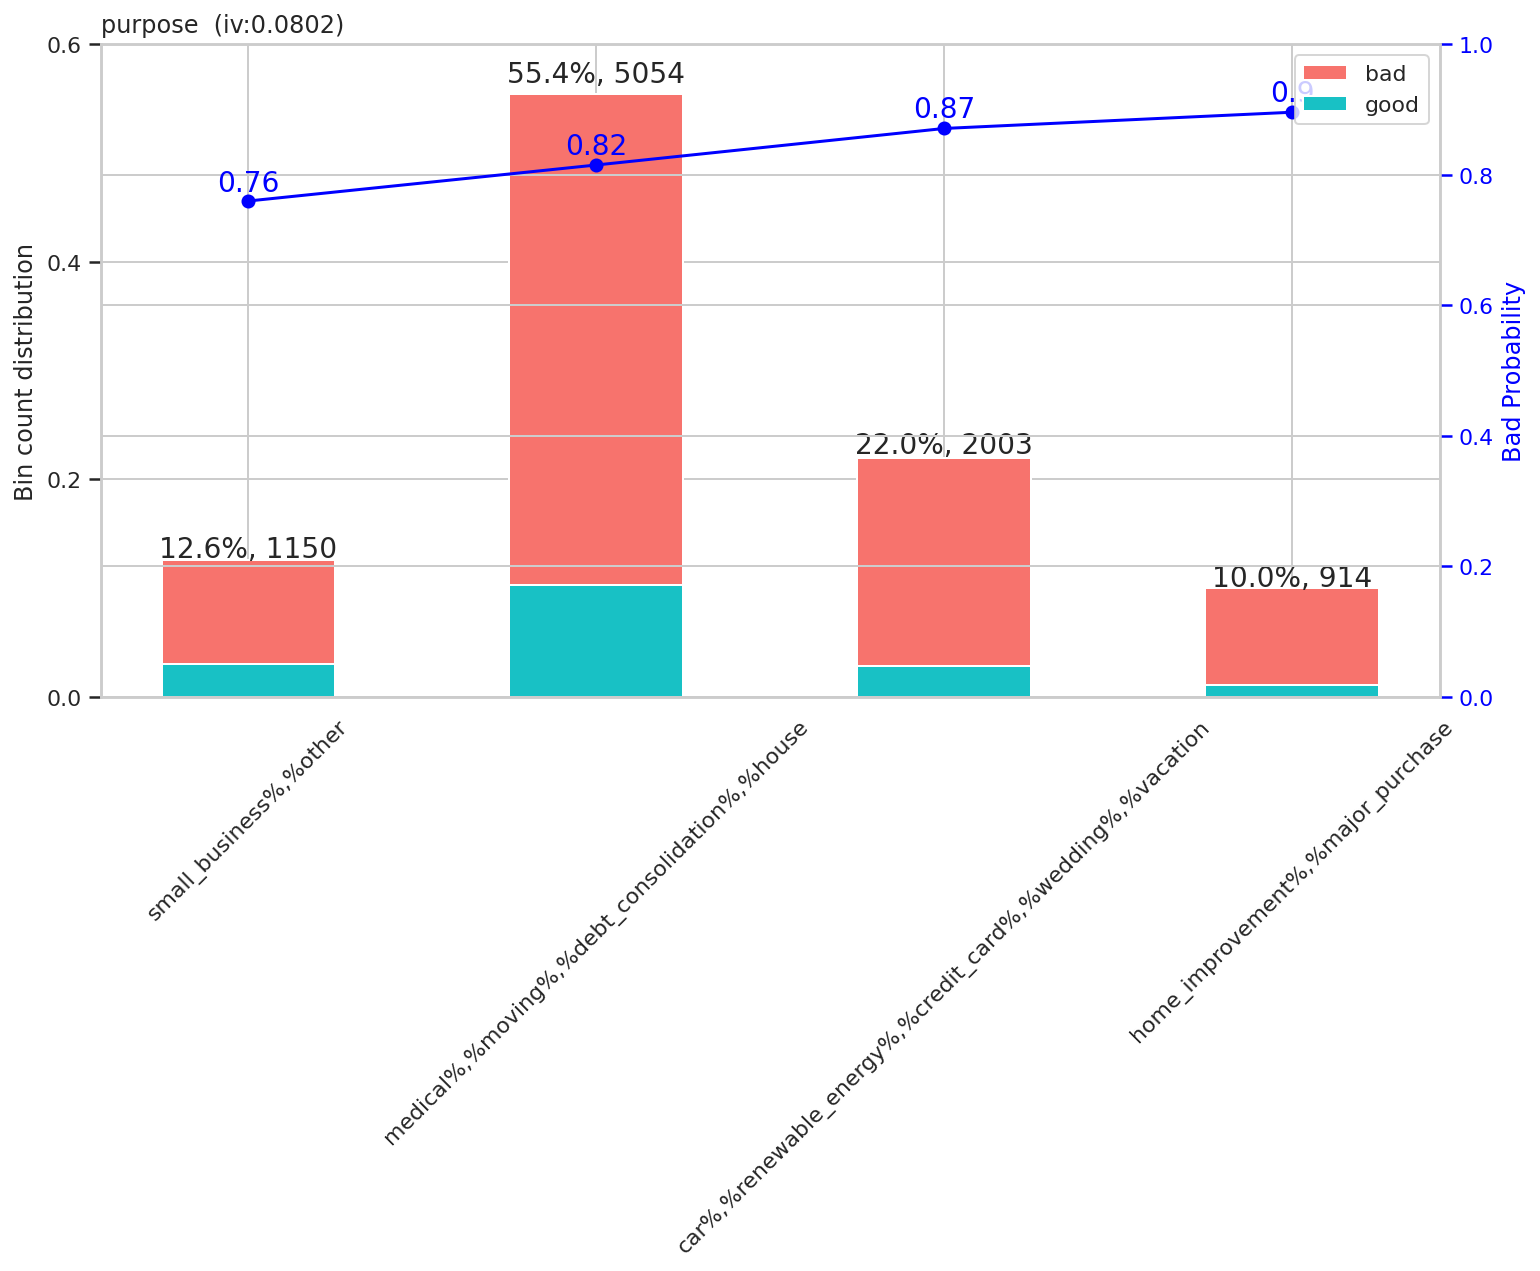

In [40]:
woebin_plot_new(bins)

Report Analysis : <br>

1.total_pymnt : semakin besar total payment, maka persentase **good borrower** semakin besar. <br>
2.term : resiko uang tidak dikembalikan begitu besar ketika term diatas 36 bulan. <br>
3.int_rate : int_rate yang semakin besar dapat meningkatkan resiko uang tidak dikemablikan semakin besar. <br>
4.loan_amnt : jumlah loan_amnt yang besar berisiko tinggi untuk tidak dibayarkan. <br>
5.total_rec_int : semakin tinggi total_rec_int maka resiko uang tidak dibayar semakin tinggi. <br>
6.total_pymnt :  semakin besar total_pymnt persentase **good borrower** semakin tinggi <br>
7.annual_inc : besarnya annual_inc, persentase **good borrower** semakin tinggi
8.inq_last_6mnth : semakin besar inq_last_6mnth, maka persentase **good borrower** semakin kecil. <br>
9.funded_amnt_inv : semakin besar funded_amnt_int, maka persentase **good borrower** semakin kecil. <br>
10.grade : nasabah pada grade E,F dan G memberikan persentase untuk pelunasan hutan semakin kecil (high risk), grade D dan C persentase untuk membayar lebih baik dari grade E,F,G (moderate risk), sedangkan grade terbaik untuk melakukan penulanasan adalah grade A dan B (low risk). <br>
11.last_pymnt_amnt : resiko uang dikembalikan sangat besar ketika last_pymnt_amnt lebih kecil dari 1500. <br>
12.total_pymnt_inv : prosentase **good borrower** semakin besar ketika total_pymnt_inv semakin besar. <br>

In [41]:
#backup data
data = df.copy()

#save
#data.to_csv("dataloan.csv")

#transsform to woe
df = sc.woebin_ply(df, bins)

[INFO] converting into woe values ...


### EDA base on Feature have high IV

Text(0.5, 1.0, 'Count Home Ownership')

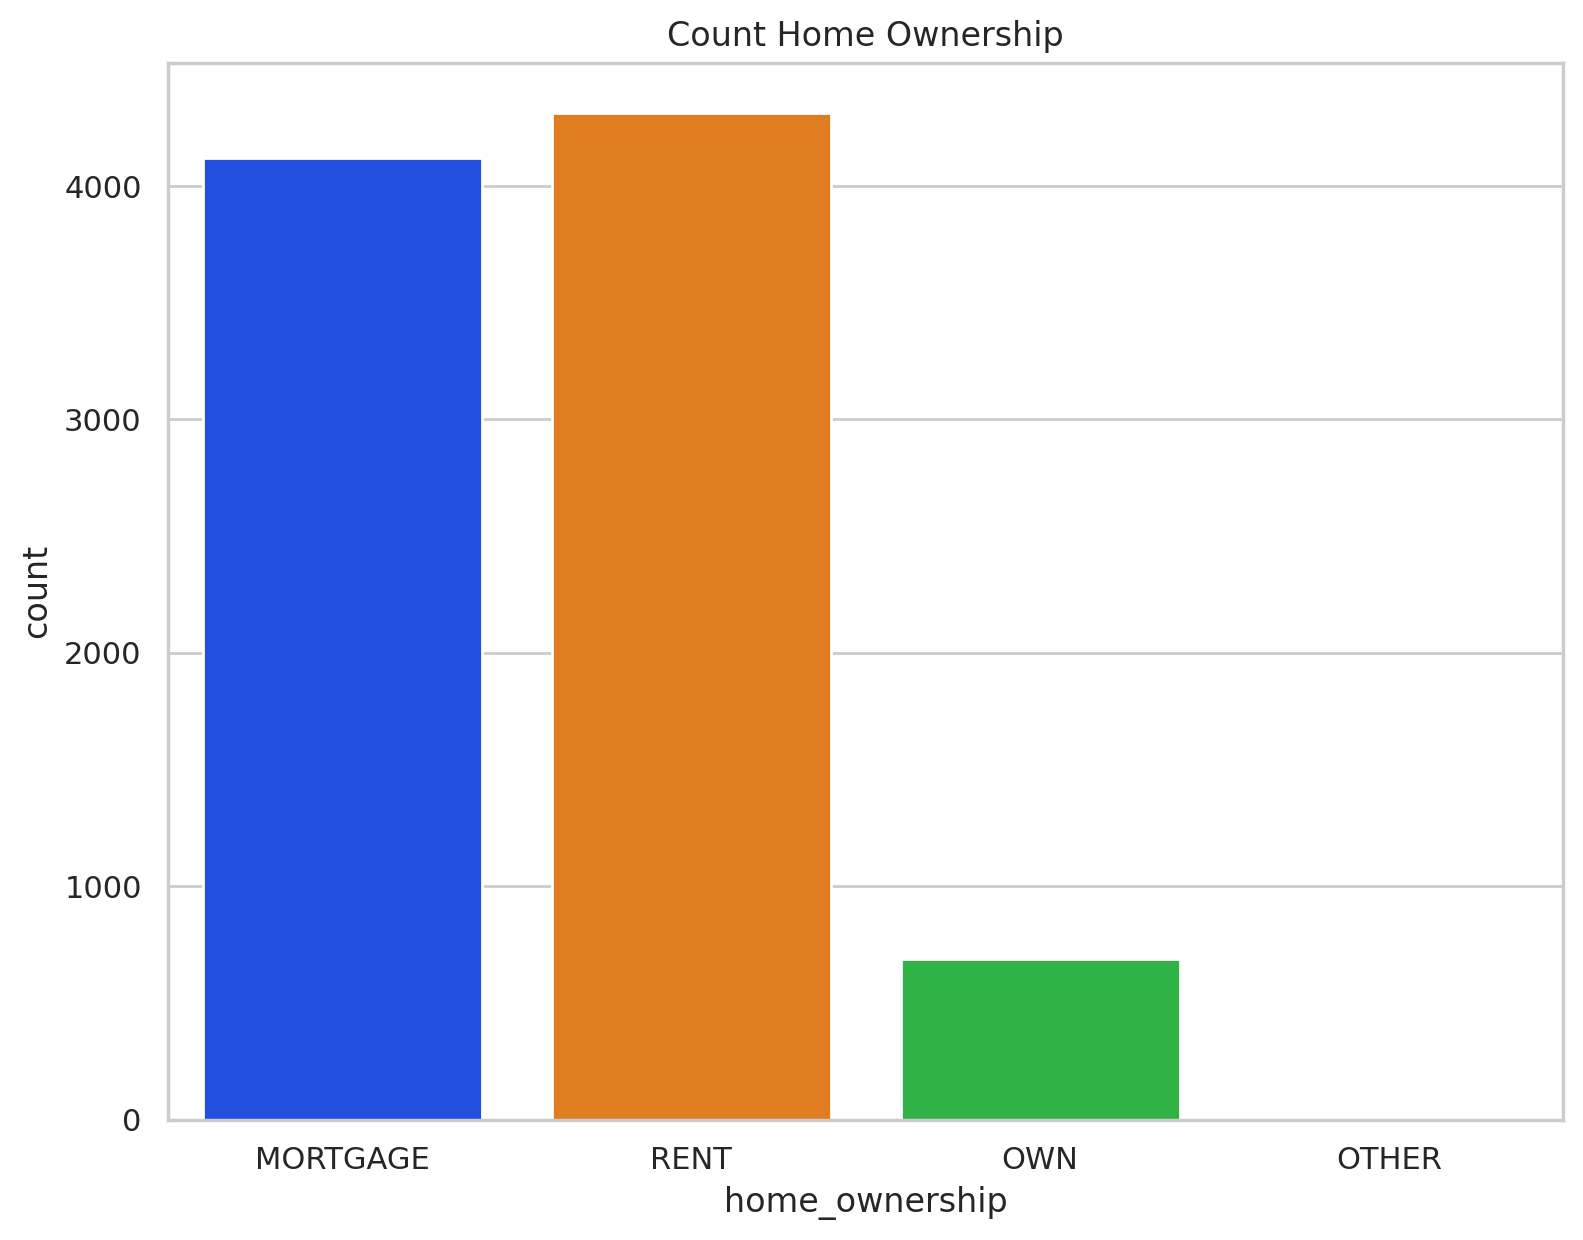

In [42]:
plt.figure(figsize=(9,7),dpi=100)
sns.countplot(data=data,x='home_ownership',order=['MORTGAGE','RENT','OWN','OTHER'])
plt.title("Count Home Ownership")

nasabah peminjam paling banyak berstatus **MORTGAGE dan RENT**

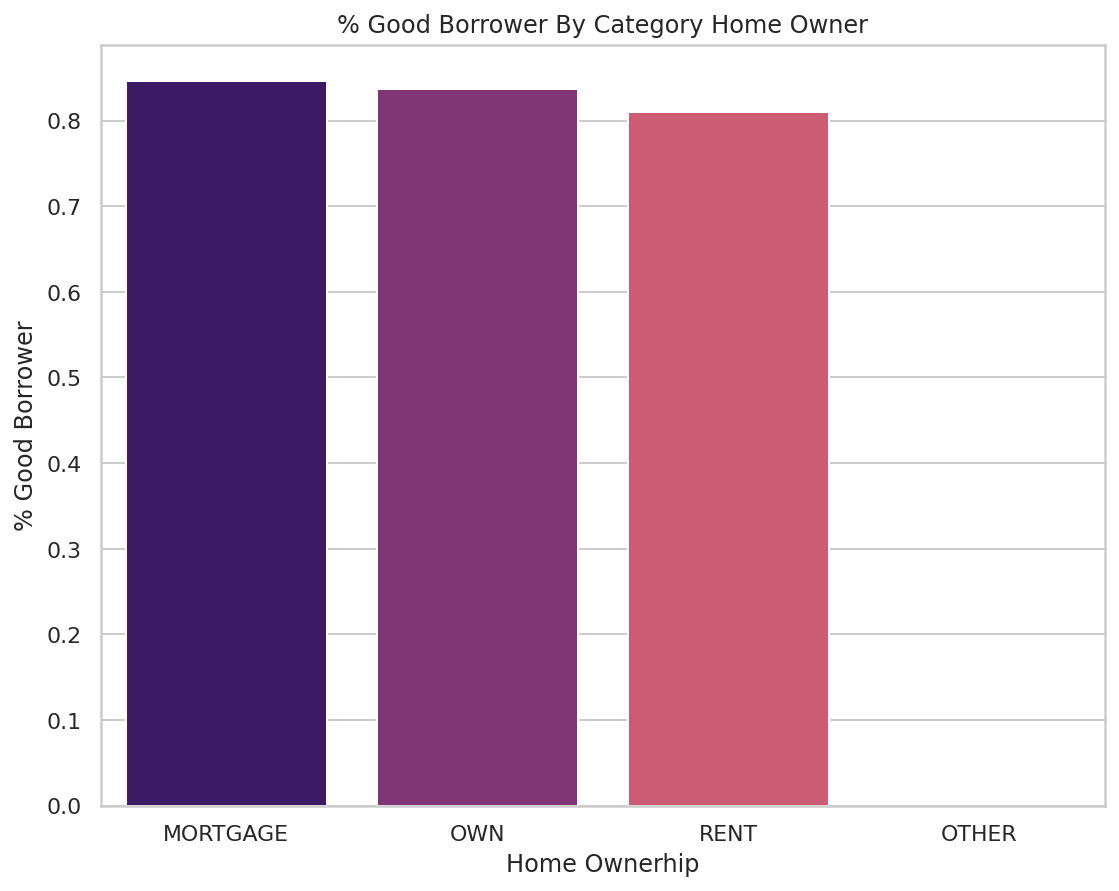

In [43]:
home_owner_group = data.groupby("home_ownership",as_index=False)["good_bad"].mean()

plt.figure(figsize=(9,7))
sns.barplot(data=home_owner_group,x="home_ownership",y="good_bad",palette="magma",order=["MORTGAGE","OWN","RENT","OTHER"])
plt.title("% Good Borrower By Category Home Owner")
plt.xlabel("Home Ownerhip")
plt.ylabel("% Good Borrower");

Terlihat persentase dari **good borrower**, persentase tertinggi dimiliki **MORTGAGE** kemudian **OWN**, sedangkan persentase terendah yaitu **OTHER**. dari hal ini ketika nasabah memiliki status home ownership **OTHER** perlu untuk diawasi ketika melakukan pengajuan pinjaman

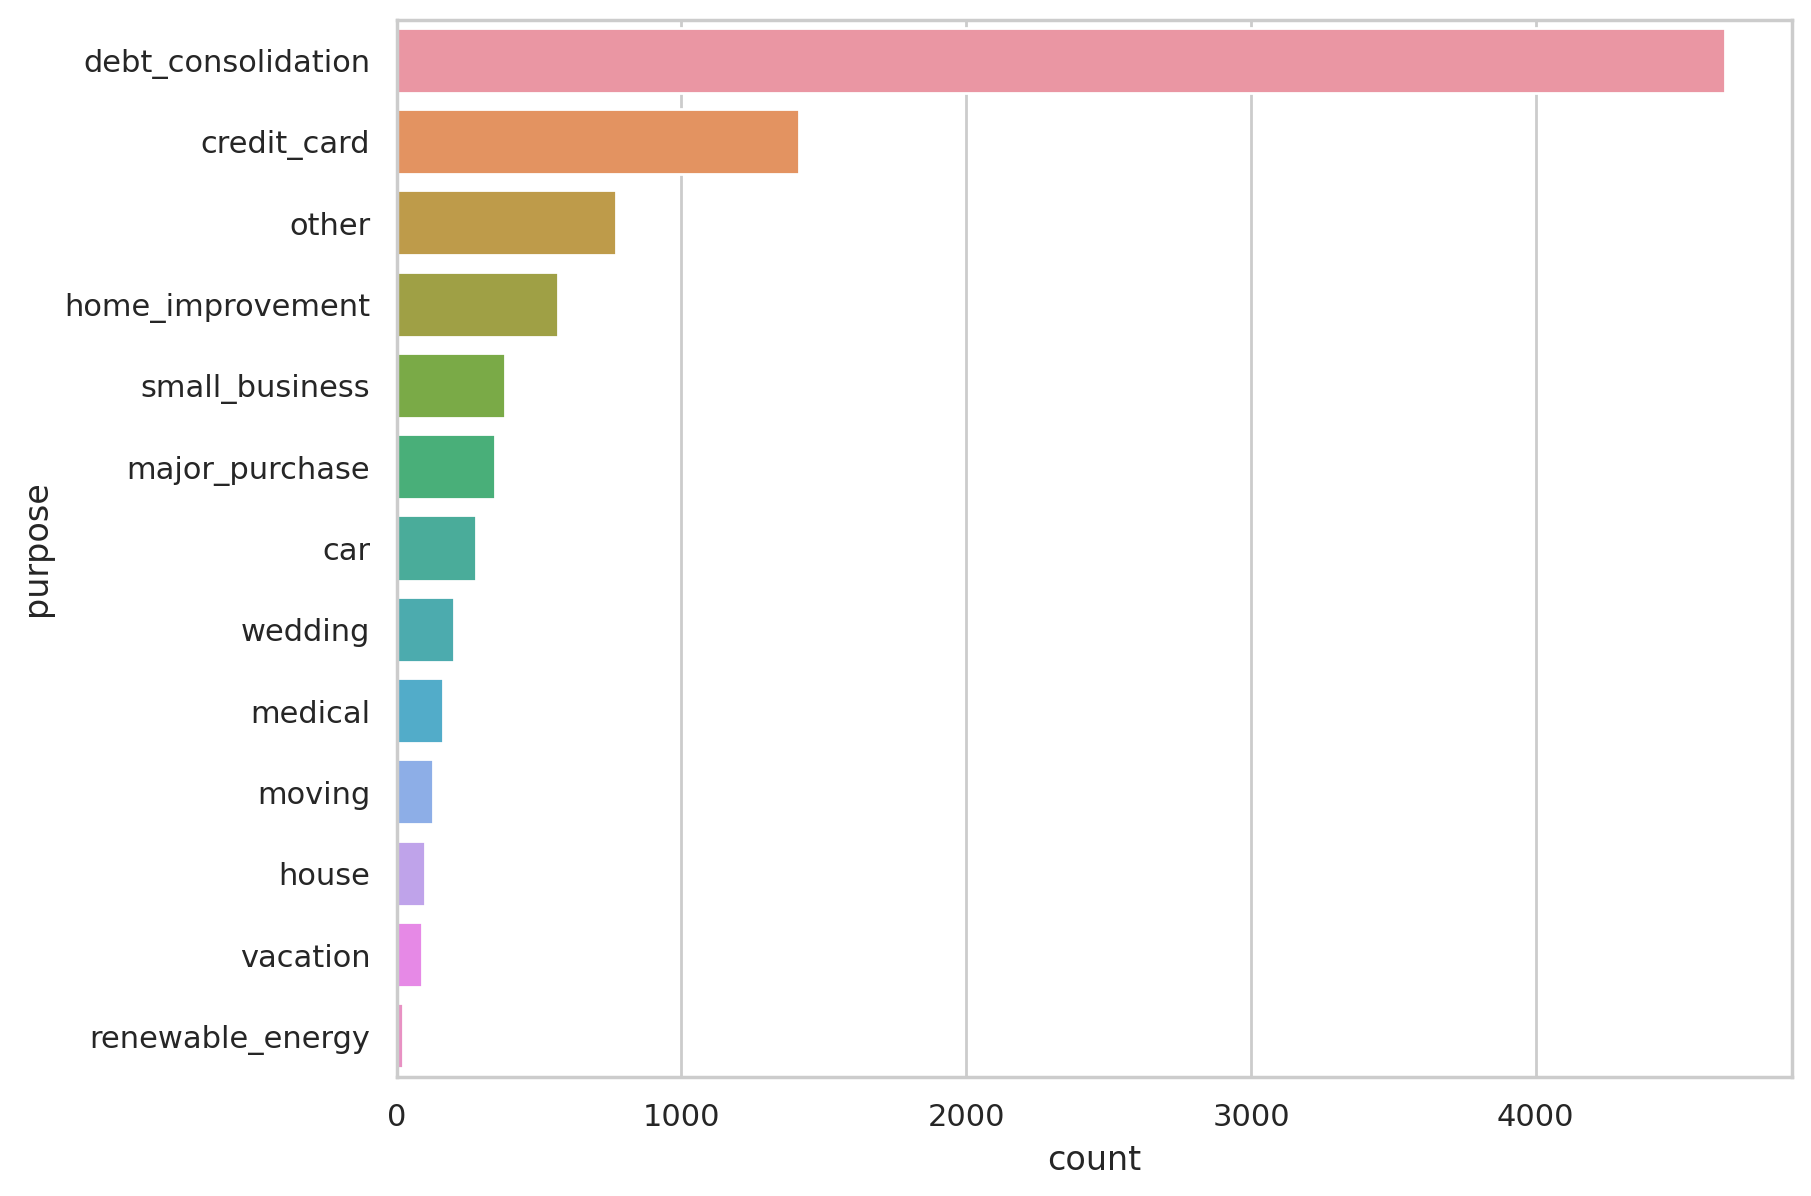

In [44]:
plt.figure(figsize=(9,7),dpi=100)
sns.countplot(data=data,y='purpose',order=data["purpose"].value_counts().index)

Berdasarkan purpose of borrower melakukan pinjaman untuk melunasi hutang dan melakukan credit card

In [45]:
data.groupby("purpose").agg({"good_bad":[len,'sum','mean']}).sort_values(('good_bad', 'mean'),ascending=False)

good_bad                
                        len   sum      mean
purpose                                    
major_purchase          346   317  0.916185
home_improvement        568   502  0.883803
vacation                 89    78  0.876404
wedding                 202   177  0.876238
credit_card            1412  1233  0.873229
renewable_energy         23    20  0.869565
car                     277   237  0.855596
house                    99    81  0.818182
debt_consolidation     4665  3809  0.816506
moving                  126   100  0.793651
medical                 164   130  0.792683
other                   770   605  0.785714
small_business          380   269  0.707895

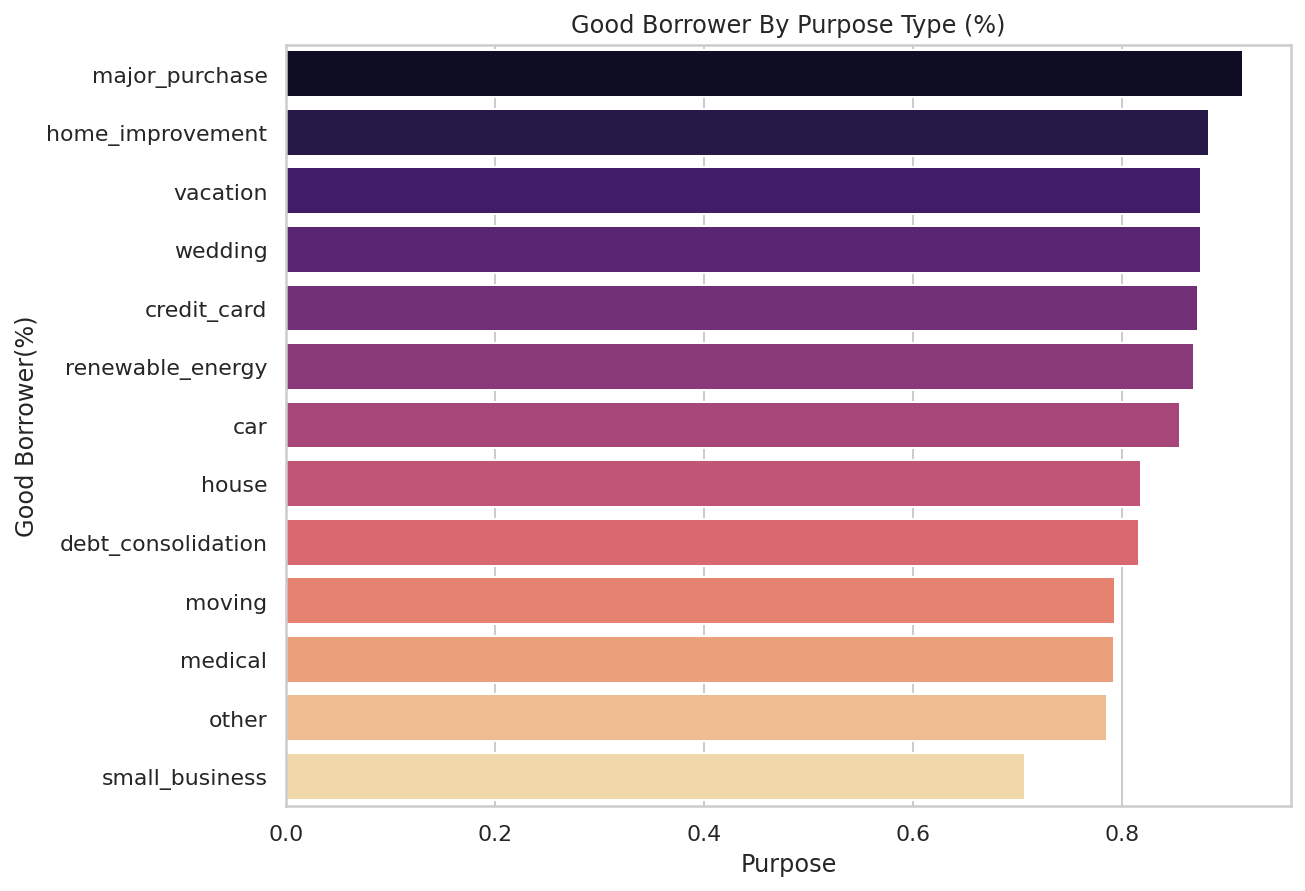

In [46]:
purpose_type = data.groupby("purpose",as_index=False)["good_bad"].mean().sort_values("good_bad",ascending=False)

plt.figure(figsize=(9,7))
sns.barplot(data=purpose_type,y="purpose",x="good_bad",palette="magma")
plt.title("Good Borrower By Purpose Type (%)")
plt.xlabel("Purpose")
plt.ylabel("Good Borrower(%)");

Borrower yang memiliki tujuan untuk **car,wedding dan major purchase** memiliki peluang yang tinggi untuk melakukan pelunasan, sedangkan nasabah dengan tujuan untuk **educational dan small_business** memiliki persentase yang paling rendah sehingga perlu adanya tindakan khusus untuk nasabah yang memiliki tujuan tersebut.

Text(0.5, 1.0, 'Distribution Last Payment Amount by Good and Bad Borrower')

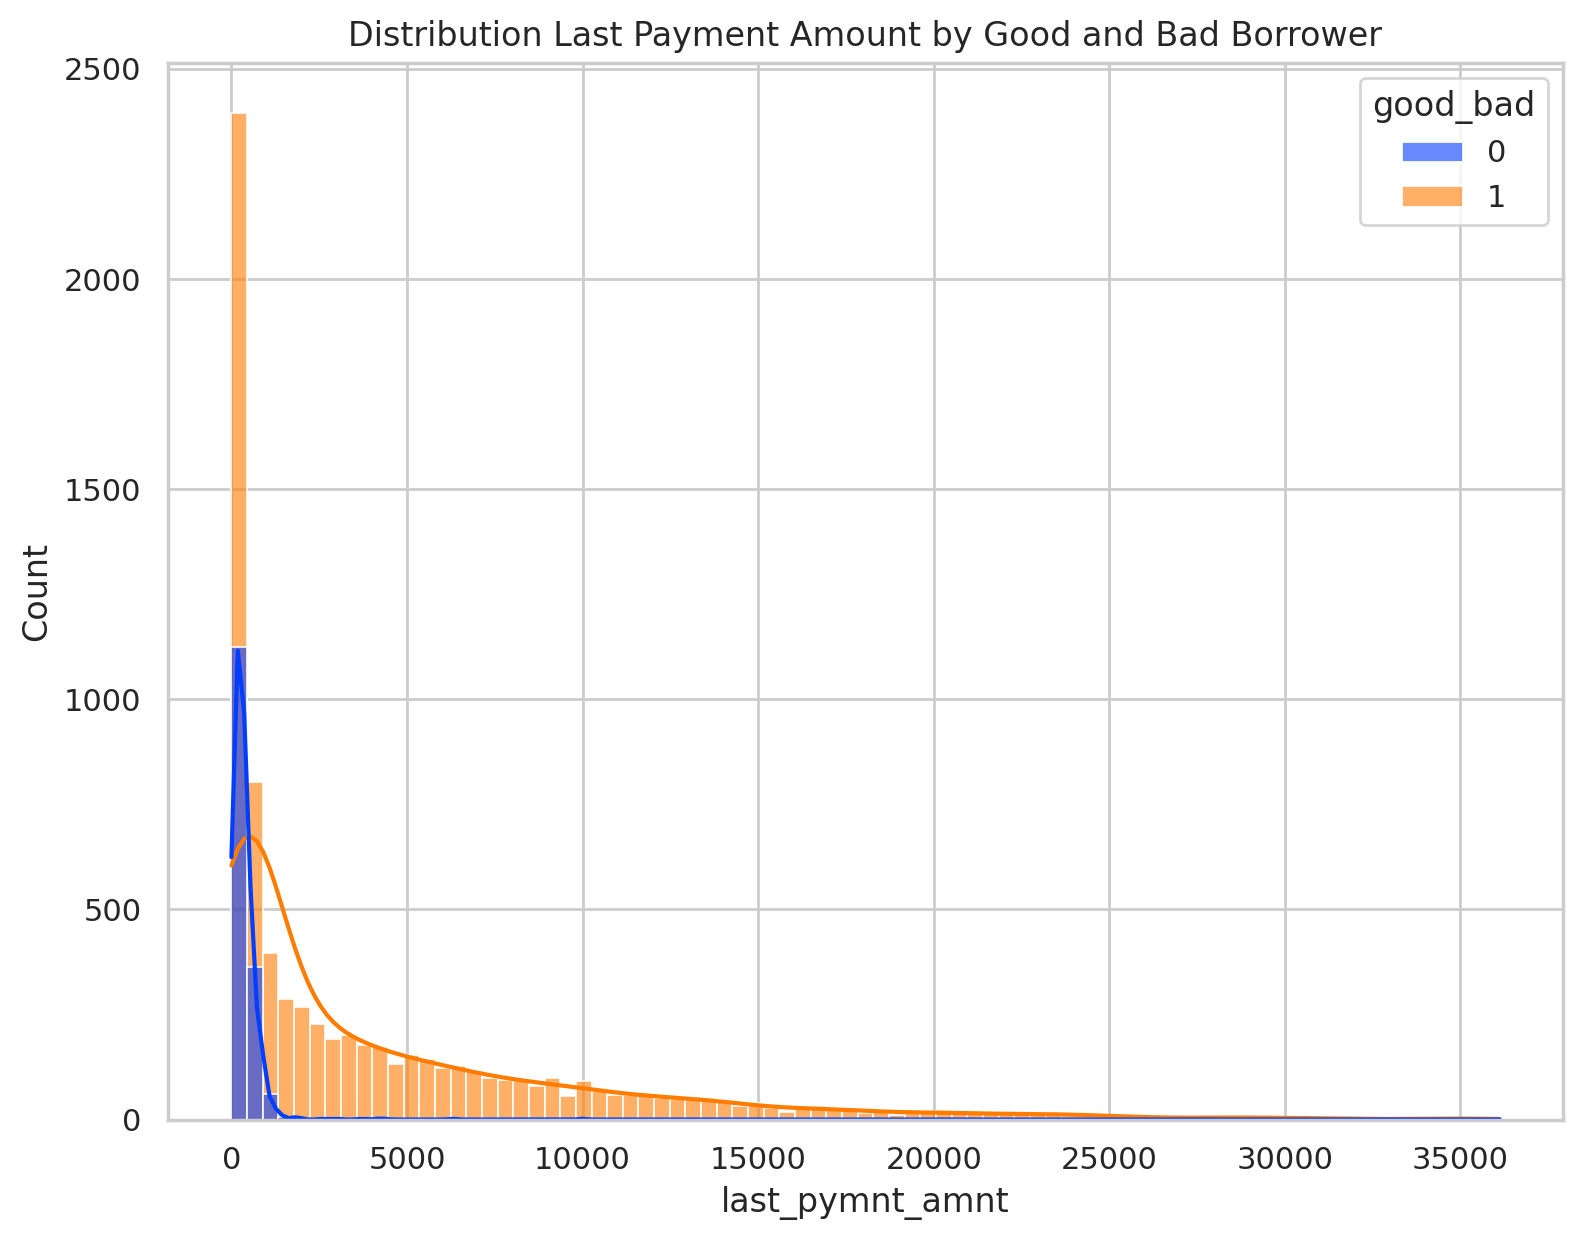

In [47]:
plt.figure(figsize=(9,7),dpi=100)
sns.histplot(data=data,x='last_pymnt_amnt',hue='good_bad',kde=True,alpha=0.6)
plt.title("Distribution Last Payment Amount by Good and Bad Borrower")

Nasabah yang tidak mampu mengembalikkan uang pinjaman karena memiliki last payment yang rendah. 

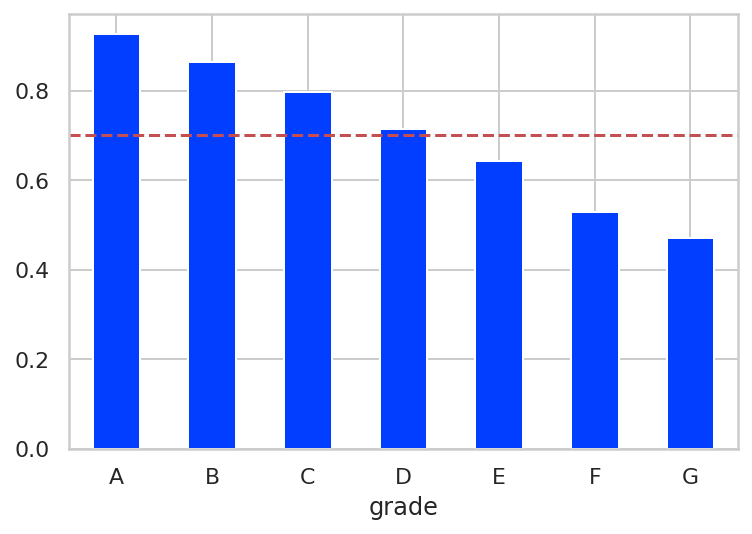

In [48]:
data.groupby("grade")["good_bad"].mean().plot(kind="bar")
plt.axhline(y=0.7,linestyle="--",color="r")
plt.xticks(rotation=0);

Berdasarkan kategory grade, grade A,B dan C adalah kategory bagus karena memiliki persentase **Good Borrower** karena memiliki peluan untuk pelunasan uang pinjaman diatas 70%

In [49]:
data.groupby("grade").median().T

grade                       A            B            C          D  \
last_pymnt_amnt    640.665000    798.26000    819.60000    749.875   
total_rec_prncp   8000.000000   9000.00000   8886.64000   9275.000   
total_pymnt_inv   8705.005000  10609.49000  11042.49000  12456.570   
total_pymnt       8722.969799  10728.14301  11088.19815  12456.570   
int_rate             7.510000     11.71000     14.27000     16.770   
dti                 12.490000     14.15000     14.70000     14.790   
revol_util          32.070000     55.00000     64.75000     73.400   
annual_inc       60000.000000  58000.00000  59000.00000  60000.000   
inq_last_6mths       0.000000      0.00000      1.00000      1.000   
total_rec_int      770.410000   1449.39000   1902.44000   2581.965   
funded_amnt       8000.000000  10000.00000  10450.00000  12000.000   
loan_amnt         8000.000000  10000.00000  10500.00000  12000.000   
funded_amnt_inv   8000.000000  10000.00000  10400.00000  12000.000   
installment        250.330000    309.72000    335.68500    354.870   
good_bad             1.000000      1.00000      1.00000      1.000   

grade                      E            F          G  
last_pymnt_amnt   2938.16000   1349.74000     981.45  
total_rec_prncp  12000.00000  11682.06000   12800.00  
total_pymnt_inv  18322.11500  18371.66000   23041.01  
total_pymnt      18458.56987  18599.44168   23069.83  
int_rate            19.03000     21.28000      23.13  
dti                 14.90500     14.73000      15.06  
revol_util          74.40000     76.90000      91.00  
annual_inc       69000.00000  75000.00000  100000.00  
inq_last_6mths       1.00000      1.00000       1.00  
total_rec_int     4873.18000   5928.29000    7454.28  
funded_amnt      17687.50000  21000.00000   26500.00  
loan_amnt        18000.00000  22000.00000   27300.00  
funded_amnt_inv  17612.50000  21000.00000   26475.00  
installment        475.99000    576.27000     771.65  
good_bad             1.00000      1.00000       0.00

Text(0, 0.5, 'Good Borrower (%)')

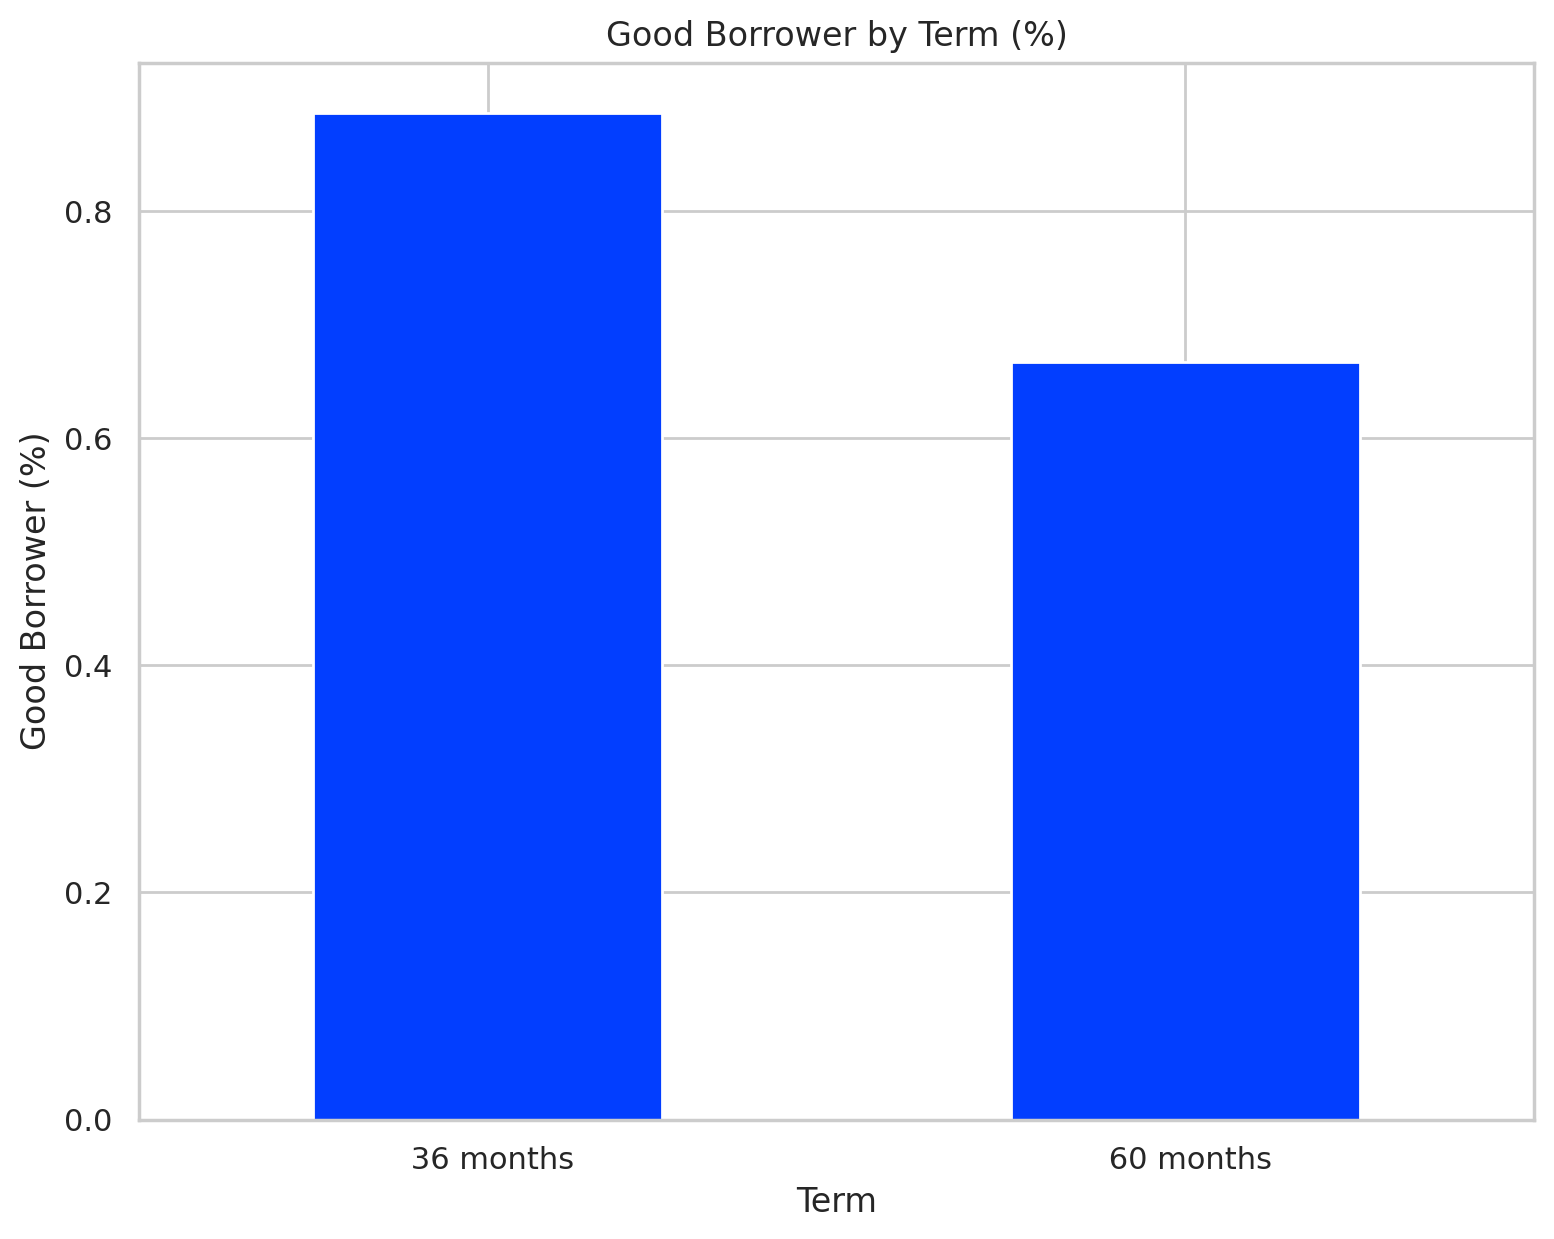

In [50]:
plt.figure(figsize=(9,7),dpi=100)
data.groupby("term")["good_bad"].mean().plot(kind="bar")
plt.title("Good Borrower by Term (%)")
plt.xlabel("Term")
plt.xticks(rotation=0)
plt.ylabel("Good Borrower (%)")

Nasabah dengan masa waktu 36 bulan memiliki prosentase pelunasan lebih tinggi dibandingkan dengan nasabah yang melakukan peminjaman dengan jangka waktu 60 bulan, sehingga diperlukan pengawasan khusus untuk peminjaman dengan jangka waktu lebih dari 36 bulan

In [51]:
data.groupby("term").median().T

term                36 months    60 months
last_pymnt_amnt    568.320000   5367.57000
total_rec_prncp   7800.000000  13200.00000
total_pymnt_inv   8765.960000  17514.40000
total_pymnt       8801.126716  17663.05498
int_rate            10.650000     15.99000
dti                 13.595000     14.71000
revol_util          53.500000     57.90000
annual_inc       57000.000000  66000.00000
inq_last_6mths       0.000000      1.00000
total_rec_int     1038.225000   4051.02000
funded_amnt       8000.000000  17500.00000
loan_amnt         8000.000000  18000.00000
funded_amnt_inv   8000.000000  17375.00000
installment        269.570000    419.16000
good_bad             1.000000      1.00000

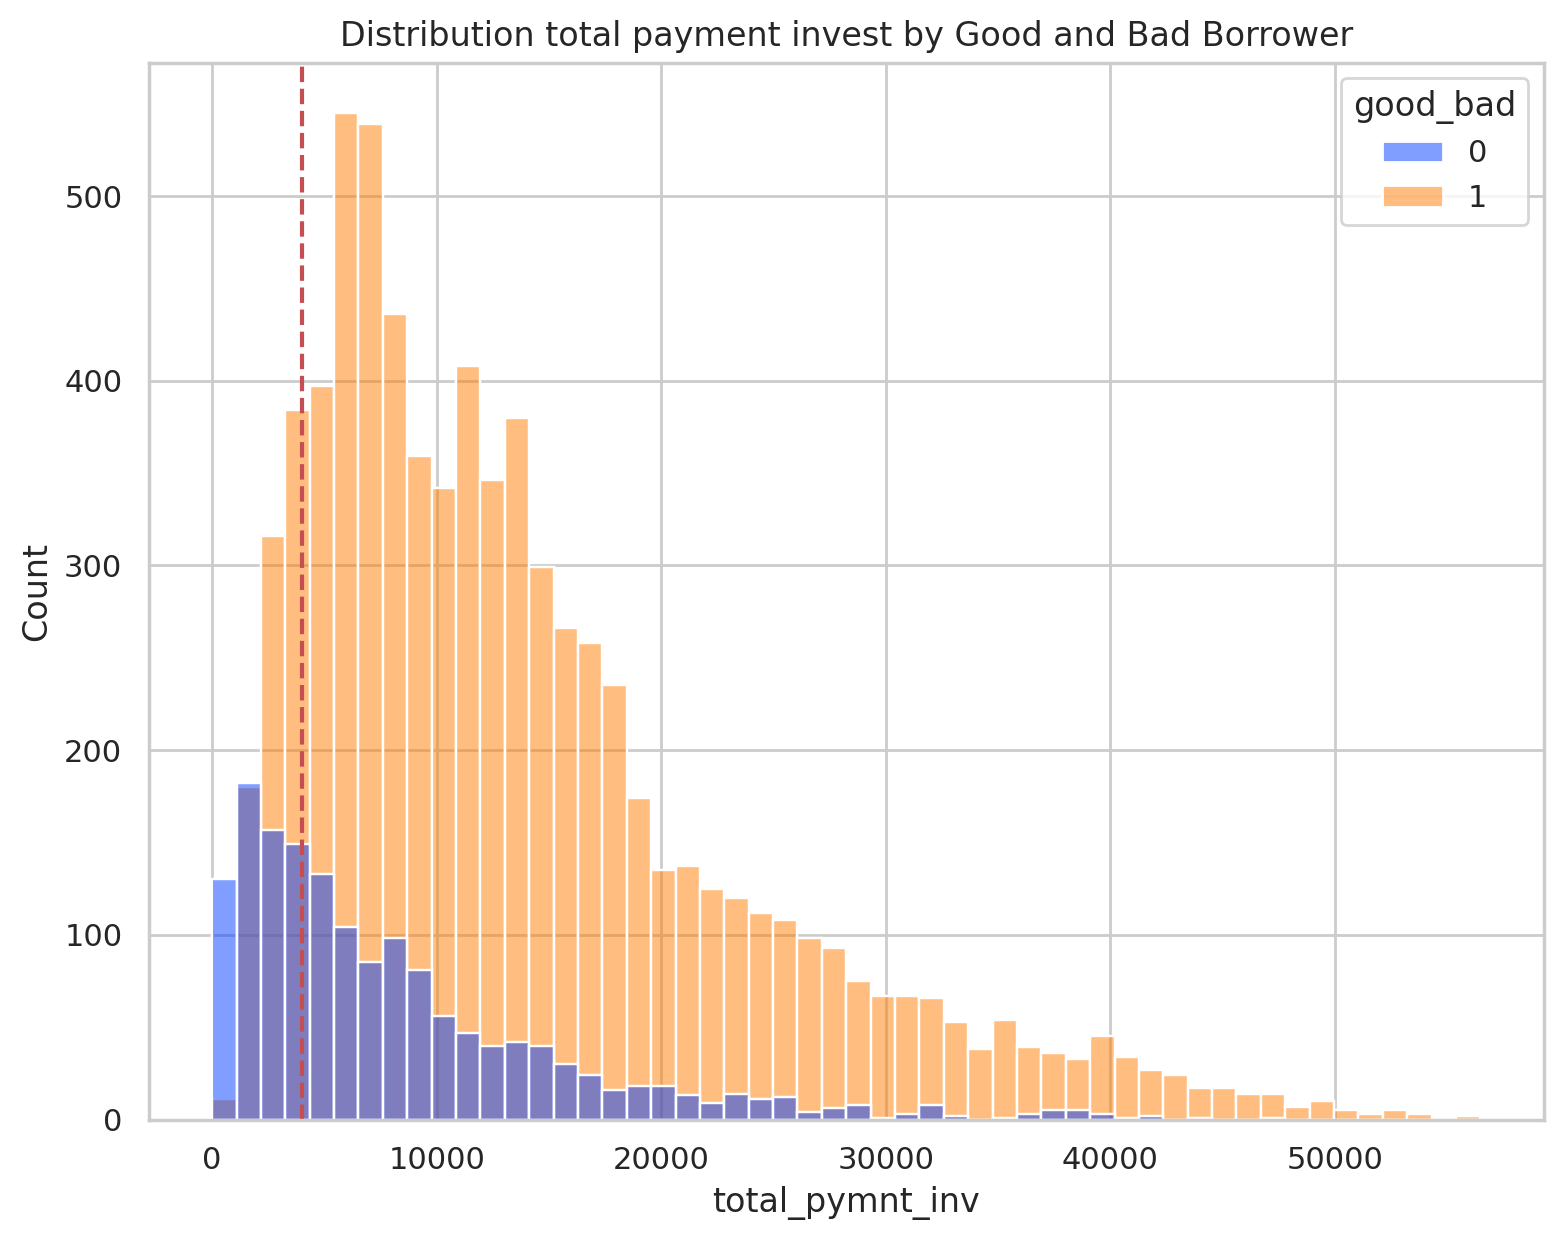

In [52]:
plt.figure(figsize=(9,7),dpi=100)
sns.histplot(data=data,x='total_pymnt_inv',hue='good_bad')
plt.axvline(x=4000,color='r',linestyle="--")
plt.title("Distribution total payment invest by Good and Bad Borrower");

distribusi total payment invest dari **bad dan good borrower**, diatas 4000 dan semakin besarnya total payment maka invest frekuensi **bad borrower** semakin kecil

Text(0.5, 1.0, 'Boxplot Interest Rate')

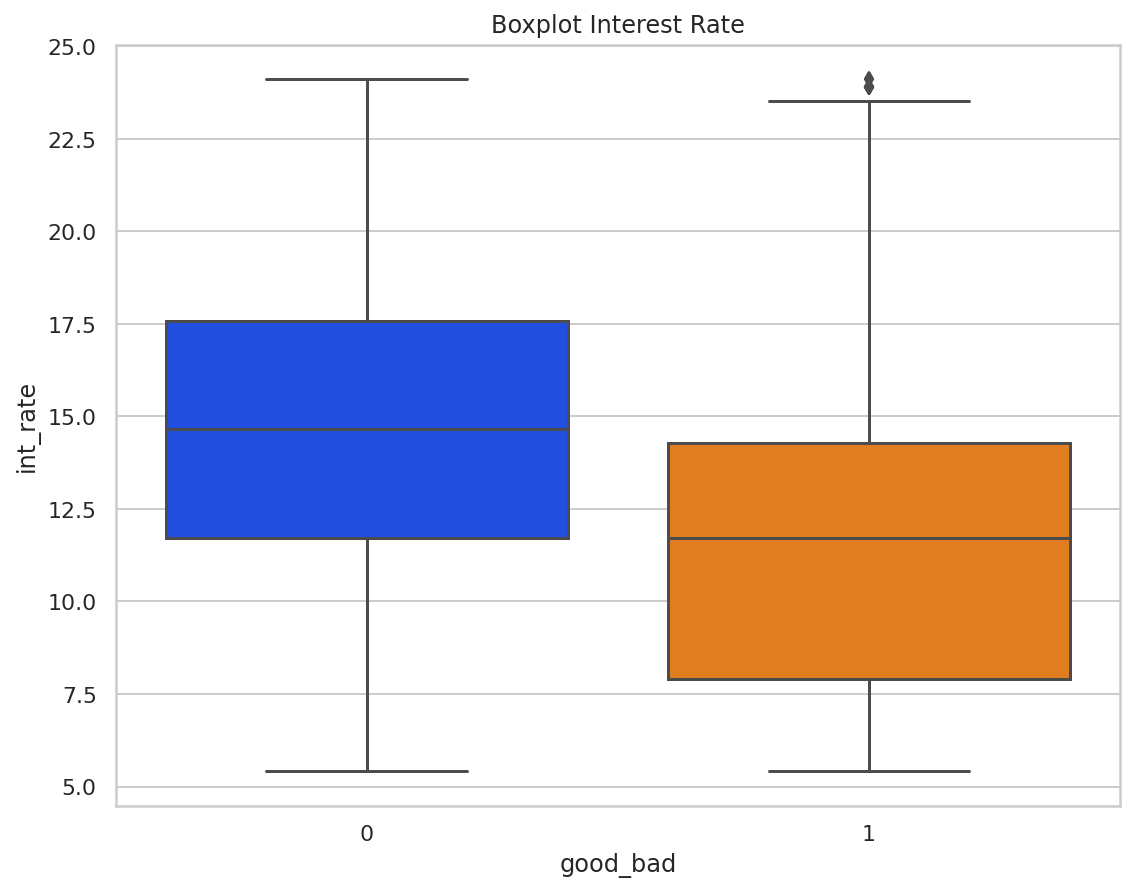

In [53]:
plt.figure(figsize=(9,7))
sns.boxplot(data=data,x='good_bad',y='int_rate')
plt.title('Boxplot Interest Rate')

interval interest rate **bad borrower** lebih besar daripada dengan **good borrower**

In [54]:
sns.pairplot(data,hue="good_bad")

Error in callback <function flush_figures at 0x7fbcda4e7290> (for post_execute):


KeyboardInterrupt: ignored

# Preprocessing

In [58]:
#transsform to woe
df = sc.woebin_ply(df, bins)

[INFO] converting into woe values ...


ValueError: ignored

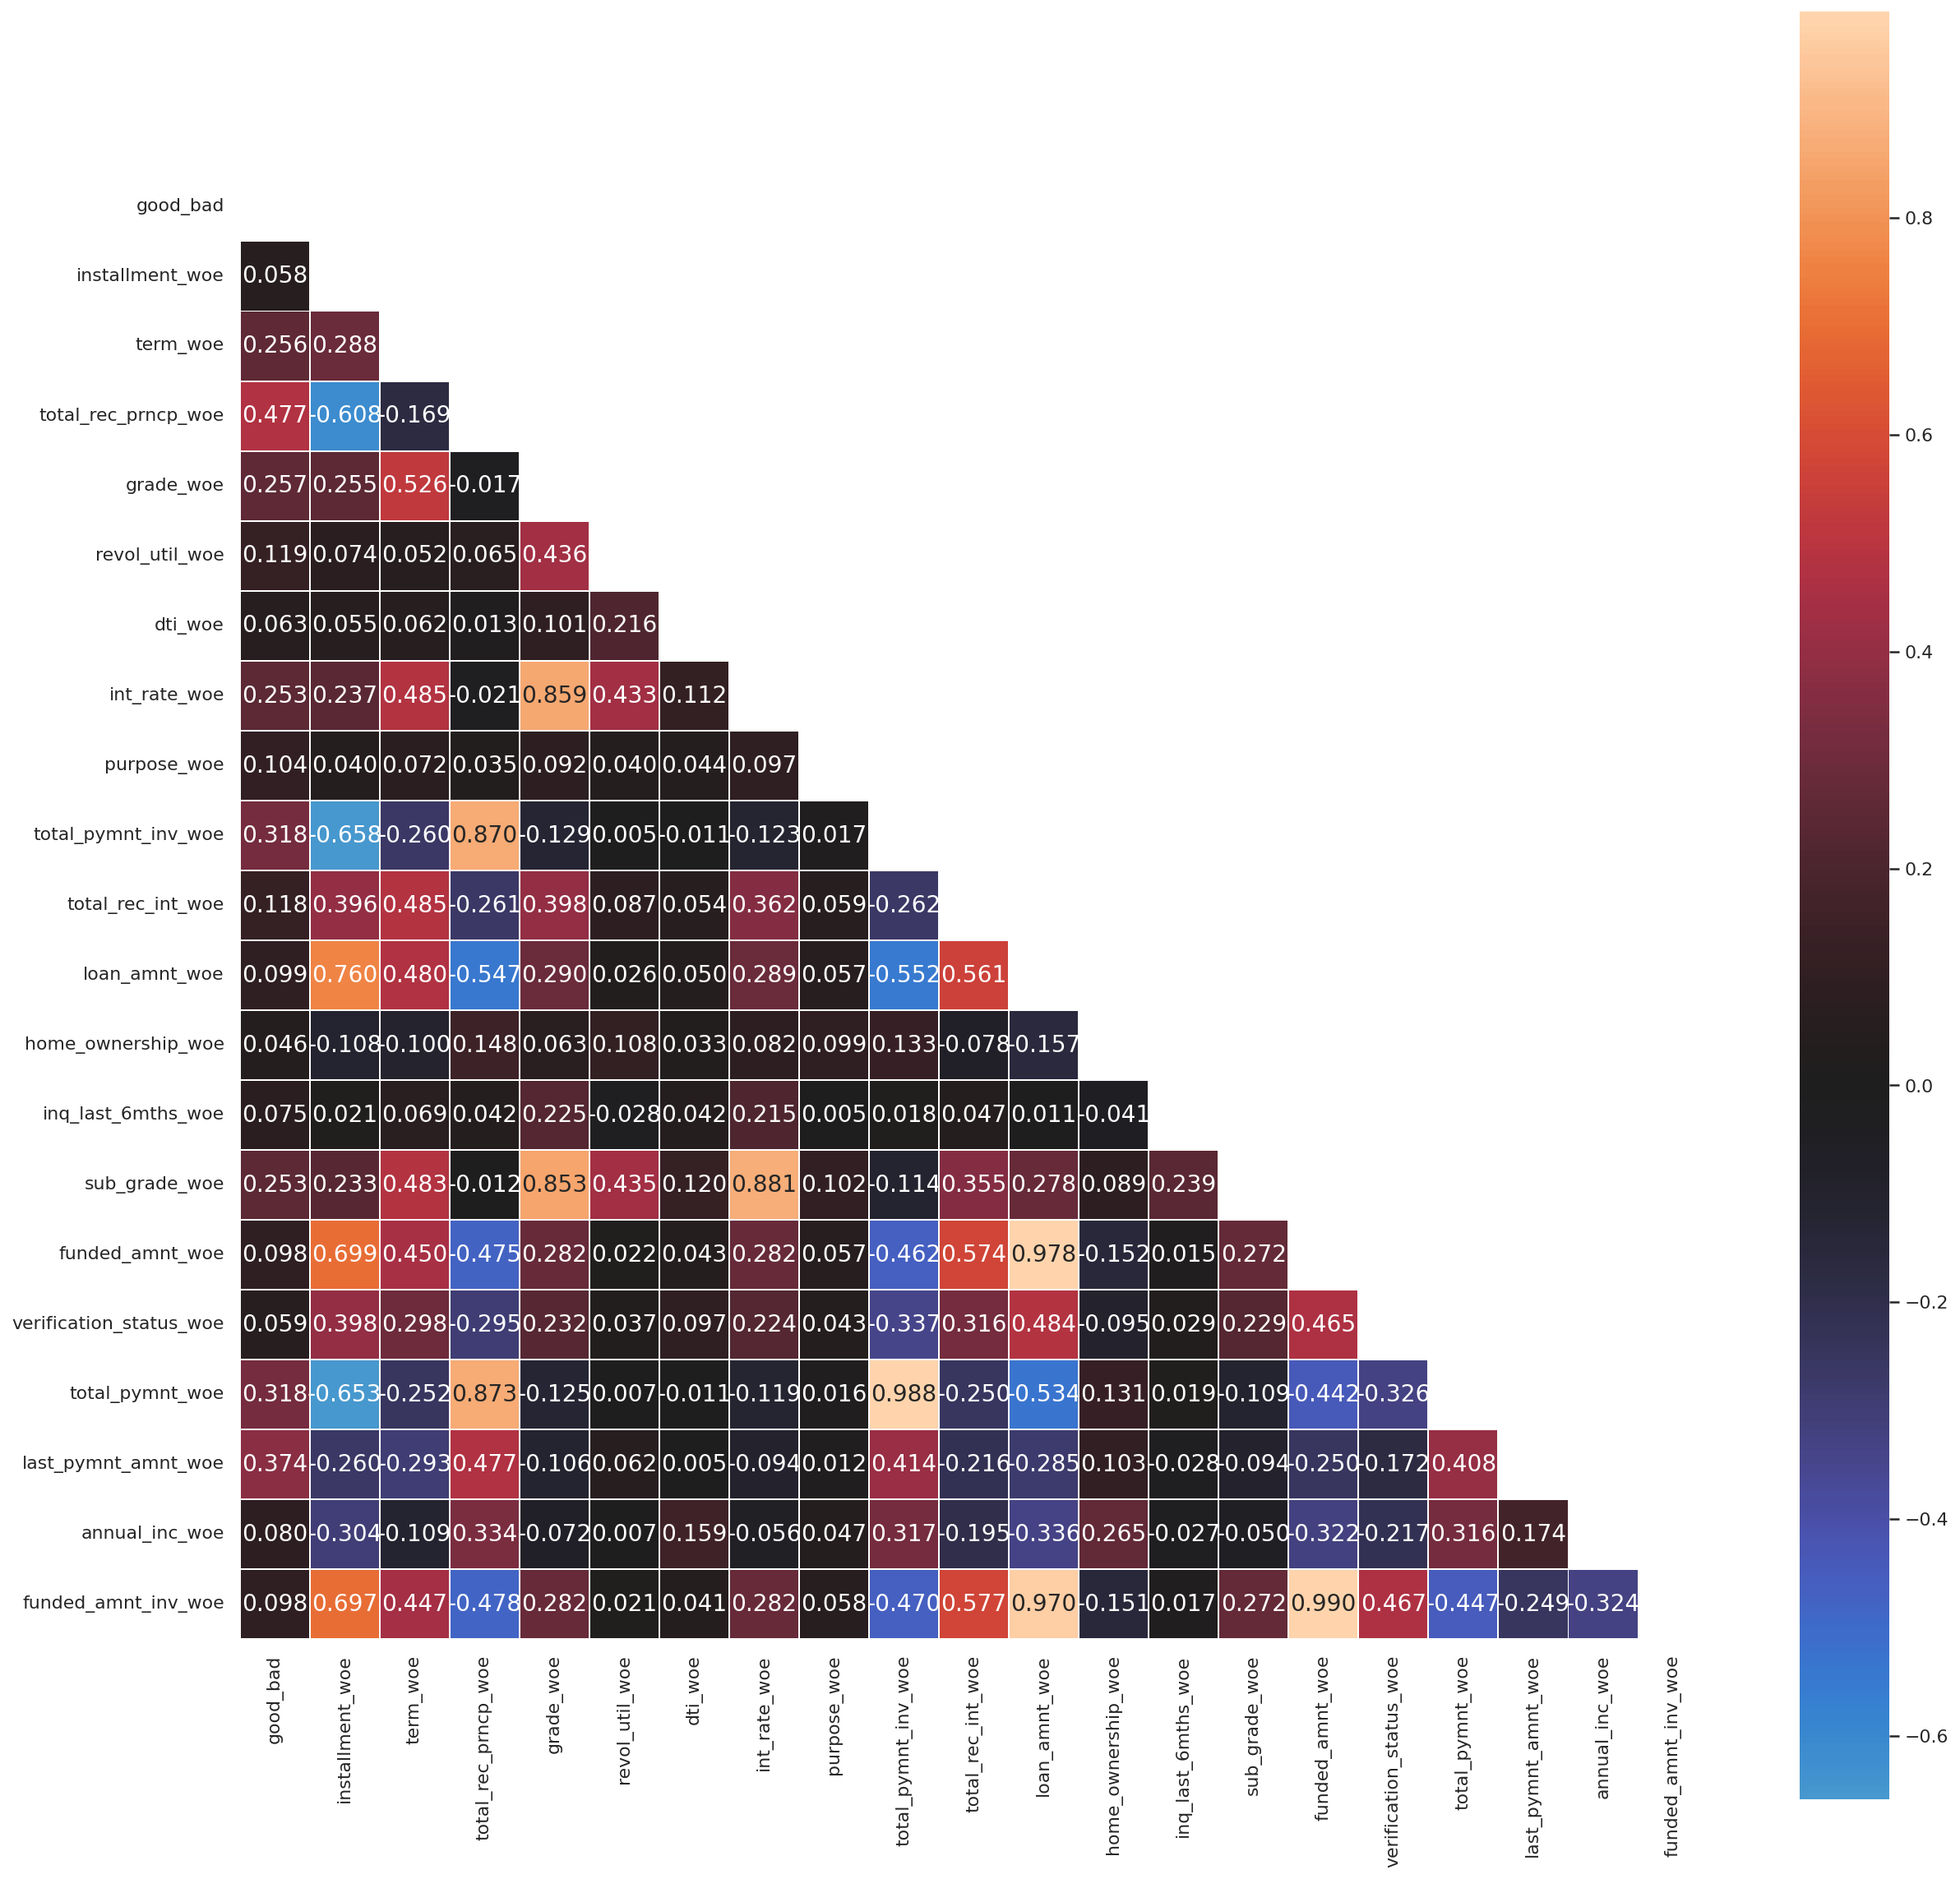

In [59]:
fig = plt.figure(figsize = (20,20))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), center = 0,
           fmt='.3f', square = True,
           annot = True, linewidth = 0.3, mask = matrix)
plt.show()

seperti yang terlihat pada heatmap, beberapa fitur memiliki korelasi yang begitu kuat dengan fitur yang lainnya, sehingga terjadi multicolinearity. akan dilakukan filtering fitur dengan threshold >= absolute(0.95) dianggap sebagai multicolinearity, multicolinearity akan dihandle dengan metode RFE (recursive feature elimination)

# Model Building

In [60]:
X = df.drop("good_bad",axis=1).copy()
y = df['good_bad'].copy()


X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=42)

In [61]:
X_train.shape

(6384, 20)

In [62]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

preds = logreg.predict(X_train)

accuracy = accuracy_score(preds,y_train)
print(accuracy)

0.9345238095238095


In [63]:
preds_test = logreg.predict(X_test)

accuracy = accuracy_score(preds_test,y_test)
print(accuracy)

0.9386189258312021


In [64]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,logreg.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logistic Regression on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logistic Regression on val data: ', round(gini_value*100, 2), '%')

AUC for Logistic Regression on val data:  96.93 %
Gini for Logistic Regression on val data:  93.86 %


In [65]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logistic Regression on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logistic Regression on val data: ', round(gini_value*100, 2), '%')

AUC for Logistic Regression on val data:  96.43 %
Gini for Logistic Regression on val data:  92.86 %


              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1094
           1       0.95      0.97      0.96      5290

    accuracy                           0.93      6384
   macro avg       0.89      0.87      0.88      6384
weighted avg       0.93      0.93      0.93      6384



Text(30.5, 0.5, 'Realita')

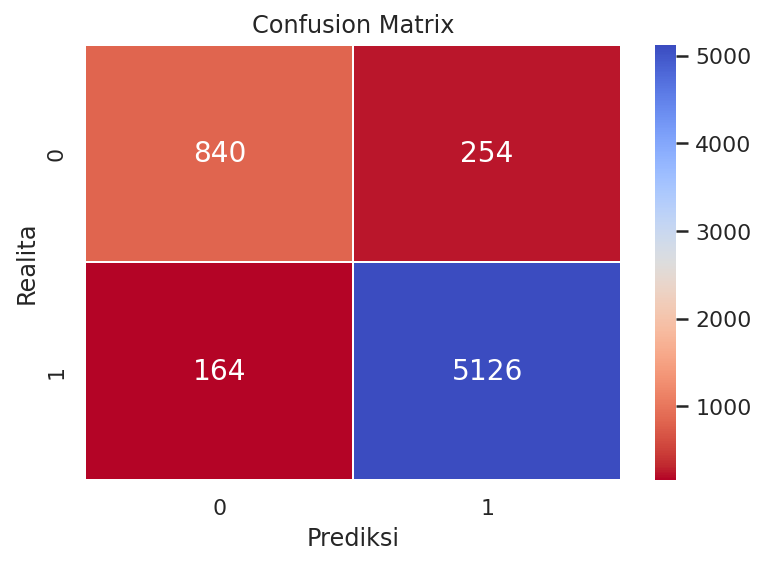

In [66]:
y_train_pred = logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
print(metrics.classification_report(y_train, y_train_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       469
           1       0.95      0.97      0.96      2268

    accuracy                           0.94      2737
   macro avg       0.91      0.87      0.89      2737
weighted avg       0.94      0.94      0.94      2737



Text(30.5, 0.5, 'Realita')

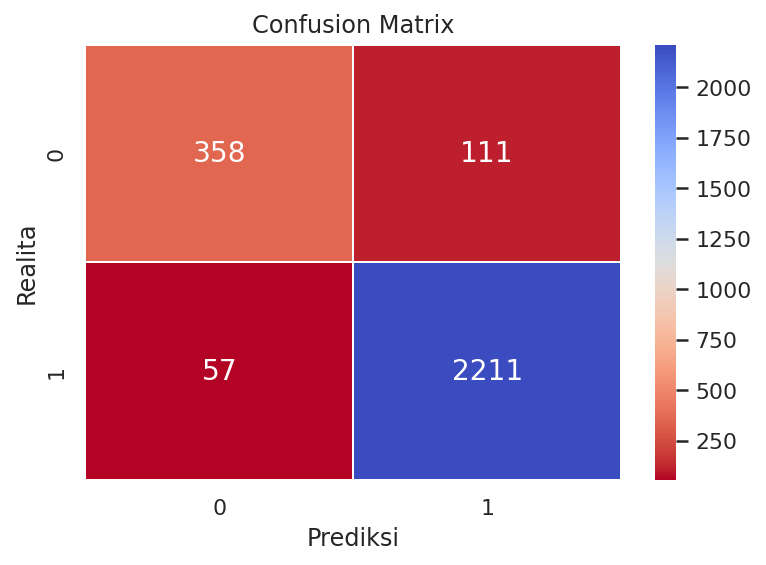

In [67]:
y_test_pred = logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
print(metrics.classification_report(y_test,y_test_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [68]:
#recursive Elimination
from sklearn.feature_selection import RFE
model = LogisticRegression(solver='lbfgs', max_iter=500)
rfe = RFE(model)
rfe = rfe.fit(X_train, y_train)

In [69]:
X_train.columns[rfe.support_]

Index(['installment_woe', 'term_woe', 'total_rec_prncp_woe', 'dti_woe',
       'total_rec_int_woe', 'loan_amnt_woe', 'funded_amnt_woe',
       'verification_status_woe', 'last_pymnt_amnt_woe',
       'funded_amnt_inv_woe'],
      dtype='object')

In [70]:
X_train_new = X_train[X_train.columns[rfe.support_]]
X_test_new = X_test[X_test.columns[rfe.support_]]

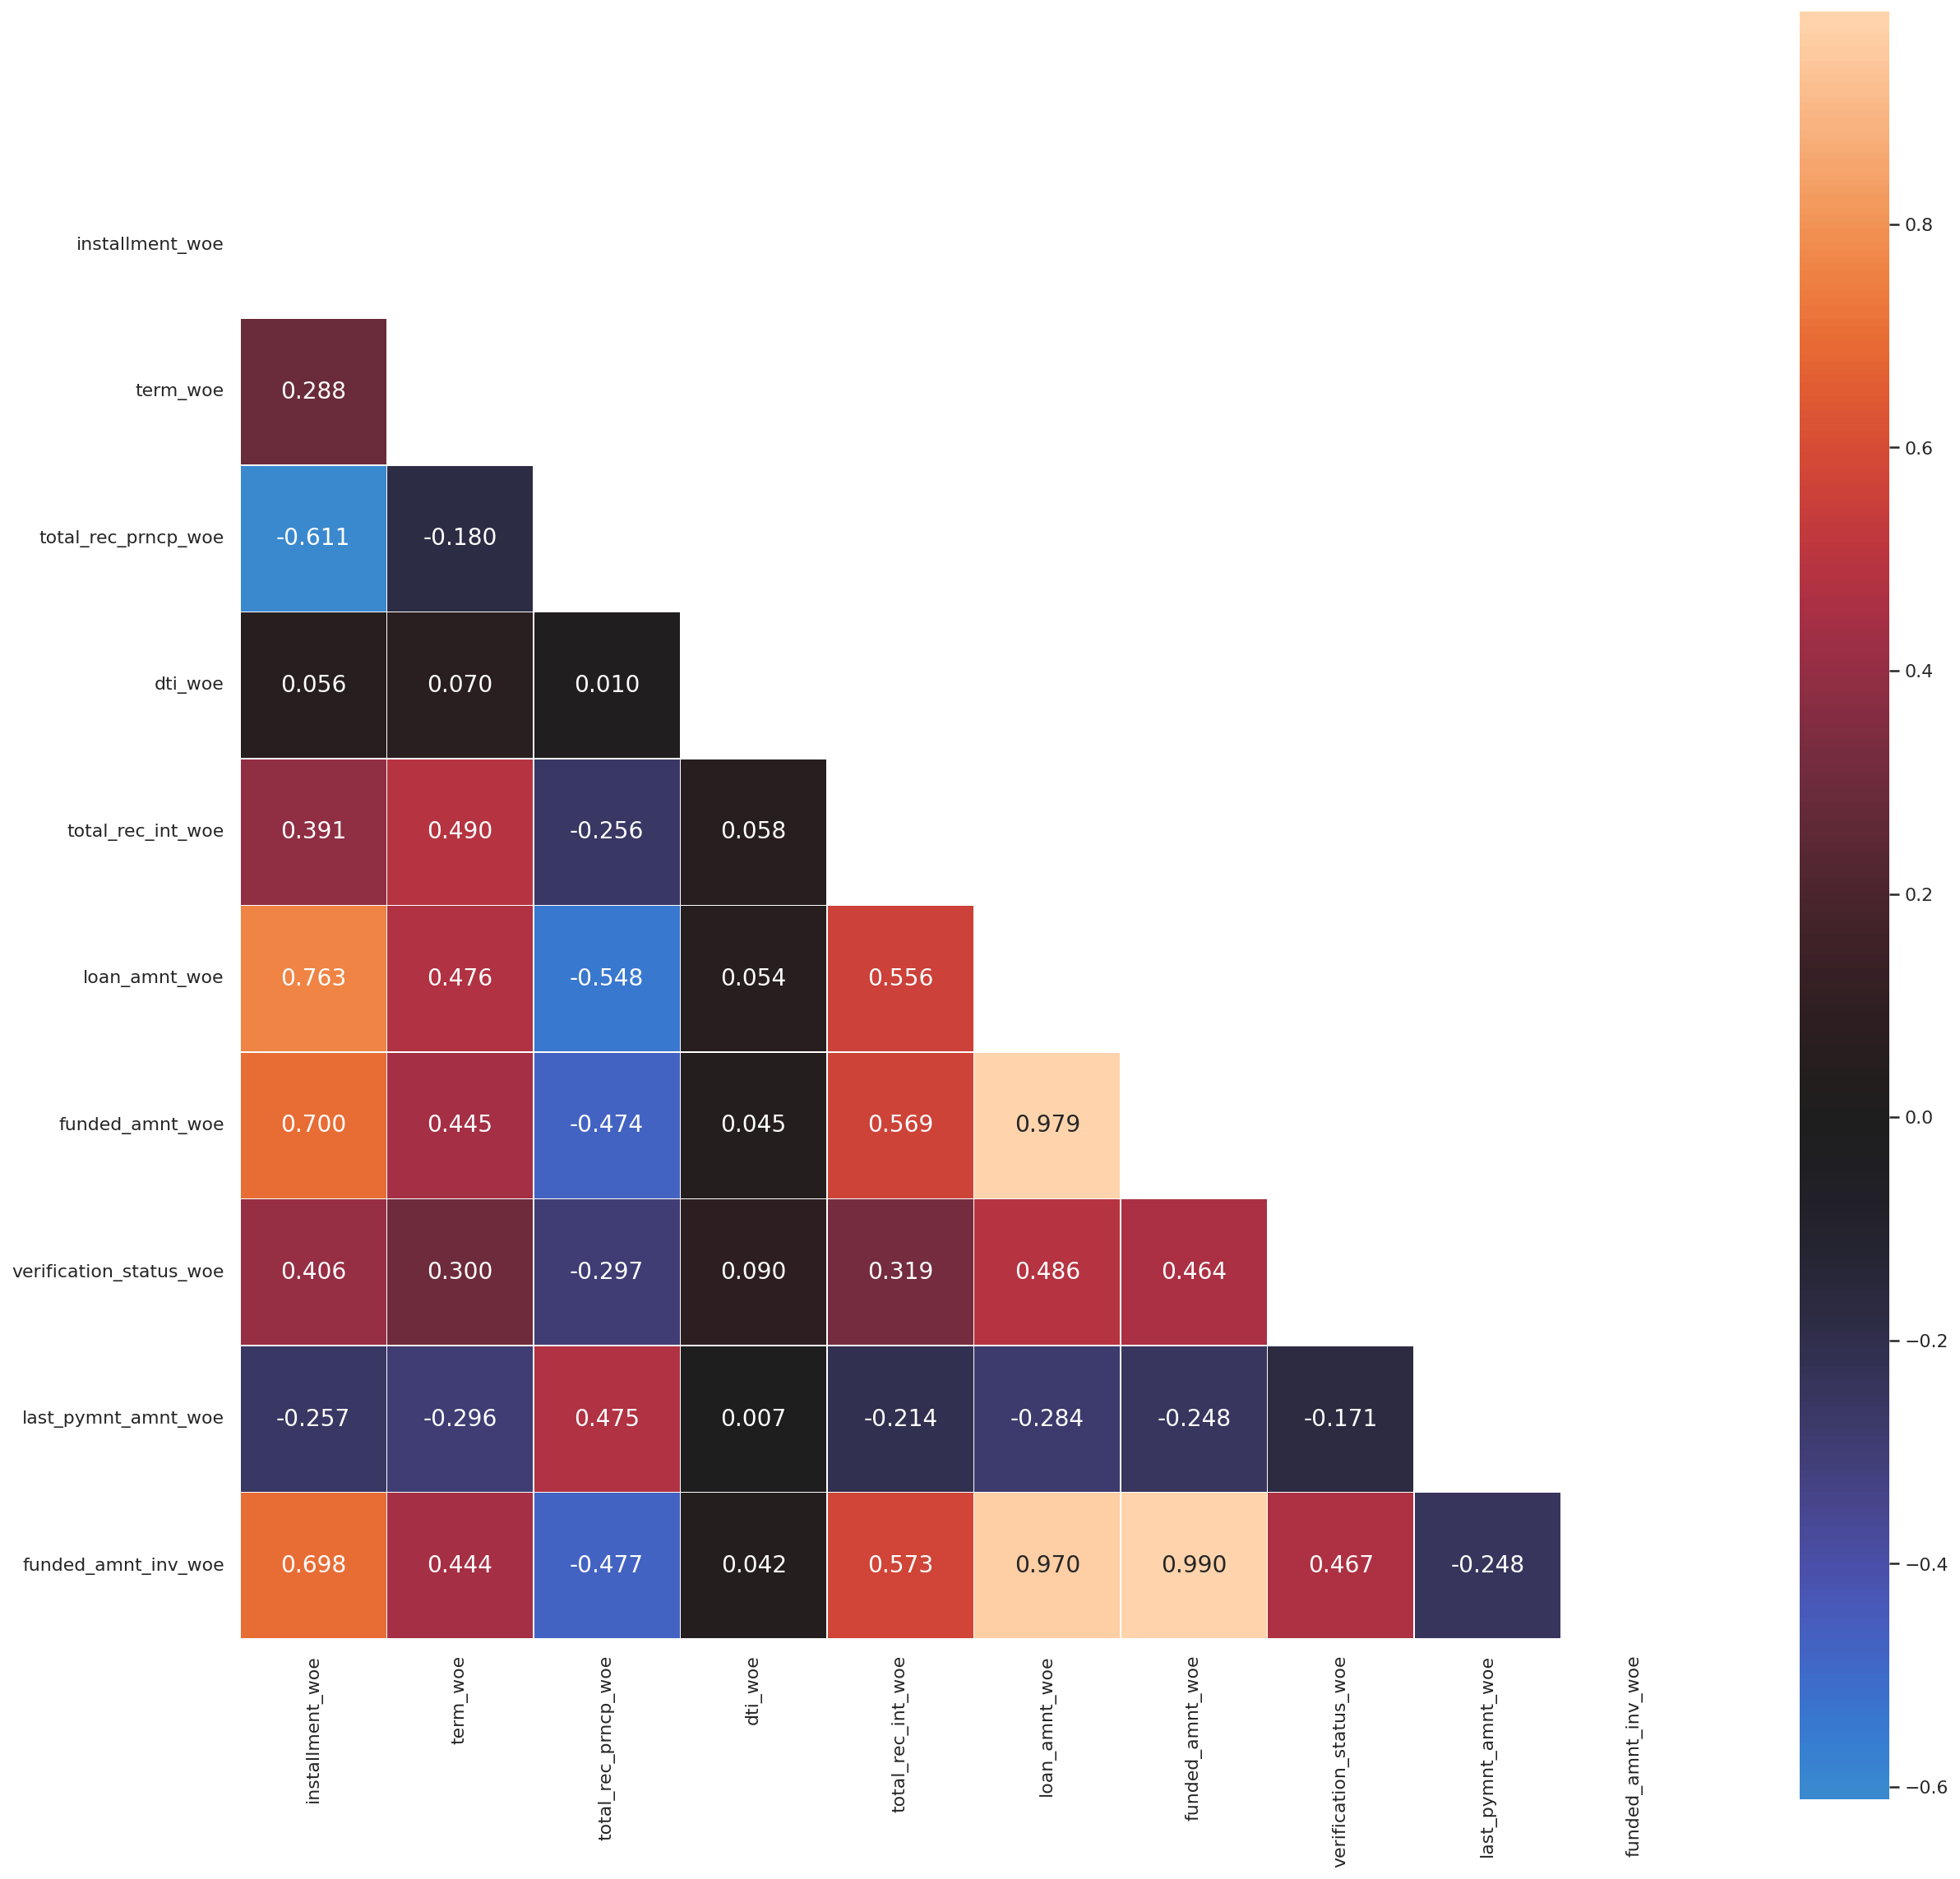

In [71]:
fig = plt.figure(figsize = (20,20))
matrix = np.triu(X_train_new.corr())
sns.heatmap(X_train_new.corr(), center = 0,
           fmt='.3f', square = True,
           annot = True, linewidth = 0.3, mask = matrix)
plt.show()

In [74]:
#seperti yang terlihat pada heatmap ada fitur yang berkolerasi diatas 0.95
#fitur yang di take out ada fitur yang memiliki nilai IV terendah

drop_feat = ["total_pymnt_inv_woe","funded_amnt_inv_woe"]


X_train_new = X_train_new.drop(drop_feat,axis=1)
X_test_new = X_test_new.drop(drop_feat,axis=1)

KeyError: ignored

In [73]:

param_grid = {"penalty": ["l1","l2"],
             'C' : [1.0,2.0,3.0],
             'max_iter':[100,200,300,500],
             'solver' : ['newton-cg','lbfgs','sag','saga','liblinear'],
             }

model = LogisticRegression()#class_weight="balanced")
grid_search = RandomizedSearchCV(model,param_grid,cv=5)
grid_search.fit(X_train_new,y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [1.0, 2.0, 3.0],
                                        'max_iter': [100, 200, 300, 500],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga', 'liblinear']})

In [75]:
grid_search.best_params_

{'C': 3.0, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

In [76]:
y_train_pred = grid_search.best_estimator_.predict(X_train_new)
y_test_pred = grid_search.best_estimator_.predict(X_test_new)

In [77]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,grid_search.predict_proba(X_train_new)[:,1])
roc_auc_value = roc_auc_score(y_train, grid_search.predict_proba(X_train_new)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logistic Regression on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logistic Regression on val data: ', round(gini_value*100, 2), '%')

AUC for Logistic Regression on val data:  96.89 %
Gini for Logistic Regression on val data:  93.78 %


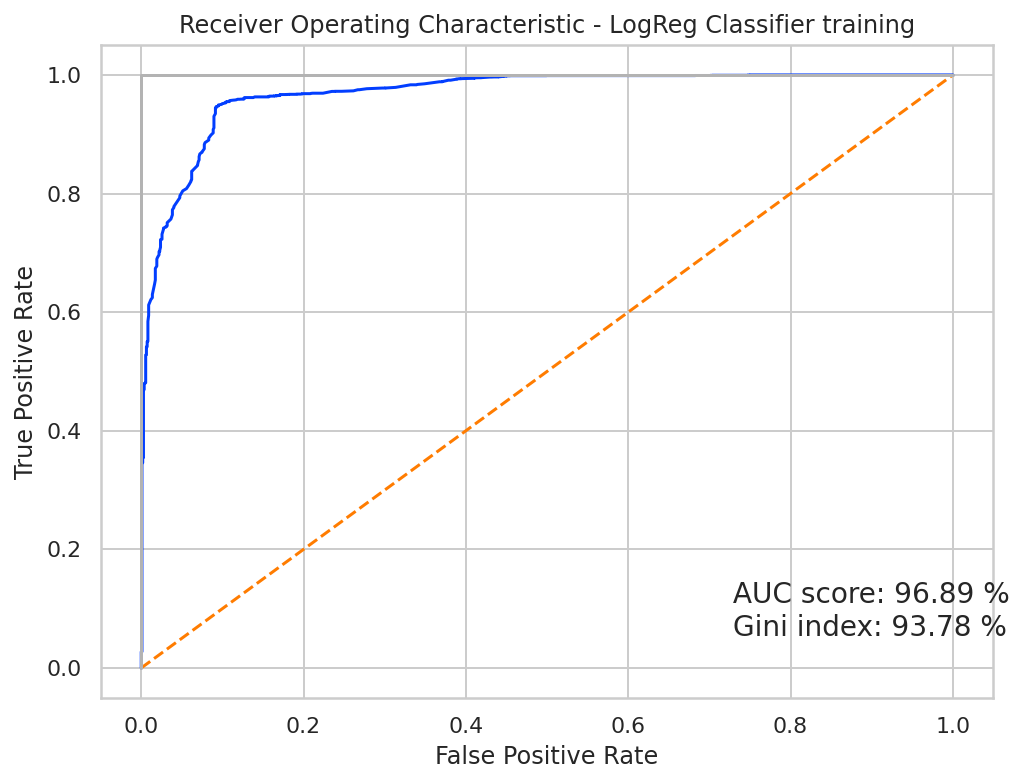

In [78]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - LogReg Classifier training')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.text(ax.get_xlim()[1]*6/10, 
         0, 
         f"""\n
         AUC score: {round(roc_auc_value*100, 2)} %
         Gini index: {round(gini_value*100, 2)} %
         """)

plt.show()

In [79]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,grid_search.predict_proba(X_test_new)[:,1])
roc_auc_value = roc_auc_score(y_test, grid_search.predict_proba(X_test_new)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logistic Regression on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logistic Regression on val data: ', round(gini_value*100, 2), '%')

AUC for Logistic Regression on val data:  96.27 %
Gini for Logistic Regression on val data:  92.54 %


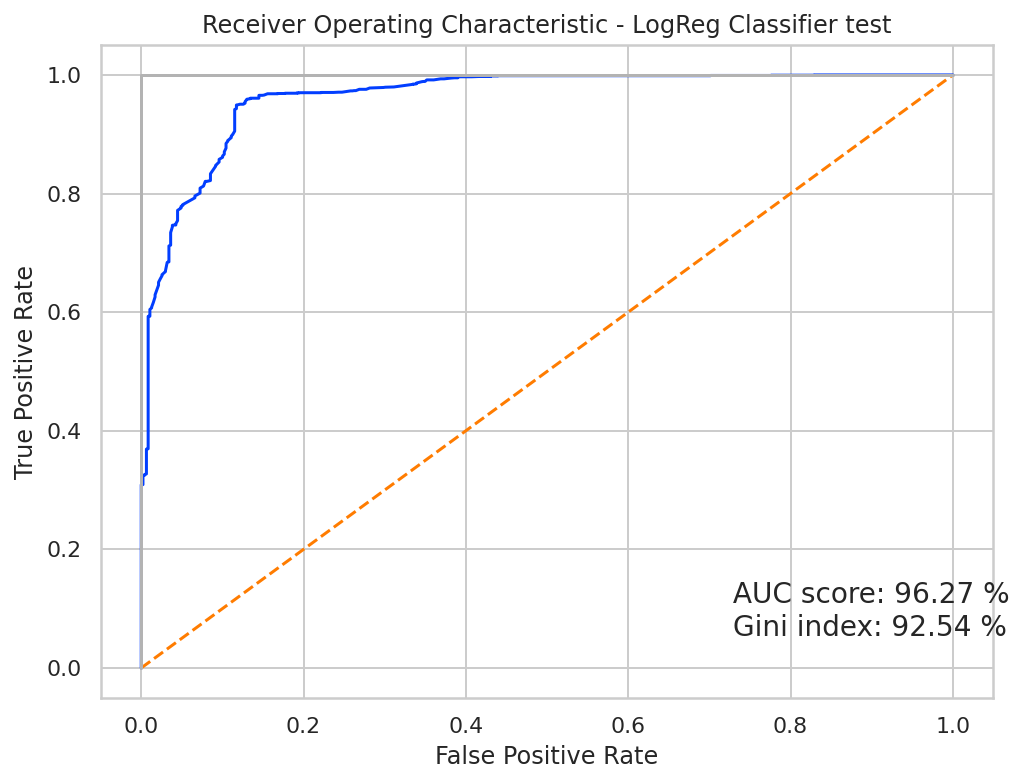

In [80]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - LogReg Classifier test')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.text(ax.get_xlim()[1]*6/10, 
         0, 
         f"""\n
         AUC score: {round(roc_auc_value*100, 2)} %
         Gini index: {round(gini_value*100, 2)} %
         """)

plt.show()

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1094
           1       0.96      0.97      0.97      5290

    accuracy                           0.94      6384
   macro avg       0.90      0.89      0.90      6384
weighted avg       0.94      0.94      0.94      6384



Text(30.5, 0.5, 'Realita')

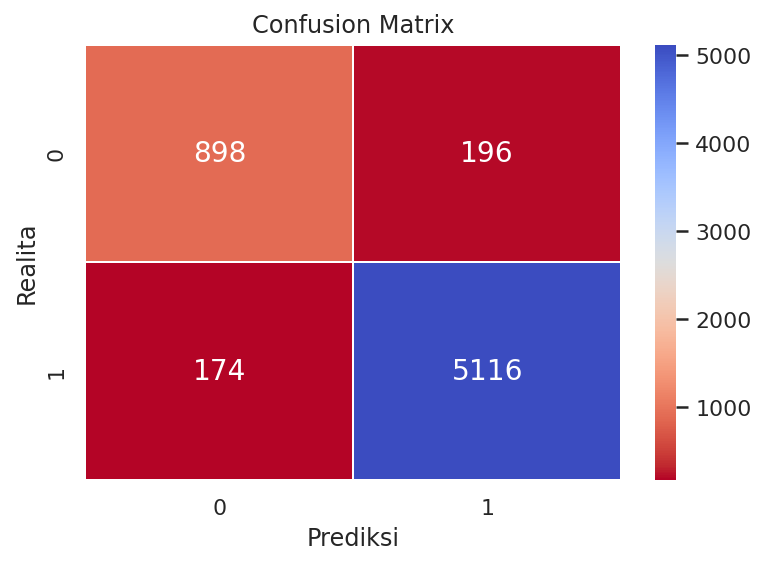

In [81]:
y_train_pred = grid_search.predict(X_train_new)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
print(metrics.classification_report(y_train, y_train_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       469
           1       0.96      0.97      0.96      2268

    accuracy                           0.94      2737
   macro avg       0.90      0.89      0.89      2737
weighted avg       0.94      0.94      0.94      2737



Text(30.5, 0.5, 'Realita')

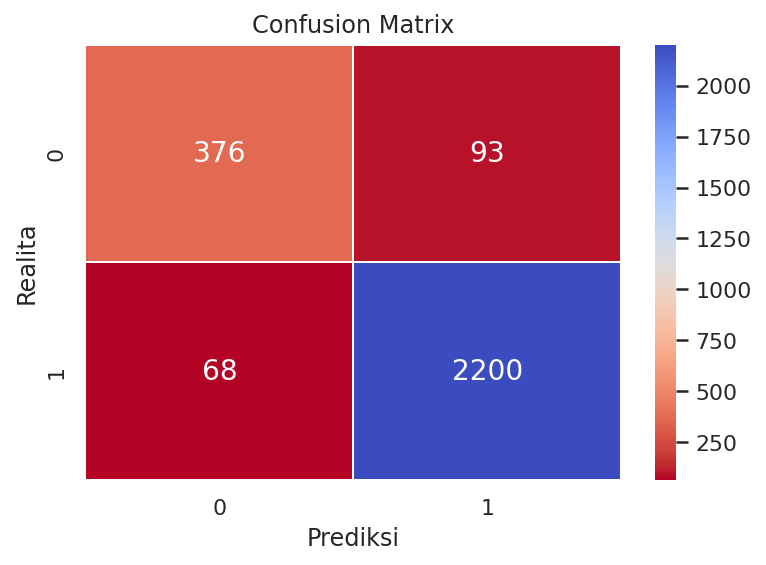

In [82]:
y_test_pred = grid_search.predict(X_test_new)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
print(metrics.classification_report(y_test,y_test_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

Dari hasil model, terlihat bahwa Bad borrower masih cukup banyak yang terhitung sebagai good borrowe sehingga kita perlu menurunkan hal ini, dengan cara mencari cut proba terbaik untuk meningkatkan recall dari model

### Cut Off

In [95]:
data_train = pd.DataFrame()
data_test = pd.DataFrame()

In [96]:
data_train["proba"] = grid_search.predict_proba(X_train_new)[:,1]
data_test["proba"] = grid_search.predict_proba(X_test_new)[:,1]

In [97]:
data_train["label"] = pd.DataFrame(y_train).reset_index(drop=True)
data_test["label"] = pd.DataFrame(y_test).reset_index(drop=True)

In [98]:
data_test_split_proba = data_test[['label', 'proba']]
data_test_split_proba['bins'] = pd.qcut(data_test_split_proba['proba'], q=8)
#data_test_split_proba['bins'] = pd.cut(data_test_split_proba['proba'], bins=[0.010499999999999999, 0.085, 0.188, 0.331, 0.4,0.548, 0.943])
data_test_split_proba.head()

label     proba                               bins
0      0  0.000862  (-8.346100000000001e-06, 0.34347]
1      1  0.960023                 (0.94342, 0.97354]
2      1  0.999413                  (0.9992, 0.99982]
3      1  0.924115                 (0.91388, 0.94342]
4      1  0.999963                 (0.99982, 0.99997]

In [99]:
cnt_per_bin2 = data_test_split_proba.bins.value_counts().to_frame().reset_index().rename(columns={'bins':'cnt_debtors'}).sort_values('index')
cnt_per_bin2.head()

index  cnt_debtors
2  (-8.346100000000001e-06, 0.34347]          344
1                 (0.34347, 0.91388]          345
6                 (0.91388, 0.94342]          338
0                 (0.94342, 0.97354]          360
7                  (0.97354, 0.9992]          325

In [100]:
bad_per_bin2 = data_test_split_proba.groupby(['bins','label']).count().reset_index().rename(columns={'proba':'cnt_bad_debtors'})
bad_per_bin2 = bad_per_bin2[bad_per_bin2['label']==0]
bad_per_bin2.head()

bins  label  cnt_bad_debtors
0  (-8.346100000000001e-06, 0.34347]      0              310
2                 (0.34347, 0.91388]      0              110
4                 (0.91388, 0.94342]      0               31
6                 (0.94342, 0.97354]      0               13
8                  (0.97354, 0.9992]      0                1

In [101]:
summary2 = bad_per_bin2.merge(cnt_per_bin2, how='inner', right_on='index', left_on='bins')
summary2['pct_bad_average'] = round((summary2['cnt_bad_debtors'] / summary2['cnt_debtors'])*100 , 2)
summary2.head()

bins  label  cnt_bad_debtors  \
0  (-8.346100000000001e-06, 0.34347]      0              310   
1                 (0.34347, 0.91388]      0              110   
2                 (0.91388, 0.94342]      0               31   
3                 (0.94342, 0.97354]      0               13   
4                  (0.97354, 0.9992]      0                1   

                               index  cnt_debtors  pct_bad_average  
0  (-8.346100000000001e-06, 0.34347]          344            90.12  
1                 (0.34347, 0.91388]          345            31.88  
2                 (0.91388, 0.94342]          338             9.17  
3                 (0.94342, 0.97354]          360             3.61  
4                  (0.97354, 0.9992]          325             0.31

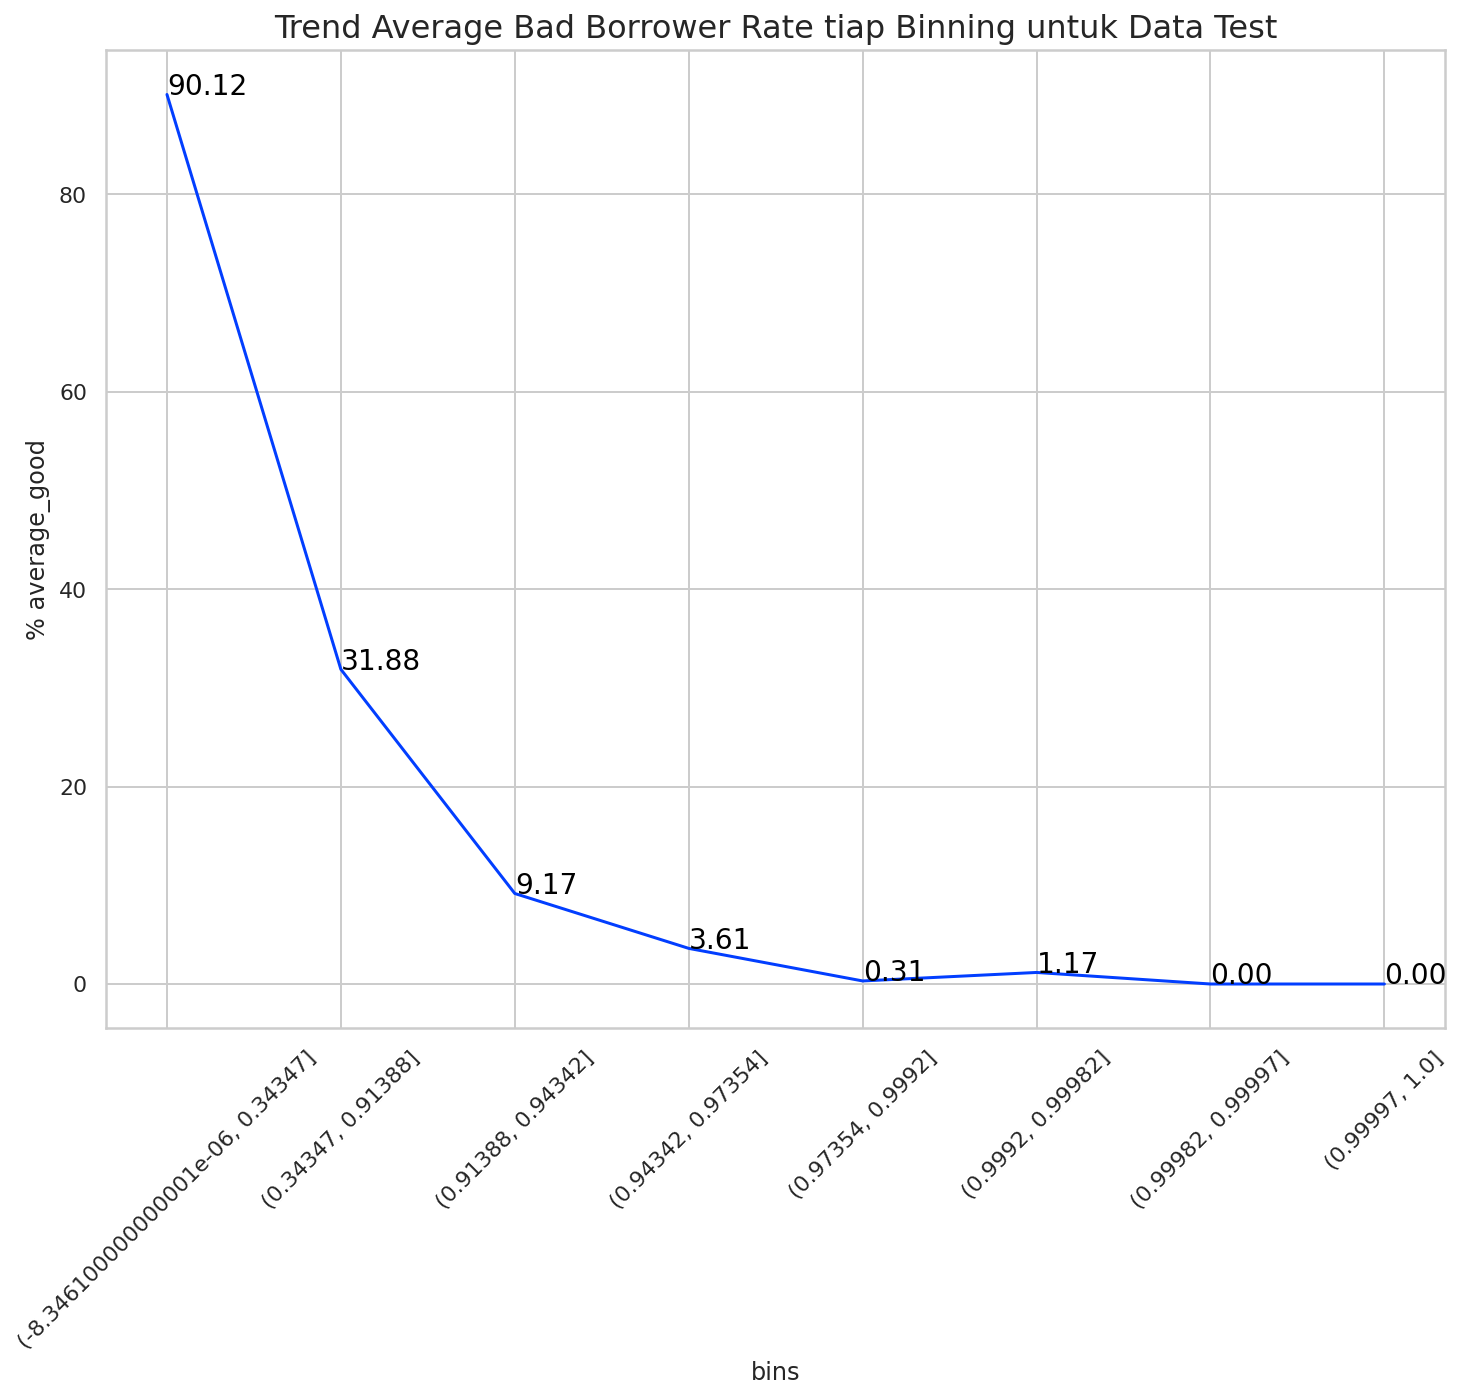

In [102]:
summary2['bins'] = summary2.bins.astype(str)
plt.figure(figsize=(12,9))
sns.lineplot(data = summary2, x='bins', y='pct_bad_average')
plt.xticks(rotation=45)
plt.ylabel('% average_good')
plt.title("Trend Average Bad Borrower Rate tiap Binning untuk Data Test", size=16)
# label points on the plot
for x, y in zip(summary2['bins'], summary2['pct_bad_average']):# the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x, # x-coordinate position of data label
             y = y+0.001,
             s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
             color = 'black') # set colour of line# y

              precision    recall  f1-score   support

           0       0.61      0.92      0.74      1094
           1       0.98      0.88      0.93      5290

    accuracy                           0.89      6384
   macro avg       0.80      0.90      0.83      6384
weighted avg       0.92      0.89      0.90      6384



Text(30.5, 0.5, 'Realita')

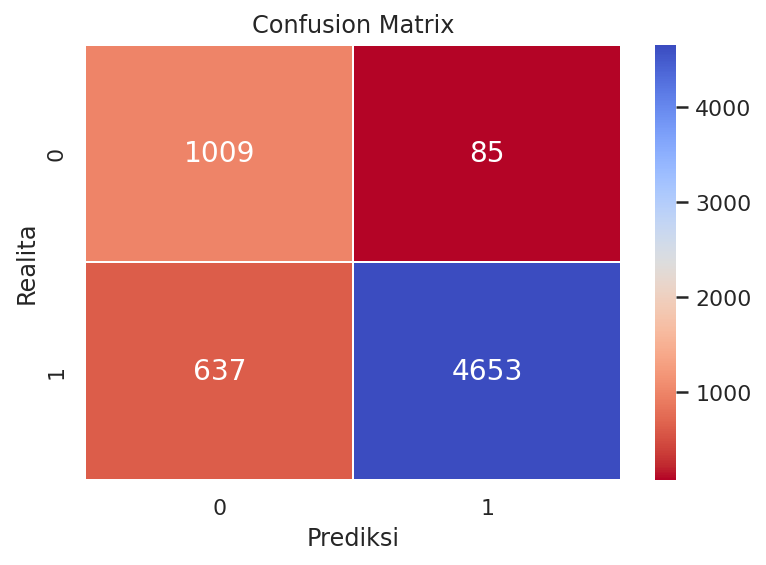

In [103]:
tr = 0.91388
y_train_pred = np.where(grid_search.predict_proba(X_train_new)[:,1]> tr,1,0)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
print(metrics.classification_report(y_train, y_train_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

              precision    recall  f1-score   support

           0       0.61      0.90      0.73       469
           1       0.98      0.88      0.93      2268

    accuracy                           0.88      2737
   macro avg       0.79      0.89      0.83      2737
weighted avg       0.91      0.88      0.89      2737



Text(30.5, 0.5, 'Realita')

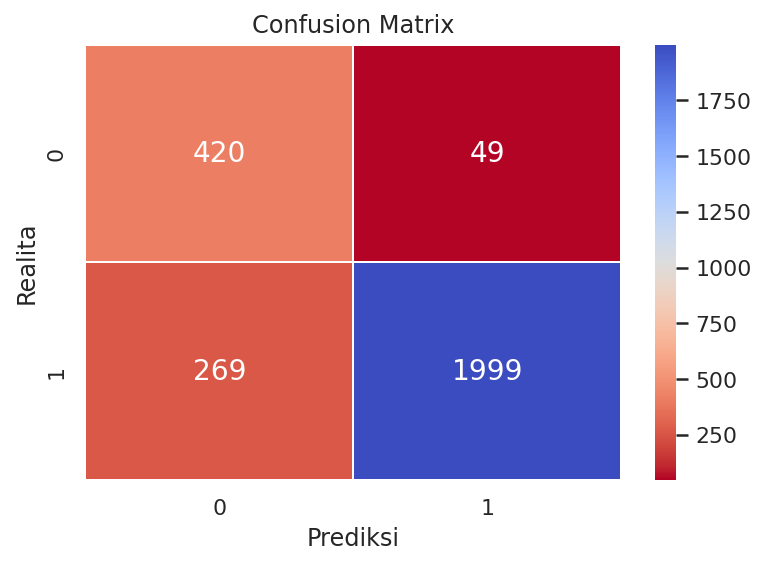

In [104]:
tr = 0.91388
y_test_pred = np.where(grid_search.predict_proba(X_test_new)[:,1]> tr,1,0)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
print(metrics.classification_report(y_test,y_test_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

dengan mengambil titik cut off proba di 0.777, model telah berhasil menurukan nilai dari bad borrower yang terhitung sebagai good borrower dengan sangat baik. hal ini sangat diperlukan mengingat ketika perusahaan telah memiliki nama yang besar maka akan banyak orang yang akan melakukan peminjaman pada perusahaan tersebut jadi kita memerlukan ML yang sangat baik untuk dapat memisahkan mana peminjam yang **Good** dan **Bad** dengan sangat baik

(0.0, 1.0)

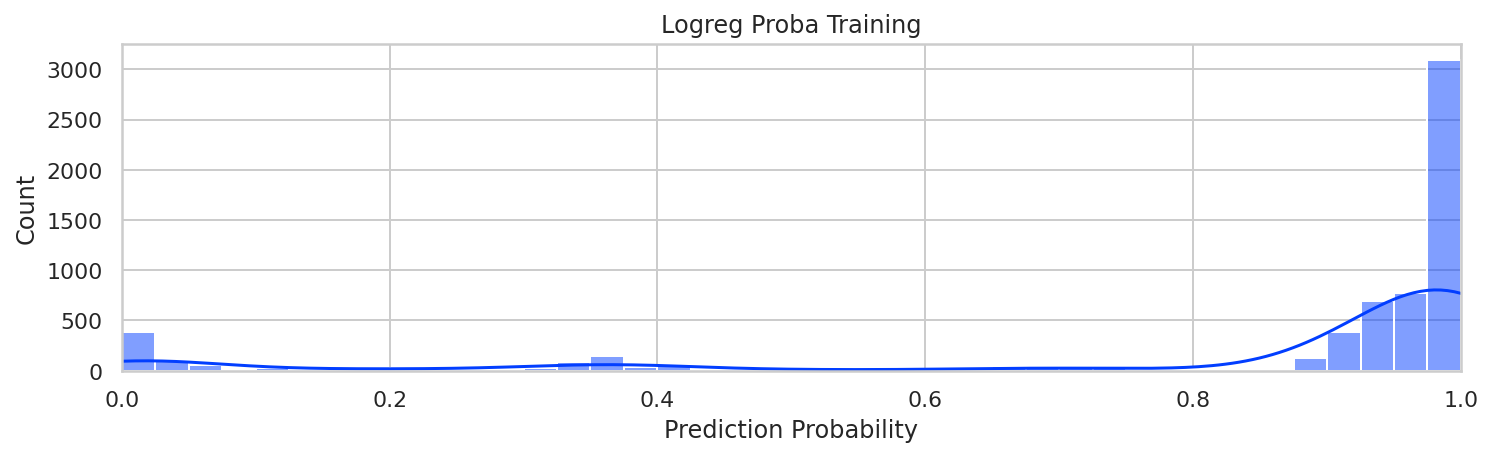

In [105]:
fig, ax = plt.subplots(figsize=(12,3))
sns.histplot(x=grid_search.predict_proba(X_train_new)[:,1],
             binwidth=0.025,
             kde=True,
             ax=ax)

ax.set_title('Logreg Proba Training')
ax.set_xlabel('Prediction Probability')
ax.set_xlim(0,1)

(0.0, 1.0)

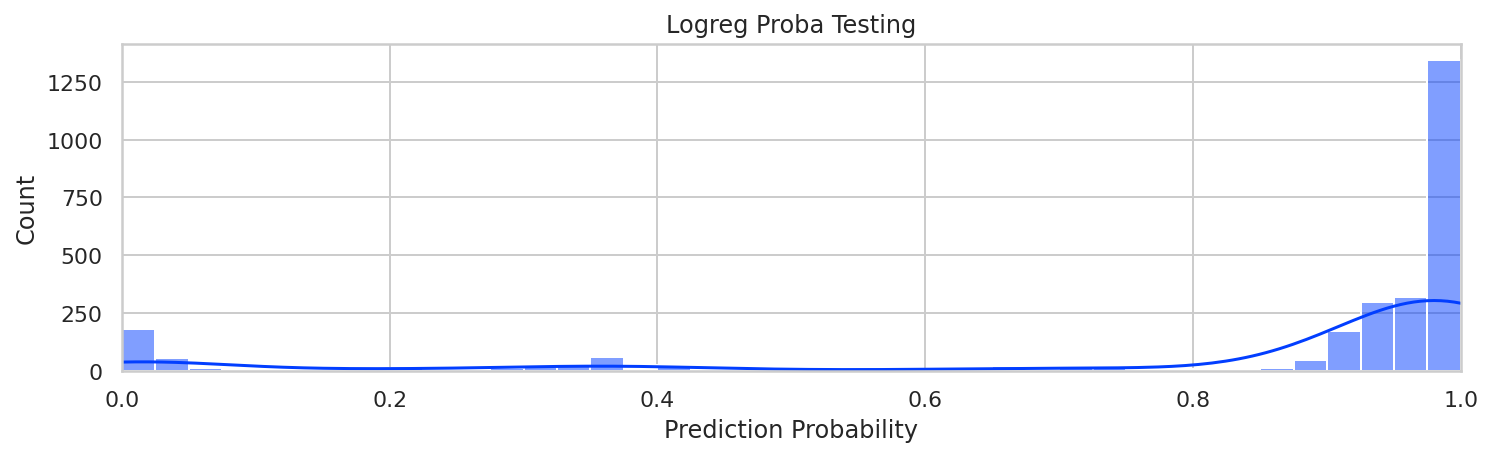

In [107]:
fig, ax = plt.subplots(figsize=(12,3))
sns.histplot(x=grid_search.predict_proba(X_test_new)[:,1],
             binwidth=0.025,
             kde=True,
             ax=ax)

ax.set_title('Logreg Proba Testing')
ax.set_xlabel('Prediction Probability')
ax.set_xlim(0,1)

### Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [109]:
rfc_pred_train = rfc.predict(X_train)
rfc_pred_test = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1094
           1       1.00      1.00      1.00      5290

    accuracy                           1.00      6384
   macro avg       1.00      1.00      1.00      6384
weighted avg       1.00      1.00      1.00      6384



Text(30.5, 0.5, 'Realita')

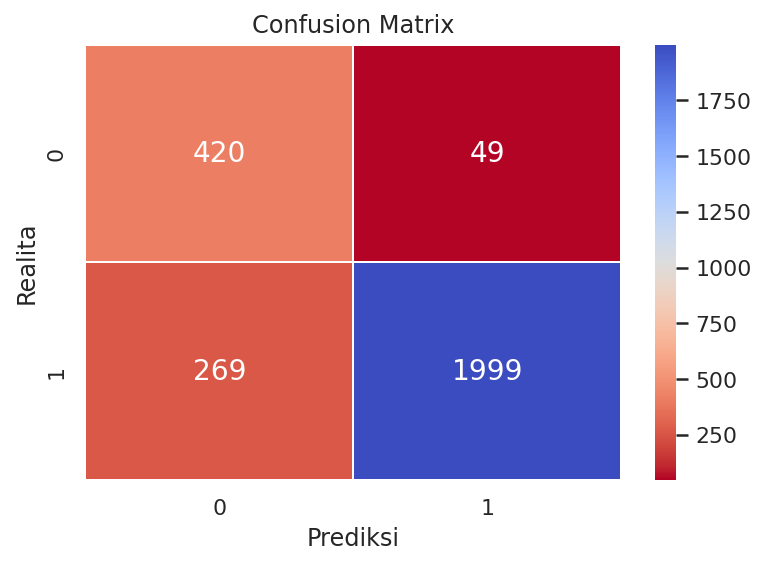

In [117]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train,rfc_pred_train))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       469
           1       0.97      0.99      0.98      2268

    accuracy                           0.96      2737
   macro avg       0.95      0.91      0.93      2737
weighted avg       0.96      0.96      0.96      2737



Text(30.5, 0.5, 'Realita')

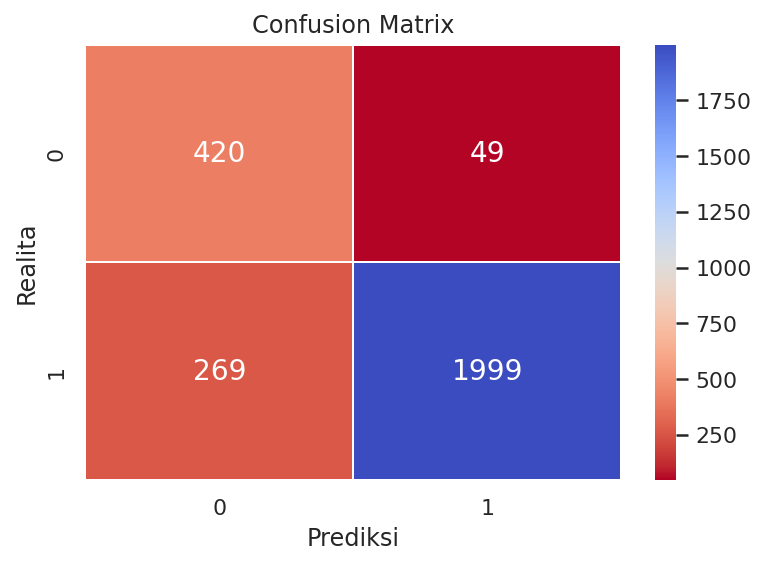

In [116]:
print(classification_report(y_test,rfc_pred_test))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')